# Analysis of Posner Cuing

Analyse the data from the PosnerCuing experiment. This notebook recreates the figures from the associated manuscript. This first performs the analysis of the behavioral data, then the neural analyses.


In [1]:
## Load in the necessary modules

import numpy as np
import os
import glob
import nibabel as nb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
from scipy.io import loadmat
import matplotlib
import pandas as pd
from nilearn import plotting
from matplotlib.colors import ListedColormap
from nilearn import image, datasets
import nibabel as nib
import scipy
import sys
import seaborn as sns
import pickle

np.random.seed(0)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  r

In [2]:
# Set the directories
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir)
data_dir = base_dir + 'data/PosnerCuing/'
plot_dir = base_dir + 'data/PosnerCuing/plots/'
LOO_ROI_dir = data_dir + '/LOO_ROIs/'

# Set up the colors    
valid_color = np.asarray([178, 49, 45]) / 255
neutral_color = np.asarray([252, 169, 115]) / 255
invalid_color = np.asarray([255, 154, 255]) / 255  

## Create the functions needed to analyze the PosnerCuing data
This is a long cell, you can just run it to define the functions

In [3]:
def analyze_RT_data(PooledRT, included_age, condition='Exogenous', threshold=0, fig_dir=1):
    # Analyze and plot the reaction time data from the participants

    # Compute the difference between valid vs invalid for each participant
    sample_data = {}
    sample_data['valid'] = []
    sample_data['neutral'] = []
    sample_data['invalid'] = []    
    diff_data = {}
    diff_data['invalid_valid'] = []
    diff_data['neutral_valid'] = []
    diff_data['invalid_neutral'] = []
    
    # Set up the participant data
    ppt_data = np.zeros((len(PooledRT), 3))
    
    valid_all = []
    invalid_all = []
    neutral_all = []
    overall_RT = []
    
    # Loop through the participants
    for ppt_counter, ppt in enumerate(PooledRT):
        
        if 'Valid' in PooledRT[ppt][condition] and 'Invalid' in PooledRT[ppt][condition] and 'Neutral' in PooledRT[ppt][condition]:
            # Pull out the RTs
            valid_RTs = PooledRT[ppt][condition]['Valid']
            invalid_RTs = PooledRT[ppt][condition]['Invalid']
            neutral_RTs = PooledRT[ppt][condition]['Neutral']
            
            # Threshold these values if necessary
            valid_RTs =  list(np.asarray(valid_RTs)[np.asarray(valid_RTs) > threshold])
            invalid_RTs =  list(np.asarray(invalid_RTs)[np.asarray(invalid_RTs) > threshold])
            neutral_RTs =  list(np.asarray(neutral_RTs)[np.asarray(neutral_RTs) > threshold])
            
            # Get the averages
            valid = np.mean(valid_RTs)
            invalid = np.mean(invalid_RTs)
            neutral = np.mean(neutral_RTs)
            overall_RT += [np.mean(valid_RTs + invalid_RTs + neutral_RTs)]
            
            # Store the ppt data
            ppt_data[ppt_counter, :] = [valid, neutral, invalid]
            
            # Get all of the condition data in one spot
            valid_all += valid_RTs
            invalid_all += invalid_RTs
            neutral_all += neutral_RTs

            # Print how many samples there are per person
            num_samples = len(valid_RTs) + len(invalid_RTs) + len(neutral_RTs)

            print('%s has %d trials' % (ppt, num_samples))
            
            # Store the number of samples per condition
            sample_data['valid'] += [len(valid_RTs)]
            sample_data['neutral'] += [len(neutral_RTs)]
            sample_data['invalid'] += [len(invalid_RTs)]
            
            # Compute the difference of each condition for each ppt
            diff_data['invalid_valid'] += [invalid - valid]
            diff_data['neutral_valid'] += [neutral - valid]
            diff_data['invalid_neutral'] += [invalid - neutral]
        else:
            print('Skipping %s because they don''t have any data from at least one condition' % ppt)
    
    # Correlate the valid RT and age
    plt.figure()
    plt.scatter(included_age, ppt_data[:, 0])
    r_val = np.corrcoef((included_age, ppt_data[:, 0]))[0, 1]
    p_val = randomise_corr(included_age, ppt_data[:, 0])
    print('Age x Valid RT: r = %0.2f, p = %0.3f' % (r_val, p_val))
    plt.title('r = %0.2f' % (r_val))
    plt.ylabel('Valid RT')
    plt.xlabel('Age')
    
    # Correlate age with average RTs
    plt.figure(figsize=(3,3))
    plt.scatter(included_age, overall_RT)
    r_val = np.corrcoef((included_age, overall_RT))[0, 1]
    p_val = randomise_corr(included_age, overall_RT)
    print('Age x overall RT: r = %0.2f, p = %0.3f' % (r_val, p_val))
    plt.title('r = %0.2f, p = %0.3f' % (r_val, p_val))
    plt.ylabel('Overall RT')
    plt.xlabel('Age')
    plt.xlim([3, 13])
    plt.xticks([4, 6, 8, 10, 12], [4, 6, 8, 10, 12])
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(fig_dir + 'Age_RT_scatter.svg')
    
    # Report the mean and t test difference for each contrast
    for diff_type in diff_data:
        
        # Get the color ID for the scatter
        if diff_type is 'invalid_valid':
            top_color = invalid_color
            bot_color = valid_color
        elif diff_type is 'neutral_valid':
            top_color = neutral_color
            bot_color = valid_color
        elif diff_type is 'invalid_neutral':
            top_color = invalid_color
            bot_color = neutral_color

        plt.figure(figsize=(2,1.5))
        #plt.plot(included_age, diff_data[diff_type], fillstyle='bottom', color=bot_color, marker='o', linestyle='', markerfacecoloralt=top_color, markeredgecolor='none', markersize=7)
        plt.plot(included_age, diff_data[diff_type], color=[0.5, 0.5, 0.5], marker='o', linestyle='', markeredgecolor='none', markersize=7)

        # Remove any nans that should be excluded
        x_vals = np.asarray(included_age)[(np.isnan(included_age) == False) * (np.isnan(diff_data[diff_type]) == False)]
        y_vals = np.asarray(diff_data[diff_type])[(np.isnan(included_age) == False) * (np.isnan(diff_data[diff_type]) == False)]

        r_val = np.corrcoef((x_vals, y_vals))[0, 1]
        pval = randomise_corr(x_vals, y_vals)

        resample_p = ' p=%0.3f' % pval

        plt.title('%s: %0.2f%s' % (diff_type, r_val, resample_p))
        plt.ylim([-0.1, 0.5])
        plt.yticks([0, 0.2, 0.4], [0, 0.2, 0.4])
        plt.ylabel('RT difference (s)')
        plt.xlim([3, 13])
        plt.xticks([4, 6, 8, 10, 12], [4, 6, 8, 10, 12])
        plt.xlabel('Age')

        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if fig_dir is not None:
            plt.savefig(fig_dir + 'RT_different_%s_scatter.svg' % diff_type)

        temp = np.asarray(diff_data[diff_type])
        temp = temp[np.isnan(temp) == 0]
        
        # Perform bootstrapping on the data
        pval, CI, sign_count =  randomise_diff(temp)
            
#         [tstat, pval] = stats.ttest_1samp(temp, 0)

        print('\nSummary\n%s  %d/%d participants, M=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (diff_type, sign_count, len(temp), np.nanmean(diff_data[diff_type]), CI[0], CI[1], pval))
        
        # Make plots of the difference
        plt.figure()
        plt.hist(diff_data[diff_type])
        plt.xlim([-0.1, 0.4])
        plt.ylabel('Counts')
        plt.xlabel('RT difference (s)')
        plt.title('%s' % diff_type)
        if fig_dir is not None:
            plt.savefig(fig_dir + 'RT_different_%s_hist.svg' % diff_type)
   
        
    # Plot the distribution for the valid and invalid trials
    plt.figure(figsize=(3,3))
    bins = np.arange(0, 1.05, 0.05)
    colors = [valid_color, neutral_color, invalid_color]
    for condition_counter, condition_data in enumerate([valid_all, neutral_all, invalid_all]):
        
        counts, bin_borders = np.histogram(condition_data, bins)

        plt.plot(bin_borders[:-1], counts, color=colors[condition_counter])
    plt.legend(['Valid', 'Neutral', 'Invalid'])
    if fig_dir is not None:
        plt.savefig(fig_dir + 'RT_trial_hist_all.svg')
    
    plt.figure(figsize=(2,6))
    plt.plot(ppt_data.T, color=[0.5, 0.5, 0.5, 0.5], linewidth=0.25)
    plt.bar([0, 1, 2], np.nanmean(ppt_data, 0), color=[valid_color, neutral_color, invalid_color])
    plt.errorbar([0, 1, 2], np.nanmean(ppt_data, 0), yerr=np.nanstd(ppt_data, 0) / np.sqrt(ppt_data.shape[0]), fmt='none', color=np.asarray([valid_color, neutral_color, invalid_color]) * 0.75)
    plt.xticks([0, 1, 2], ['Valid', 'Neutral', 'Invalid'])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if fig_dir is not None:    
        plt.savefig(fig_dir + 'RT_condition.svg')
    
    plt.figure()
    plt.scatter(included_age, ppt_data[:, 0], color=valid_color)
    plt.scatter(included_age, ppt_data[:, 1], color=neutral_color)
    plt.scatter(included_age, ppt_data[:, 2], color=invalid_color)
    
    for ppt_counter in range(ppt_data.shape[0]):
        plt.plot([included_age[ppt_counter], included_age[ppt_counter]], [ppt_data[ppt_counter, 0], ppt_data[ppt_counter, 1]], color=[0.5, 0.5, 0.5, 0.5])
        plt.plot([included_age[ppt_counter], included_age[ppt_counter]], [ppt_data[ppt_counter, 1], ppt_data[ppt_counter, 2]], color=[0.5, 0.5, 0.5, 0.5])
    
    # Plot the cross correlation of the data
    plt.figure()
    plt.scatter(diff_data['invalid_neutral'], diff_data['neutral_valid'])
    plt.ylabel('Neutral>Valid')
    plt.xlabel('Invalid>Neutral')
    
    # Store this data too
    diff_data['valid'] = ppt_data[:, 0]
    diff_data['neutral'] = ppt_data[:, 1]
    diff_data['invalid'] = ppt_data[:, 2]
    
    # Correlate the valid RT and the invalid - valid RT diff
    plt.figure()
    plt.scatter(diff_data['valid'], diff_data['invalid_valid'])
    plt.ylabel('Invalid>Valid')
    plt.xlabel('Valid')
    
    # Correlate the number of invalid trials and the invalid - valid RT diff
    plt.figure()
    plt.scatter(sample_data['invalid'], diff_data['invalid_valid'])
    plt.ylabel('Invalid>Valid')
    plt.xlabel('Invalid trial numbers')
    
    # Return the difference data
    return diff_data

def quantify_saccades():

    ## Analyze the number of saccades per participant for each trial type
    valid_switches_all = []
    neutral_switches_all = []
    invalid_switches_all = []

    for ID in df['ID']:

        data = scipy.io.loadmat(data_dir + '/Trial_timecourse/%s.mat' % ID)

        valid_switches = []
        neutral_switches = []
        invalid_switches = []

        # Loop through all events
        for condition_counter in range(data['CueSide_all'].shape[0]):
            for rep_counter in range(data['CueSide_all'].shape[1]):
                for event_counter in range(data['CueSide_all'].shape[2]):

                    # Pull out the relevant information
                    CueSide = data['CueSide_all'][condition_counter, rep_counter, event_counter]
                    TargetSide = data['TargetSide_all'][condition_counter, rep_counter, event_counter]

                    # Only do this if the target actually appeared
                    if (data['TargetOns_all'][condition_counter, rep_counter, event_counter].shape[1] > 0) and (np.isnan(data['TargetOns_all'][condition_counter, rep_counter, event_counter][0][0]) == 0):

                        # When does the cue and target start
                        Cue_idx = np.min(np.where(data['timestamps_all'][condition_counter, rep_counter, event_counter] > data['CueOns_all'][condition_counter, rep_counter, event_counter])[0])
                        Target_idx = np.min(np.where(data['timestamps_all'][condition_counter, rep_counter, event_counter] > data['TargetOns_all'][condition_counter, rep_counter, event_counter])[0])

                        # what were the frames coded as for cue and target
                        cue_frames = (data['timecourse_all'][condition_counter, rep_counter, event_counter][0, Cue_idx:Target_idx]).astype('float')
                        usable_frames = (data['timecourse_all'][condition_counter, rep_counter, event_counter]).astype('float')

                        # Check that there are sufficient usable cue frames
                        if np.mean((cue_frames == 1) + (cue_frames == 2) + (cue_frames == 3)) >= 0.5:

                            # Set the frames that are unusable to nan
                            usable_frames[((usable_frames == 1) + (usable_frames == 2) + (usable_frames == 3)) == 0] = np.nan

                            # How many switches were there?
                            switches = np.sum(np.abs(np.diff(usable_frames)) > 0)

                            # Check that the participant is usable (that they look to the target side and not already looking)
                            # Note the number of switches could be zero if the participant was looking off-screen after seeing the target
                            if (usable_frames[0, Target_idx] != TargetSide) and np.any(usable_frames[0, Target_idx:] == TargetSide):

                                # What condition did the switch occur in
                                if CueSide == 0:
                                    neutral_switches += [switches]
                                elif CueSide == TargetSide:
                                    valid_switches += [switches]
                                else:
                                    invalid_switches += [switches]

        valid_switches_all += [np.mean(valid_switches)]
        neutral_switches_all += [np.mean(neutral_switches)]
        invalid_switches_all += [np.mean(invalid_switches)]


    print('Average switches on valid trials: %0.2f' % np.mean(valid_switches_all))    
    print('Average switches on neutral trials: %0.2f' % np.mean(neutral_switches_all))    
    print('Average switches on invalid trials: %0.2f' % np.mean(invalid_switches_all))    

    # Get the statistics
    pval, CI, _ = randomise_diff(np.asarray(invalid_switches_all) - np.asarray(valid_switches_all))    
    print('Invalid>Valid: CI=[%0.2f, %0.2f], p=%0.3f' % (CI[0], CI[1], pval))

    pval, CI, _ = randomise_diff(np.asarray(neutral_switches_all) - np.asarray(valid_switches_all))    
    print('Neutral>Valid: CI=[%0.2f, %0.2f], p=%0.3f' % (CI[0], CI[1], pval))

    pval, CI, _ = randomise_diff(np.asarray(invalid_switches_all) - np.asarray(neutral_switches_all))    
    print('Invalid>Neutral: CI=[%0.2f, %0.2f], p=%0.3f' % (CI[0], CI[1], pval))

        
def analysis_type_conditions(analysis_type):
    # Convert an analysis type name (e.g., 'Validity) into a list of conditions that correspond to the contrasts run. In other words zstat1 of the Validity analyses is called 'valid_invalid' which means valid greater than invalid
    
    if analysis_type == 'Validity':
        conditions = ['valid_invalid', 'valid_neutral', 'invalid_neutral', 'valid_neutral-invalid', 'invalid_neutral-valid', 'valid', 'neutral', 'invalid', 'valid-invalid_neutral']
    elif analysis_type == 'Saccades':
        conditions = ['saccades_vs_rest']
    else:
        print('%s not found. Will end in error' % analysis_type)
        
    return conditions

        

def randomise_diff(diff_data, resample_num=10000):        
    # Bootstrap resampling of data. Takes in an array and returns the two tailed p value of the difference from zero
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):

        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(diff_data), (1, len(diff_data)))

        resample_diff += [np.mean(diff_data[sub_idx])]

    # What direction was the effect
    sign_count = np.sum((diff_data) > 0)

    # Calculate the 2 way p value
    p_val = (1 - (np.sum(np.asarray(resample_diff) > 0) / (resample_num))) * 2
    
    # If greater than 1 then subtract from 2
    if p_val > 1:
        p_val = 2 - p_val
        
    CI =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    # return the difference in ROI and 
    return p_val, CI, sign_count

def randomise_corr(x_vals, y_vals, resample_num=10000):        
    # Bootstrap resampling of correlations. Takes in x and y values and returns the two tailed p value of the distribution of correlations.
    
    # Check that the metrics aren't lists
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)    
    
    # Resample the participants
    resample_corr = []
    for i in range(resample_num):

        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(x_vals), (1, len(x_vals)))
       
        resample_corr += [np.corrcoef(x_vals[sub_idx], y_vals[sub_idx])[0, 1]]

    # Calculate the 2 way p value
    p_val = (1 - (np.sum(np.asarray(resample_corr) > 0) / (resample_num + 1))) * 2
    
    # If greater than 1 then subtract from 2
    if p_val > 1:
        p_val = 2 - p_val
    
    # return the corr p value
    return p_val



def mask_ROIs(vol, ROI, collapse_bilateral, use_corrected_p_val=True, use_beeswarm=True):
    # Mask the 4d data with the provided ROIs and compute statistics. This has functionality for collapsing ROIs bilaterally. Holms-Bonferroni correction can also be performed
      
    # Cycle through the ROI
    ROI_idxs = np.unique(ROI)[1:] # Ignore the 0's
    
    if collapse_bilateral == 1:
        ROI_idxs = ROI_pairs
    
    plt.figure()
    sig_ROI_position = []
    p_vals = []
    labels = []
    beeswarm_list_x = []
    beeswarm_list_y = []
    for ROI_counter, ROI_idx in enumerate(ROI_idxs):
        
        # Are you averaging multiple ROIs
        if isinstance(ROI_idx, list):
            
            # Sum the ROI values
            ROI_summed = np.zeros(ROI.shape)
            for idx in ROI_idx:
                ROI_summed += (ROI == idx)
            ROI_vals = vol[ROI_summed == 1]
            
            # What is this ROI's name
            if collapse_bilateral == True:
                ROI_name = ns_ROI_names_bilateral[ROI_counter]
                bar_color = ns_ROI_color_dict[ROI_name]
                
                # Remove the first letter since it is a side
                if len(ROI_idx) > 1:
                    ROI_name = ns_ROI_names_bilateral[ROI_counter][1:]
            else:
                ROI_name = ns_ROI_names[ROI_idx[0] - 1]
                bar_color = ns_ROI_color_dict[ROI_name]
        else:

            # Mask volume
            ROI_vals = vol[ROI == ROI_idx]
            
            if collapse_bilateral == True:
                ROI_name = ns_ROI_names_bilateral[ROI_counter]
                bar_color = ns_ROI_color_dict[ROI_name]
            else:
                ROI_name = ns_ROI_names[ROI_counter]
                bar_color = ns_ROI_color_dict[ROI_name]

        # Get the voxels in the mask
        intersect_voxels = np.sum(np.abs(ROI_vals), 1) > 0

        # Get the average value per participant
        ppt_vals = np.mean(ROI_vals[intersect_voxels, :], 0)
        
        # Plot the data
        plt.bar(ROI_counter, np.mean(ppt_vals), color=bar_color, zorder=0)
        plt.errorbar(ROI_counter, np.mean(ppt_vals), yerr= np.std(ppt_vals) / np.sqrt(len(ppt_vals)), ecolor='k', elinewidth=2, zorder=5)
        if use_beeswarm == True:
            beeswarm_list_x += list(np.repeat(ROI_counter, len(ppt_vals)))
            beeswarm_list_y += list(ppt_vals)
        else:
            plt.scatter(np.repeat(ROI_counter, len(ppt_vals)), ppt_vals, c='k', alpha=0.4)

        #Get the stats
        p_val, CI, count = randomise_diff(ppt_vals)
        
        # Add the ROIs
        if p_val < 0.05:
            sig_ROI_position += [ROI_counter]
        
        print('%s: %d/%d, M=%0.2f, CI=[%0.2f, %0.2f], p=%0.3f' % (ROI_name, count, len(ppt_vals), np.mean(ppt_vals), CI[0], CI[1], p_val))
        
        # Store the information
        p_vals += [p_val]
        labels += [ROI_name]
    
    # Make the plot
    if use_beeswarm == True:
        sns.swarmplot(beeswarm_list_x, beeswarm_list_y, color='k', alpha=0.25, size=7)
        
    # Use the corrected sig ROIs or just p<0.05?
    if use_corrected_p_val is True:
        
        # Run the correction test
        corrected_df, sig_ROI_names = holms_bonferroni_correction(labels, p_vals)
        print(corrected_df)

        # Where is the ROI idx
        sig_ROI_position = [] # Reset
        for sig_ROI_name in sig_ROI_names:
            sig_ROI_idx = labels.index(sig_ROI_name)
            
            sig_ROI_position += [sig_ROI_idx]
    else:
        # Where is the significant ROI
        sig_ROI_position = np.where(np.asarray(p_vals) < 0.05)[0]
            
    # Plot sig values
    for loc in sig_ROI_position:
        plt.text(loc, max_y_val * 0.95, '*', ha='center', va='center', color='red')
    
    # Set the axes
    plt.xticks(np.arange(len(ROI_idxs)), labels, rotation=90);
                                                  
    plt.ylim([-max_y_val, max_y_val])
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
    
def correlate_ROIs(vol, ROI, metric, plot=0, collapse_bilateral=0, fig_size=(18, 18)):
    # Correlate the ROI values with the metric provided. Assumes the 4th dimension of the volumes aligns with the metric provided
    
    # Deal with bilateral ROIs
    if collapse_bilateral == 0:
        ROI_idxs = np.unique(ROI)[1:] # Ignore the 0's
    else:
        ROI_idxs = ROI_pairs
        
    if plot == 1:
        plt.figure(figsize=fig_size)
        
    for ROI_counter, ROI_idx in enumerate(ROI_idxs):    
        
        # Are you averaging multiple ROIs
        if isinstance(ROI_idx, list):
            
            # Sum the ROI values
            ROI_summed = np.zeros(ROI.shape)
            for idx in ROI_idx:
                ROI_summed += (ROI == idx)
            ROI_vals = vol[ROI_summed == 1]
            
            # What is this ROI's name
            if collapse_bilateral == True:
                # Remove the first letter since it is a side
                ROI_name = ns_ROI_names_bilateral[ROI_counter][1:]
            else:
                ROI_name = ns_ROI_names[ROI_idx[0] - 1]
        else:

            # Mask volume
            ROI_vals = vol[ROI == ROI_idx]
            
            if collapse_bilateral == True:
                ROI_name = ns_ROI_names_bilateral[ROI_counter]
            else:
                ROI_name = ns_ROI_names[ROI_counter]
        
        # Get the voxels in the mask
        intersect_voxels = np.sum(np.abs(ROI_vals), 1) > 0

        # Get the average value per participant
        ppt_vals = np.mean(ROI_vals[intersect_voxels, :], 0)

        r = np.corrcoef(metric, ppt_vals)[0, 1]
        
        p_val = randomise_corr(metric, ppt_vals)
        
        if p_val < 0.05:
            color = 'b'
        else:
            color = [0.5, 0.5, 0.5]
        
        # Either plot or report the correlation
        if plot == 1: 
            plt.subplot(np.ceil(np.sqrt(len(ROI_idxs))), np.ceil(np.sqrt(len(ROI_idxs))), ROI_counter + 1)
            plt.scatter(metric, ppt_vals, c=color, s=150)
            
            # Plot the horizontal line
            plt.hlines(0, xmin=np.min(metric), xmax=np.max(metric), linestyles='dashed')
            
            # Set the axes
            ax = plt.gca()
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.ylim([-max_y_val, max_y_val])
            if np.max(metric)> 1:
                plt.xlim((3, 12))
                ax.set_aspect(0.9)
            
            plt.title('%s: r=%0.2f, p=%0.3f' % (ROI_name, r, p_val))  
        else:
            print('%s: r=%0.2f, p=%0.3f' % (ROI_name, r, p_val))  


def merge_ppts_LOO(ppt_ids, output_dir, tstat_contrast=2, analysis_type='Validity', condition_num=1, p_val=0.975):
    # Merge participants that are described, assume it is for LOO participants so don't run anything other tstat1 and clustering
    
    # Make the directory to output files to
    if os.path.exists(output_dir) == 0:
        command = 'mkdir -p %s' % output_dir
        print(command + '\n')
        os.system(command)
    
    # Specify the condition
    conditions = analysis_type_conditions(analysis_type)    
    condition = conditions[condition_num - 1] # Subtract 1 because this starts counting at one

    # Convert the pvalue into a t stat
    tstat_thresh = stats.t.ppf(p_val, len(ppt_ids))

    ppt_list = ''
    for ppt_counter, ppt_id in enumerate(ppt_ids):

        # What is the file name
        filename = nib.load('%s/%s/Validity_%s_ROIs.nii.gz' % (LOO_ROI_dir, ppt_id, condition))

        # Append the name to the list
        ppt_list += filename + ' '

    merged_name = output_dir + 'merged_' + analysis_type + '_' + condition + '.nii.gz'

    if os.path.exists(merged_name) == 0:
        # Specify the output name
        command = 'fslmerge -t %s %s' % (merged_name, ppt_list)

        # Run this unix command
        print(command + '\n')
        #print('Merge command too long, not printing\n')
        os.system(command)

    # Create an intersect mask of the data
    mask_name = output_dir + 'mask_' + analysis_type + '_' + condition + '.nii.gz'

    if os.path.exists(mask_name) == 0:
        command = 'fslmaths %s -abs -bin -Tmean -thr 1 %s' % (merged_name, mask_name)

        # Run this unix command
        print(command + '\n')
        os.system(command)
    
    # Mask the data so that you are using only included voxels
    masked_name = output_dir + 'masked_' + analysis_type + '_' + condition + '.nii.gz'
    if os.path.exists(masked_name) == 0:
        command = 'fslmaths %s -mas %s %s' % (merged_name, mask_name, masked_name)
        
        # Run this command
        print(command + '\n')
        os.system(command)
    
    # Create the t stat map of this data
    tstat_name = output_dir + analysis_type + '_' + condition
    if os.path.exists(tstat_name + '_tstat%d.nii.gz' % tstat_contrast) == 0:
        command = './prototype/link/scripts/run_randomise.sh -i %s -o %s -1 -t scripts/PosnerCuing/contrast.con' % (masked_name, tstat_name)
        
        # Run this command
        print(command + '\n')
        os.chdir('../../')
        os.system(command)
        os.chdir('scripts/PosnerCuing/')
        
        
    # Create the cluster data if it doesn't exist
    cluster_name = output_dir + analysis_type + '_' + condition + '_ROIs'
    if os.path.exists(cluster_name + '.txt') == 0:
        command = 'cluster --in=%s_tstat%d.nii.gz -t %0.3f --minextent=27 -o %s.nii.gz > %s.txt' % (tstat_name, tstat_contrast, tstat_thresh, cluster_name, cluster_name)
        print(command + '\n')
        os.system(command)
            

def mask_LOO_roi(LOO_df, plot_separate_ns=True, flip_sign=False, plot_color=False, use_corrected_p_val=True, use_beeswarm=True):
    # Mask the data for each participant using the LOO clusters defined for that participant and store data from the same clusters across participants together. Then analyze the data and perform corrections
    
    ROI_names = list(LOO_df.keys())[1:] # Ignore the first
    plt.figure()
    sig_ROI_position = []
    sig_ROI_names = []
    ROI_position = []
    
    # Store for running correction
    p_vals = []
    labels = []
    
    beeswarm_list_y = []
    beeswarm_list_x = []
    
    if flip_sign == True:
        print('Flipping sign for consistency')
    
    position_counter = -1 # Needs to be negative 1 to suit beeswarm which is buggy if not starting at zero
    ns_counter = 0
    for ROI_counter, ROI_name in enumerate(ROI_names):

        # Get the average value per participant
        ppt_vals = np.asarray(LOO_df[ROI_name])
        
        # Flipping the sign
        if flip_sign == True:
            ppt_vals *= -1
        
        # Drop all nan values
        ppt_vals = ppt_vals[np.isnan(ppt_vals) == 0]
        
        # Plot the data
        if (ROI_name[:2] == 'l_') or (ROI_name[:2] == 'r_'):
            temp_ROI_name = ROI_name[2:]
        else:
            temp_ROI_name = ROI_name
            
        # Plot the data with the color if it is from the neurosynth set
        if temp_ROI_name in ns_ROI_color_dict:
            
            # Increment counter
            if plot_separate_ns is True:
                ns_counter -= 1
                current_position = ns_counter
            else:
                position_counter += 1
                current_position = position_counter
            
            # Plot the ns data
            plt.bar(current_position, np.mean(ppt_vals), color=ns_ROI_color_dict[temp_ROI_name], zorder=0)
            
        else:
            # Increment counter
            position_counter += 1
            current_position = position_counter
            
            # Plot the bar
            if plot_color is False:
                plt.bar(current_position, np.mean(ppt_vals), color=[0.75, 0.75, 0.75], zorder=0)
            else:
                plt.bar(current_position, np.mean(ppt_vals), color=ROI_colors[ROI_counter, :], zorder=0)
        
        plt.errorbar(current_position, np.mean(ppt_vals), yerr= np.std(ppt_vals) / np.sqrt(len(ppt_vals)), ecolor='k', elinewidth=2, zorder=5)
        
        if use_beeswarm == True:
            beeswarm_list_x += list(np.repeat(current_position, len(ppt_vals)))
            beeswarm_list_y += list(ppt_vals)
        else:    
            plt.scatter(np.repeat(current_position, len(ppt_vals)), ppt_vals, c='k', alpha=0.4)

        # Get the stats
        p_val, CI, count = randomise_diff(ppt_vals)
        
        # Store the information
        p_vals += [p_val]
        
        #Store the positions for each ROI
        ROI_position += [current_position]
        
        # Add the ROIs
        if p_val < 0.05:
            sig_ROI_position += [current_position]
            sig_ROI_names += [ROI_name]

        print('%s: M=%0.2f, %d/%d, p=%0.3f' % (ROI_name, np.mean(ppt_vals), count, len(ppt_vals), p_val))
    
    # Make the plot
    if use_beeswarm == True:
        if len(np.unique(beeswarm_list_x)) > 7:
            marker_size = 7 / (len(np.unique(beeswarm_list_x)) / 7) # Make marker size balanced when there are more ROIs
        else:
            marker_size = 7
        sns.swarmplot(beeswarm_list_x, beeswarm_list_y, color='k', alpha=0.25, size=marker_size)
    
    # Use the corrected sig ROIs or just p<0.05?
    if use_corrected_p_val is True:
        
        # Run the correction test
        corrected_df, sig_ROI_names = holms_bonferroni_correction(ROI_names, p_vals)
        print(corrected_df)

        # Where is the ROI idx
        sig_ROI_position = [] # Reset
        for sig_ROI_name in sig_ROI_names:
            sig_ROI_idx = ROI_names.index(sig_ROI_name)
            
            sig_ROI_position += [ROI_position[sig_ROI_idx]]
    
    # Plot sig values
    for loc in sig_ROI_position:
        plt.text(loc, max_y_val * 0.95, '*', ha='center', va='center', color='k')

    # Set the axes
    plt.xticks(ROI_position, convert_ROI_names(ROI_names), rotation=90);
    plt.ylim([-max_y_val, max_y_val])
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return sig_ROI_names


def create_ROI_names(input_dir, analysis_type='Validity_valid_invalid', min_prct_ROI=10, use_ns_atlas=0):
    # Load the list of ROI names for clusters that were identified by FSL for this participant and load in as a list
    
    if os.path.exists('%s/%s_ROI_names.txt' % (input_dir, analysis_type)) == 0:
        
        # Load the ROI information
        ROI_df = pd.read_csv('%s/%s_ROIs.txt' % (input_dir, analysis_type), sep='\t')
        nii = nib.load('%s/%s_ROIs.nii.gz' % (input_dir, analysis_type))

        # Cycle through the ROIs
        ROI_names = []
        cluster_idxs = []
        
        f_ROI = open('%s/%s_ROI_names.txt' % (input_dir, analysis_type), 'w')
        f_ROI.write('cluster idx\tROI name\n')

        for ROI_counter in range(ROI_df.shape[0]):

            # Load the coordinates for this 
            cluster_idx = ROI_df['Cluster Index'][ROI_counter]
            x_coord = ROI_df['MAX X (vox)'][ROI_counter]
            y_coord = ROI_df['MAX Y (vox)'][ROI_counter]
            z_coord = ROI_df['MAX Z (vox)'][ROI_counter]
            
            # Get the MNI coordinates
            mni_coords = image.coord_transform(x_coord, y_coord, z_coord, nii.affine)
            
            # Determine the hemisphere:
            if mni_coords[0] < 0:
                hemi = 'l_'
            else:
                hemi = 'r_'
                
            # Are you using MNI or tal coordinates
            if use_ns_atlas == 2:
                mni2tal_name = '%s/../%s_tal_coords.csv' % (input_dir, analysis_type)
                if os.path.exists(mni2tal_name) == 0:
                    print('Warning, cannot find %s needed for conversion. Use `generate_MNI_2_tal_names(analysis_type=''%s'')` to generate it\nQuitting\n' % (mni2tal_name, analysis_type))
                    return
                
                # Load the file
                mni2tal_df = pd.read_csv(mni2tal_name, sep=',')
                
                # Search for matching coordinates and pull out the name
                for idx_counter in range(len(mni2tal_df['#MNIX'])):
                    if (mni_coords[0] == mni2tal_df['#MNIX'][idx_counter]) and (mni_coords[1] == mni2tal_df['MNIY'][idx_counter]) and (mni_coords[2] == mni2tal_df['MNIZ'][idx_counter]):
                        roi_text = mni2tal_df['BA'][idx_counter]
                
                # Did you not find it? If so, relabel it for compatibility
                if roi_text == 'Outside defined BAs':
                    roi_text = '<br> No label found!'
                    
            else:

                # If you are using the ns atlas (either in addition to harvard oxford or in lieu of) then load it here and specify the ROI text
                # If you cannot find a label then use make it say 'no label found'
                roi_text = '<br> No label found!' # Preset until it is changed
                if abs(use_ns_atlas) == 1:

                    # What is the ROI value?
                    roi_val = ns_ROI[x_coord, y_coord, z_coord]

                    # if this is a value, spoof the ROI text for the purpose of using it. Subtract 1 to count from zero
                    if roi_val > 0:
                        roi_text = '<br> 100%% %s ' % ns_ROI_names[roi_val - 1]

                # If you aren't just using the neurosynth atlas and you didn't find it there then proceed
                if use_ns_atlas != 1 and roi_text.find('No label found!') > 0:

                    # Determine the atlas coordinates
                    os.system('atlasquery -a "Harvard-Oxford Cortical Structural Atlas" -c %d,%d,%d > %s/temp.txt' % (mni_coords[0], mni_coords[1], mni_coords[2], input_dir))

                    # Load in the information
                    f = open('%s/temp.txt' % (input_dir), 'r')
                    roi_text = f.readlines()[0]
                    f.close()

                    # If there is no label or the percentage is insufficent then use the subcortical atlas 
                    if roi_text.find('No label found!') > 0:
                        use_subcortical = 1 
                    else:

                        # Pull out the percentage of this ROI and then use it to decide if it subcortical or not
                        prct_val = int(roi_text[roi_text.rfind('<br>') + 4:roi_text.find('%')])

                        if prct_val < min_prct_ROI:
                            use_subcortical = 1 
                        else:
                            use_subcortical = 0

                    if use_subcortical == 1:
                        os.system('atlasquery -a "Harvard-Oxford Subcortical Structural Atlas" -c %d,%d,%d > %s/temp.txt' % (mni_coords[0], mni_coords[1], mni_coords[2], input_dir))

                        f = open('%s/temp.txt' % (input_dir), 'r')
                        roi_text = f.readlines()[0]
                        f.close()

            # Check that you found a usable label
            if roi_text.find('No label found!') < 0:

                # Figure out when the first ROI name starts and stops. It is a little finnicky
                if use_ns_atlas == 2:
                    if roi_text.find(' (') > 0:
                        roi_text = roi_text[:roi_text.rfind('(') - 1]
                        
                    ROI_name = roi_text
                else:
                    start_idx = roi_text.find('%') + 2
                    end_idx = roi_text[start_idx:].find('%')

                    if end_idx > -1:
                        ROI_name = roi_text[start_idx:roi_text[:end_idx + start_idx].rfind(',')]
                    else:
                        ROI_name = roi_text[start_idx:-1]

                # Add the hemisphere to the name
                ROI_name = hemi + ROI_name

                # Check the last character isn't a space
                if ROI_name[-1] is ' ':
                    ROI_name = ROI_name[:-1]

                # Check that this is not in the list of ROIs to be ignored
                if len(np.where(ignored_ROIs == ROI_name)[0]) == 0:

                    # Write the ROI names to a file with a similar structure to the ROI information so it can be loaded faster
                    ROI_names += [ROI_name]
                    cluster_idxs += [cluster_idx]
                    f_ROI.write('%d\t%s\n' % (cluster_idx, ROI_name))


        # Close    
        f_ROI.close()
    else:
        # Load the ROI names that were created previously
        ROI_df = pd.read_csv('%s/%s_ROI_names.txt' % (input_dir, analysis_type), sep='\t')
        
        # Pull out the columns
        ROI_names = list(ROI_df['ROI name'])
        cluster_idxs = list(ROI_df['cluster idx'])
    
    return ROI_names, cluster_idxs

    

def generate_LOO_df(ppt_ids, condition, usable_ROIs, ROI_names_all, cluster_idxs_all, LOO_condition=None):
    # Specify an analysis type and condition you want to extract data from and then use LOO ROIs to extract the values from this contrast
    # If you don't specify the two LOO_ inputs then this will compute the ROI values for the input contrast; however, it is possible to specify a different LOO ROI set
    
    # If these values aren't provided then make them match, otherwise allow them to differ
    if LOO_condition is None:
        LOO_condition = condition
    
    # Get the condition number from this condition
    conditions = analysis_type_conditions('Validity') 
    condition_num = np.where(np.asarray(conditions) == condition)[0][0]

    # Set up the dictionary to story data
    LOO_df = {}
    LOO_df['Ppt'] = []
    for ROI in usable_ROIs:
        LOO_df[ROI] = []

    # Go through each participant and pull out all of the usable ROIs
    for ppt_counter, ppt_id in enumerate(df['ID']):

        LOO_df['Ppt'] += [ppt_id]

        # Load the participant data 
        filename = '%s/contrast_maps/%s_Validity_zstat%d.nii.gz' % (data_dir, ppt_id, condition_num + 1)
        nii = nib.load(filename)
        vol = nii.get_data()

        # Load the ROI data
        ROI = nib.load('%s/%s/Validity_%s_ROIs.nii.gz' % (LOO_ROI_dir, ppt_id, LOO_condition)).get_data()

        # Cycle through ROIs that were deemed usable
        for usable_ROI in usable_ROIs:

            # For this participant find which ROIs, if any match this one
            ROI_idxs = np.where(np.asarray(ROI_names_all[ppt_counter]) == usable_ROI)[0]

            # Find what ROI idxs map on to cluster idxs
            cluster_idxs = np.asarray(cluster_idxs_all[ppt_counter])[ROI_idxs]

            # If there are any matches then use them
            if len(cluster_idxs) > 0:

                # Do the ROI analyses on all matching ROIs
                voxels = []
                for cluster_idx in cluster_idxs:

                    # Append the voxels to be used
                    voxels += list(vol[ROI == cluster_idx])

                # Average the voxels
                ROI_val = np.mean(voxels)

            else:

                # Store the nan value
                ROI_val = np.nan

            LOO_df[usable_ROI] += [ROI_val]

    return LOO_df


def holms_bonferroni_correction(labels, p_vals, alpha=0.05):
    # Take in a list of labels and an associated list of p values. This performs the computation of the Holms-Bonferroni correction (https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method)
    # This returns a data frame listing the corrected p threshold for each label and whether it is significant or not

    total_tests = len(p_vals)    

    # Rank the p values from lowest to highest (Note it is lowest to highest, meaning the test is 'hardest' for the most extreme value)  
    p_idxs = np.argsort(p_vals)

    sorted_p = []    
    sorted_labels = []
    corrected_thresholds = []
    is_sig = []
    df = {}
    for test_counter, p_idx in enumerate(p_idxs):

        # Get the ranked p values
        sorted_p += [p_vals[p_idx]]
        sorted_labels += [labels[p_idx]]

        # What is the new threshold
        corrected_threshold = alpha / (total_tests + 1 - (test_counter + 1))
        corrected_thresholds += [corrected_threshold]

        # Is this p value below significance
        if p_vals[p_idx] < corrected_threshold:
            is_sig += [1]
        else:
            is_sig += [0]

    # Store the values
    df['labels'] = sorted_labels
    df['orig p'] = sorted_p
    df['corr thresh'] = corrected_thresholds
    df['is sig'] = is_sig
    
    # Convert to pandas
    df = pd.DataFrame.from_dict(df)
    
    # Which ROIs are significant?
    sig_ROI_names = np.asarray(sorted_labels)[np.where(is_sig)[0]]
    
    return df, sig_ROI_names

def unique_ROIs(ppt_ids, condition, min_ppt_ROI = 0.5):
    # Create or load the ROI labels for each cluster and find which ones are unique and which ones occur with sufficient frequency across participants to be used
    
    # How many participants is enough to consider usable
    min_ppts = int(len(ppt_ids) * min_ppt_ROI)
    
    # Iterate through the participants 
    ROI_names_all = []
    cluster_idxs_all = []
    for ppt_id in ppt_ids:

        #print(ppt_id)

        # Label each ROI
        ROI_names, cluster_idxs = create_ROI_names( '%s/%s' % (LOO_ROI_dir, ppt_id), 'Validity_' + condition)

        # Store the data for the participant    
        ROI_names_all += [ROI_names]
        cluster_idxs_all += [cluster_idxs]

    # List all of the ROIs with unique names (first aggregate within participants and then between)
    temp_ROI_names_all = []
    for ROI_names in ROI_names_all:
        temp_ROI_names_all += list(np.unique(ROI_names))

    [all_unique_ROIs, counts] = np.unique(temp_ROI_names_all, return_counts=True)

    # Find the ROIs that are shared across at least this many participants
    usable_ROIs = all_unique_ROIs[counts >= min_ppts]   

    # Return necessary scripts
    return usable_ROIs, ROI_names_all, cluster_idxs_all

        
def convert_ROI_name(ROI_name):
    # For plotting purposes, change the names of the ROIs to something more recognizable
    
    # Remove redundant lateralization information
    if ROI_name[:3] == 'r_r' or ROI_name[:3] == 'l_l':
        ROI_name = ROI_name[:2] + ROI_name[3:]
    
    l_index = np.char.find(ROI_name,'Left')
    if l_index >= 0:
        ROI_name = ROI_name[:l_index] + ROI_name[l_index + 5:]
    
    r_index = np.char.find(ROI_name,'Right')
    if r_index >= 0:
        ROI_name = ROI_name[:r_index] + ROI_name[r_index + 6:]
    
    # Remove the underscore
    ROI_name = ROI_name[0] + ' ' + ROI_name[2:]
    
    # Swap Harvard Oxford names for others that you want to use
    name_swap_dict = {'Cingulate Gyrus, anterior division': 'A Cingulate Gyr.',
                      'Cingulate Gyrus, posterior division': 'P Cingulate Gyr.',
                      'Inferior Frontal Gyrus, pars triangularis': 'I Frontal Gyr.',
                      'Lateral Occipital Cortex, superior division': 'S LOC',
                      'Lateral Occipital Cortex, inferior division': 'I LOC',
                      'Paracingulate Gyrus': 'Paracingulate Gyr.',
                      'Temporal Fusiform Cortex, posterior division': 'P Fusiform Gyr.',
                      'Parietal Operculum Cortex': 'Parietal Operculum',
                      'Insular Cortex': 'Insular',
                      'Frontal Medial Cortex': 'M PFC',
                      'Central Opercular Cortex': 'Operculum',
                      'Middle Frontal Gyrus': 'M FG',
                      'Superior Temporal Gyrus, posterior division': 'P S Temporal Gyr.',
                     }
    
    
    # Find the first underscore, that starts the name (now)
    space_idx = np.char.find(ROI_name,' ')
    ROI_name_short = ROI_name[space_idx + 1:]
    
    if ROI_name_short in name_swap_dict:
        new_ROI_name_short = name_swap_dict[ROI_name_short]
        
        ROI_name = ROI_name[:space_idx + 1] + new_ROI_name_short
    
    # Return the edited name
    return ROI_name
        
    
def convert_ROI_names(ROI_names):
    # Cycle through ROI names, covert them and append
    new_ROI_names = []
    for ROI_name in ROI_names:
        new_ROI_names += [convert_ROI_name(ROI_name)]
    
    return new_ROI_names

def generate_MNI_2_tal_names(input_dir, analysis_type='Validity_valid_invalid'):
    # Create a CSV file of the coordinates for a given ROI that can be loaded into the BioImage suite
    
    # Get the ppt directories
    ppt_dirs = glob.glob(input_dir + '/*/')
    
    # Cycle through the input dirs that are linked to
    f_ROI = open('%s/%s_MNI_coords.csv' % (input_dir, analysis_type), 'w')
           
    for ppt_dir in ppt_dirs:
        # Load the ROI information
        ROI_df = pd.read_csv('%s/%s_ROIs.txt' % (ppt_dir, analysis_type), sep='\t')
        
        nii = nib.load('%s/%s_ROIs.nii.gz' % (ppt_dir, analysis_type))
        
        # Cycle through the ROIs
        ROI_names = []
        
        for ROI_counter in range(ROI_df.shape[0]):

            # Load the coordinates for this 
            x_coord = ROI_df['MAX X (vox)'][ROI_counter]
            y_coord = ROI_df['MAX Y (vox)'][ROI_counter]
            z_coord = ROI_df['MAX Z (vox)'][ROI_counter]
            
            mni_coords = image.coord_transform(x_coord, y_coord, z_coord, nii.affine)
                
            # Write the participant info
            f_ROI.write('%d,%d,%d\n' % (mni_coords[0], mni_coords[1], mni_coords[2]))
            
            
def plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, filled_ROIs=[], count_threshold=12):
    # Visualize the ROIs by overlaying them as traces (or filled) on top of a statistics map
    
    # Visualize the sum of the binarized volumes
    for ppt_counter, ppt_id in enumerate(df['ID']):

        # Load the data
        nii = nib.load('%s/%s/%s_%s_ROIs.nii.gz' % (LOO_ROI_dir, ppt_id, analysis_type, condition))

        # Sum the data
        if ppt_counter == 0:
            vol = (nii.get_data() > 0) * 1
        else:
            vol += (nii.get_data() > 0) * 1

    # Plot the data        
    bin_nii = nib.Nifti1Image(vol, nii.affine)
    
    # Save the map
    nii = nib.save(bin_nii, '%s/all_%s_%s_ROIs.nii.gz' % (LOO_ROI_dir, analysis_type, condition))
    
    # Overlay the ROI traces on this plot
    fig = plotting.plot_stat_map(bin_nii, cmap='viridis', threshold=count_threshold, cut_coords=cut_coords, draw_cross=False)

    # Plot a contour around the ROIs specified
    H_O_cort_data = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-1mm', symmetric_split=True)
    H_O_subcort_data = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-1mm', symmetric_split=True)

    for ROI_counter, ROI_name in enumerate(usable_ROIs):
    #for sig_counter, sig_ROI_name in enumerate(sig_ROI_names):
        
        # Is this ROI filled or traced?
        if ROI_name in filled_ROIs:
            fill_ROI = 1
        else:
            fill_ROI = 0
        
        # Change the naming convention
        if ROI_name[:2] == 'l_':
            if ROI_name.find('Left') == -1:
                ROI_name = 'Left ' + ROI_name[2:]
            else:
                ROI_name = ROI_name[2:]
        else:
            if ROI_name.find('Right') == -1:
                ROI_name = 'Right ' + ROI_name[2:]
            else:
                ROI_name = ROI_name[2:]

        if ROI_name in H_O_cort_data['labels']:
            idx = H_O_cort_data['labels'].index(ROI_name)
            atlas_nii = H_O_cort_data['maps']
        elif ROI_name in H_O_subcort_data['labels']:
            idx = H_O_subcort_data['labels'].index(ROI_name)
            atlas_nii = H_O_subcort_data['maps']
        else:
            print('Could not find %s, skipping' % ROI_name)
            continue

        ROI = np.double(atlas_nii.get_data() == idx)

        # Get the ROI nifti
        ROI_nii = nib.Nifti1Image(ROI, atlas_nii.affine)
        
        if fill_ROI == 1:
            fig.add_contours(ROI_nii, cmap=ListedColormap(ROI_colors[ROI_counter, :]), linewidths=1, alpha=1, filled=True)  
        else:
            fig.add_contours(ROI_nii, cmap=ListedColormap(ROI_colors[ROI_counter, :]), linewidths=1, alpha=0.25)  
            
    

## Sumarise the participant data
Create a table summarizing the data for each participant

In [4]:
# Load in the data
df = pd.read_csv(data_dir + '/participant_information.csv', index_col=0)

df

ID   Age Sex Location  Total blocks  Valid events  Neutral events  \
0   s8687_1_3  11.0   F      BIC             4            13               6   
1   s6687_1_3  11.3   F      BIC             5            17               9   
2   s4607_1_3   9.7   F      BIC             5            10               6   
3   s3607_1_2  10.4   F      BIC             4            14               7   
4   s9057_1_1   4.7   F      BIC             4             8               4   
5   s6057_1_1   3.6   M      BIC             4             9               7   
6   s0057_1_1   5.5   F      BIC             6            17              10   
7   s0057_1_2   7.8   F      BIC             5            10               5   
8   s1057_1_2   9.4   F      BIC             5            12               6   
9   s1057_1_3  11.1   F      BIC             7            16               7   
10  s7017_1_4   8.3   F      BIC             4            15               8   
11  s3017_1_1   6.7   M      BIC             4            11               5   
12  s2037_1_1   5.6   M      BIC             5            17               6   
13  s2037_1_2   6.5   M      BIC             5            18               9   
14  s7037_1_1   4.2   M      BIC             7            10               6   
15  s5037_1_1   8.7   M      BIC             5            16               8   
16  s6067_1_1   8.1   M      BIC             5             9               6   
17  s7067_1_2   6.2   F      BIC             4            13               8   
18  s8047_1_1   5.4   F      BIC             4            13               7   
19  s2687_1_2   6.0   M     MRRC             4            14               8   
20  s6607_1_1   4.0   M     MRRC             4            15               7   
21  s3687_1_2   5.7   F     MRRC             4             9               5   
22  s4607_1_2   6.7   F     MRRC             4            14               5   
23  s1607_1_1   5.1   M     MRRC             5            10               6   

    Invalid events  prop_TR_included  Intraframe reliability  Coder number  
0                6          0.970000                0.899650             3  
1                9          0.972727                0.734008             3  
2                5          0.920635                0.754385             2  
3                7          0.956044                0.901225             3  
4                6          0.819444                0.855723             2  
5                6          0.855670                0.717973             2  
6                7          0.934959                0.705867             3  
7                6          0.674157                0.746675             2  
8                4          0.791667                0.907079             2  
9                7          0.905512                0.950058             2  
10               6          0.933333                0.914517             2  
11               6          0.984615                0.899984             2  
12               7          0.846847                0.845517             2  
13              10          0.932039                0.885859             2  
14               5          0.681818                0.763283             2  
15              10          0.991304                0.894770             2  
16               6          0.697674                0.929500             2  
17               8          1.000000                0.941453             2  
18               7          1.000000                0.902785             2  
19               6          0.882883                0.922373             2  
20               5          0.980198                0.788729             2  
21               6          0.813333                0.789166             3  
22               7          0.980000                0.915783             3  
23               7          0.677419                0.636908             3

**Print the participant information**  
Use formating that latex can recognize

In [5]:
# What are the keys you want from the table and what are their formats
key_formats = {'Age': '%0.1f',
               'Sex': '%s', 
               'Location': '%s', 
               'Total blocks': '%d',
               'Valid events': '%d', 
               'Neutral events': '%d', 
               'Invalid events': '%d', 
               'prop_TR_included': '%0.2f', 
               'Intraframe reliability': '%0.2f',
               'Coder number': '%d'
              }

for ppt_idx, ppt in enumerate(df['ID']):
    
    # What is the ID for this participant
    print_str = ppt
    for key in key_formats.keys():

        key_val = df[key][ppt_idx]
        
        # Append to the string differently if it is a string or num
        print_str += (' & ' + key_formats[key]) % key_val
    
    print_str += '\\\\'
    
    print(print_str)

# Print an extra row of the means
print('\hline')
print_str = 'Av.'
for key in key_formats.keys():
    if key is not 'Sex' and key is not 'Location':
        key_val = np.mean(df[key])
        key_format = '%0.2f'
    else:
        key_val = '.'
        key_format = '%s'
        
    # Append to the string differently if it is a string or num
    print_str += (' & ' + key_format) % key_val

print_str += '\\\\'
print(print_str)
    

s8687_1_3 & 11.0 & F & BIC & 4 & 13 & 6 & 6 & 0.97 & 0.90 & 3\\
s6687_1_3 & 11.3 & F & BIC & 5 & 17 & 9 & 9 & 0.97 & 0.73 & 3\\
s4607_1_3 & 9.7 & F & BIC & 5 & 10 & 6 & 5 & 0.92 & 0.75 & 2\\
s3607_1_2 & 10.4 & F & BIC & 4 & 14 & 7 & 7 & 0.96 & 0.90 & 3\\
s9057_1_1 & 4.7 & F & BIC & 4 & 8 & 4 & 6 & 0.82 & 0.86 & 2\\
s6057_1_1 & 3.6 & M & BIC & 4 & 9 & 7 & 6 & 0.86 & 0.72 & 2\\
s0057_1_1 & 5.5 & F & BIC & 6 & 17 & 10 & 7 & 0.93 & 0.71 & 3\\
s0057_1_2 & 7.8 & F & BIC & 5 & 10 & 5 & 6 & 0.67 & 0.75 & 2\\
s1057_1_2 & 9.4 & F & BIC & 5 & 12 & 6 & 4 & 0.79 & 0.91 & 2\\
s1057_1_3 & 11.1 & F & BIC & 7 & 16 & 7 & 7 & 0.91 & 0.95 & 2\\
s7017_1_4 & 8.3 & F & BIC & 4 & 15 & 8 & 6 & 0.93 & 0.91 & 2\\
s3017_1_1 & 6.7 & M & BIC & 4 & 11 & 5 & 6 & 0.98 & 0.90 & 2\\
s2037_1_1 & 5.6 & M & BIC & 5 & 17 & 6 & 7 & 0.85 & 0.85 & 2\\
s2037_1_2 & 6.5 & M & BIC & 5 & 18 & 9 & 10 & 0.93 & 0.89 & 2\\
s7037_1_1 & 4.2 & M & BIC & 7 & 10 & 6 & 5 & 0.68 & 0.76 & 2\\
s5037_1_1 & 8.7 & M & BIC & 5 & 16 & 8 & 10 & 0.99 

<input>:30: DeprecationWarning: invalid escape sequence \h
<ipython-input-5-a258bf75f664>:30: DeprecationWarning: invalid escape sequence \h
  print('\hline')


**Print various descriptives about the data**

In [6]:
female_num = np.sum(df['Sex'] == 'F')
print('%d female participants' % female_num)

stripped_IDs = [sub[:-2] for sub in list(df['ID'])]
unique_IDs, counts = np.unique(stripped_IDs, return_counts=True)
print('%d participants were scanned twice' % np.sum(counts==2))

age_diffs = []
for ID_counter, ID in enumerate(unique_IDs):
    if counts[ID_counter] == 2:
        idxs = np.where(np.asarray(stripped_IDs)==ID)[0]
        age_diff = abs(np.diff(np.asarray(df['Age'])[idxs]))
        age_diffs += [age_diff]
        print('%s scanned %0.2f months apart' % (ID, age_diff))

print('Average test delay: %0.2f months (SD=%0.2f)' % (np.mean(age_diffs), np.std(age_diffs)))

key = 'Total blocks'
print('Average blocks per participant: %0.2f (SD=%0.2f), min=%d, max=%d' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'Coder number'
print('Average Coders per participant: %0.2f (SD=%0.2f), min=%d, max=%d' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))

key = 'prop_TR_included'
print('Average TRs included per participant: %0.3f (SD=%0.3f), min=%0.3f, max=%0.3f' % (np.mean(df[key]), np.std(df[key]), np.min(df[key]), np.max(df[key])))



14 female participants
4 participants were scanned twice
s0057_1 scanned 2.30 months apart
s1057_1 scanned 1.70 months apart
s2037_1 scanned 0.90 months apart
s4607_1 scanned 3.00 months apart
Average test delay: 1.97 months (SD=0.77)
Average blocks per participant: 4.71 (SD=0.89), min=4, max=7
Average Coders per participant: 2.29 (SD=0.45), min=2, max=3
Average TRs included per participant: 0.883 (SD=0.108), min=0.674, max=1.000


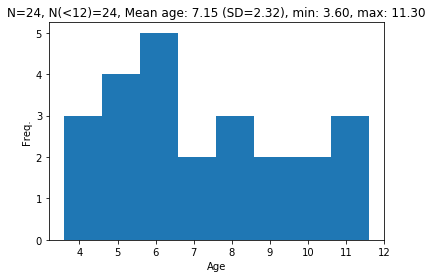

In [7]:
# Print the age
plt.figure()
temp_included_ages = df['Age']
plt.hist(temp_included_ages, np.arange(temp_included_ages.min(), temp_included_ages.max() + 1));
plt.xlabel('Age')
plt.ylabel('Freq.')

plt.title('N=%d, N(<12)=%d, Mean age: %0.2f (SD=%0.2f), min: %0.2f, max: %0.2f' % (len(temp_included_ages), np.sum(np.asarray(temp_included_ages) < 12), np.mean(temp_included_ages), np.std(temp_included_ages), np.min(temp_included_ages), np.max(temp_included_ages)))
plt.savefig(plot_dir + 'age_histogram.svg')


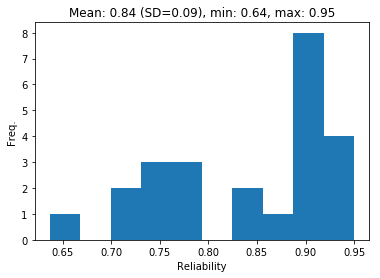

In [8]:
# Print the age
plt.figure()
reliability = df['Intraframe reliability']
plt.hist(reliability);
plt.xlabel('Reliability')
plt.ylabel('Freq.')
plt.title('Mean: %0.2f (SD=%0.2f), min: %0.2f, max: %0.2f' % (np.mean(reliability), np.std(reliability), np.min(reliability), np.max(reliability)));
plt.savefig(plot_dir + 'interrater_reliability.svg')

Text(0, 0.5, 'Trials per participant')

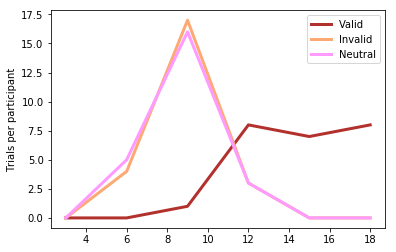

In [9]:
plt.figure()
bins = np.arange(0, 21, 3)
binned_data = np.histogram(df['Valid events'], bins);
plt.plot(binned_data[1][1:], binned_data[0], color=valid_color, linewidth=3)
binned_data = np.histogram(df['Invalid events'], bins);
plt.plot(binned_data[1][1:], binned_data[0], color=neutral_color, linewidth=3)
binned_data = np.histogram(df['Neutral events'], bins);
plt.plot(binned_data[1][1:], binned_data[0], color=invalid_color, linewidth=3)
plt.legend(['Valid', 'Invalid', 'Neutral'])
plt.ylabel('Participant count')
plt.ylabel('Trials per participant')


In [10]:
print('Mean valid events: %0.3f (SD=%0.3f), min=%d, max=%d' % (df['Valid events'].mean(), df['Valid events'].std(), df['Valid events'].min(), df['Valid events'].max()))
print('Mean neutral events: %0.3f (SD=%0.3f), min=%d, max=%d' % (df['Neutral events'].mean(), df['Neutral events'].std(), df['Neutral events'].min(), df['Neutral events'].max()))
print('Mean invalid events: %0.3f (SD=%0.3f), min=%d, max=%d' % (df['Invalid events'].mean(), df['Invalid events'].std(), df['Invalid events'].min(), df['Invalid events'].max()))


Mean valid events: 12.917 (SD=3.063), min=8, max=18
Mean neutral events: 6.708 (SD=1.488), min=4, max=10
Mean invalid events: 6.625 (SD=1.469), min=4, max=10


## Behavioral analysis

Participants completed up to 4 blocks (36 trials) with each block containing 4 valid trials, 2 invalid trials and 2 neutral trials. A fixation is presented at the start of the trial until triggered and then ends when the next TR comes in, cue duration is 100ms, cue-target ISI is 100ms, target presence is 2s. The event onset for analysis starts when the cue appears until it disappears (2.2s). The fixation duration between events is typically 1-4s but can be much longer.

Data was excluded from the GLM analyses if their eyes were closed during the cue. Data from the remaining trials were excluded from the analysis of eye tracking if they never looked at the target. Of the responses where they did look at the target, any response times less than 0ms were excluded (e.g., looking at the target location before the target onset) and also when they were longer than 1000ms were excluded. 

**Load in participant data**

In [11]:
# Load in the data for each participant
PooledRT = {}

for ppt_id in df['ID']:
    
    with open(data_dir + 'RT_data/%s.pkl' % ppt_id, 'rb') as handle:
        PooledRT[ppt_id] = pickle.load(handle)

**Analyze the behavioral data for each participant**  

Performs numerous tests of the data. Including correlating reaction time with age, comparing the difference between conditions and pooling data across participants

Note, that the condition names reported for the test statistics are such that the second condition is subtracted from the first. So 'invalid_valid' means that the RT for invalid minus the RT for valid trials

s8687_1_3 has 25 trials
s6687_1_3 has 35 trials
s4607_1_3 has 21 trials
s3607_1_2 has 28 trials
s9057_1_1 has 18 trials
s6057_1_1 has 22 trials
s0057_1_1 has 34 trials
s0057_1_2 has 21 trials
s1057_1_2 has 22 trials
s1057_1_3 has 30 trials
s7017_1_4 has 29 trials
s3017_1_1 has 22 trials
s2037_1_1 has 30 trials
s2037_1_2 has 37 trials
s7037_1_1 has 21 trials
s5037_1_1 has 34 trials
s6067_1_1 has 21 trials
s7067_1_2 has 29 trials
s8047_1_1 has 27 trials
s2687_1_2 has 28 trials
s6607_1_1 has 27 trials
s3687_1_2 has 20 trials
s4607_1_2 has 26 trials
s1607_1_1 has 23 trials
Age x Valid RT: r = -0.59, p = 0.000
Age x overall RT: r = -0.63, p = 0.000


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Summary
invalid_valid  24/24 participants, M=0.19, CI=[0.16, 0.22], p=0.000


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Summary
neutral_valid  23/24 participants, M=0.13, CI=[0.10, 0.16], p=0.000


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Summary
invalid_neutral  21/24 participants, M=0.06, CI=[0.03, 0.09], p=0.000


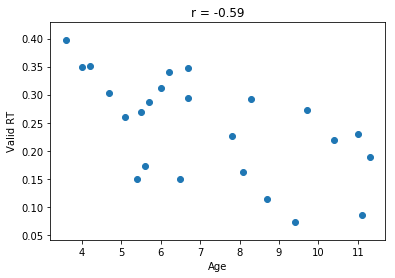

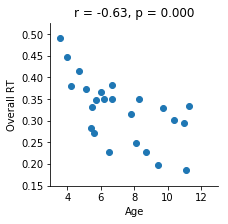

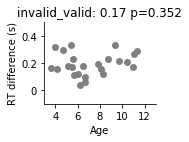

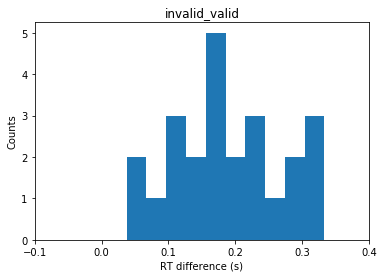

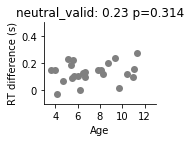

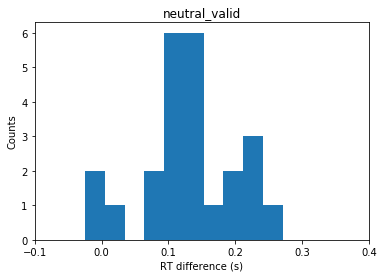

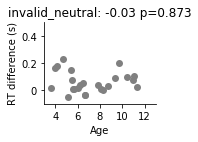

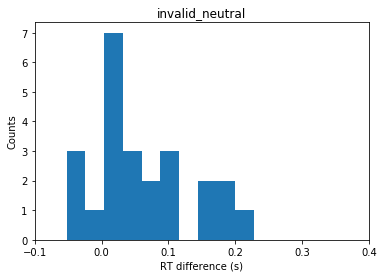

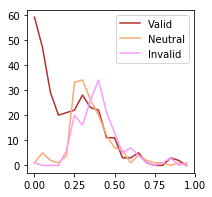

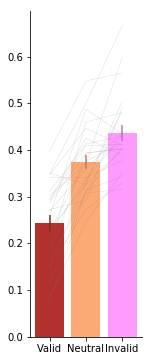

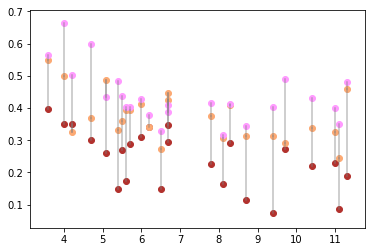

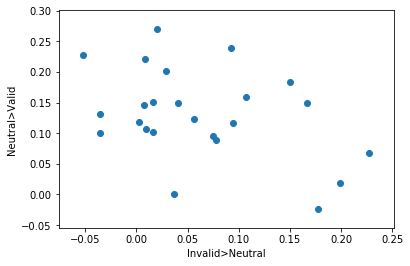

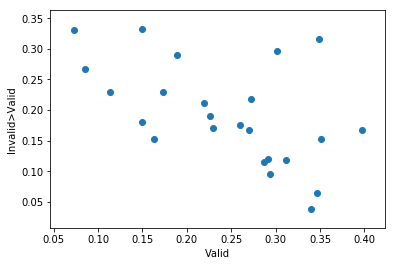

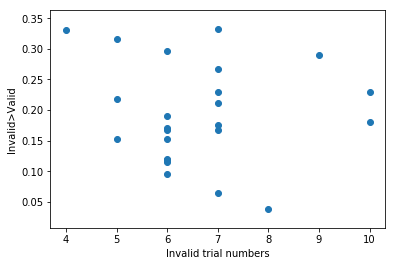

In [12]:
# Analyze the cuing effect
diff_data = analyze_RT_data(PooledRT, df['Age'], 'Exogenous', fig_dir=plot_dir)

**Do the behavioral analysis only using the first block of data**

s8687_1_3 has 5 trials
s6687_1_3 has 8 trials
s4607_1_3 has 7 trials
s3607_1_2 has 8 trials
s9057_1_1 has 6 trials
s6057_1_1 has 4 trials
s0057_1_1 has 8 trials
s0057_1_2 has 8 trials
s1057_1_2 has 8 trials
s1057_1_3 has 7 trials
s7017_1_4 has 7 trials
s3017_1_1 has 8 trials
s2037_1_1 has 7 trials
s2037_1_2 has 8 trials
s7037_1_1 has 7 trials
s5037_1_1 has 7 trials
s6067_1_1 has 6 trials
s7067_1_2 has 6 trials
s8047_1_1 has 7 trials
s2687_1_2 has 8 trials
s6607_1_1 has 6 trials
s3687_1_2 has 6 trials
s4607_1_2 has 7 trials
s1607_1_1 has 8 trials


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Age x Valid RT: r = -0.39, p = 0.013
Age x overall RT: r = -0.47, p = 0.005


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Summary
invalid_valid  18/23 participants, M=0.13, CI=[0.06, 0.19], p=0.000


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=uns


Summary
neutral_valid  15/24 participants, M=0.05, CI=[0.00, 0.10], p=0.049


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))



Summary
invalid_neutral  15/23 participants, M=0.08, CI=[0.03, 0.13], p=0.002


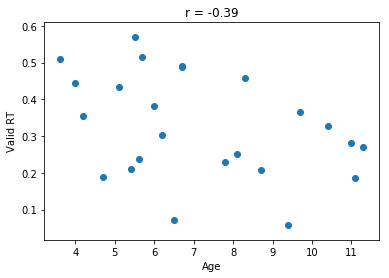

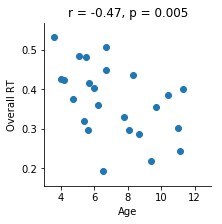

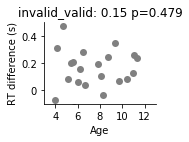

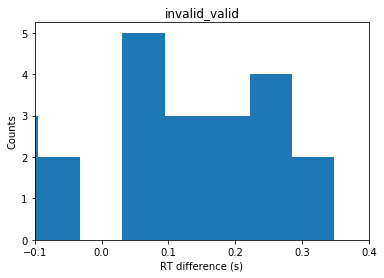

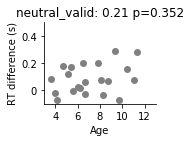

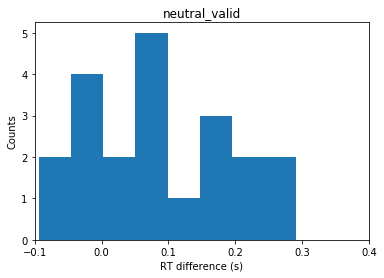

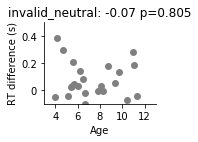

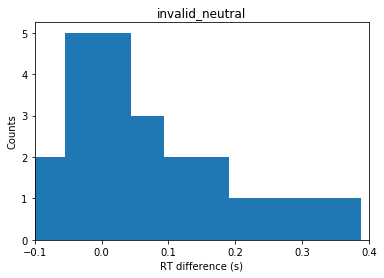

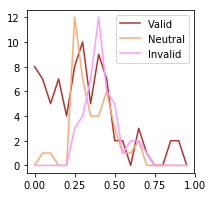

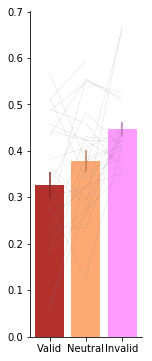

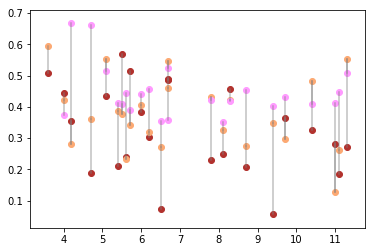

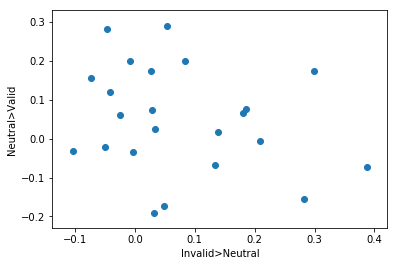

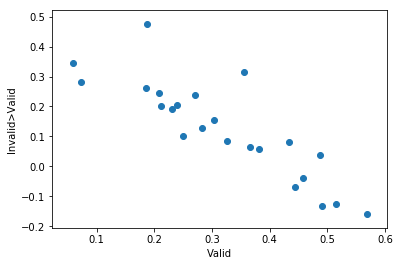

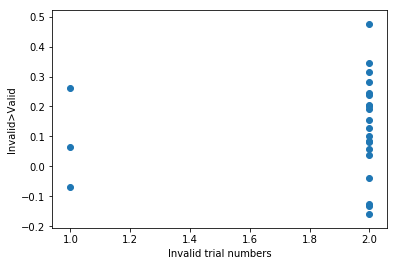

In [13]:
# Load in the data for each participant
PooledRT_first_block = {}

for ppt_id in df['ID']:
    
    with open(data_dir + 'RT_data/%s_first_block.pkl' % ppt_id, 'rb') as handle:
        PooledRT_first_block[ppt_id] = pickle.load(handle)

# Analyze the cuing effect
_ = analyze_RT_data(PooledRT_first_block, df['Age'], 'Exogenous', fig_dir=plot_dir + 'first_block_')

**Quantify how many saccades there are per conditions**
This analysis takes usable trials and finds the number of saccades that happen after the target appears for each trial type

In [14]:
quantify_saccades()

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:258: RuntimeWarning: invalid value encountered in greater
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average switches on valid trials: 1.75
Average switches on neutral trials: 1.84
Average switches on invalid trials: 2.10
Invalid>Valid: CI=[0.20, 0.50], p=0.000
Neutral>Valid: CI=[-0.06, 0.25], p=0.244
Invalid>Neutral: CI=[0.10, 0.42], p=0.001


**Plot the trialwise saccade behavior for included trials**
Blue lines are the coded locations (breaks occur when they move eyes away). Red lines bracket the cue onset, green lines bracket the target onset. The title of each subplot explain the trial time.

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


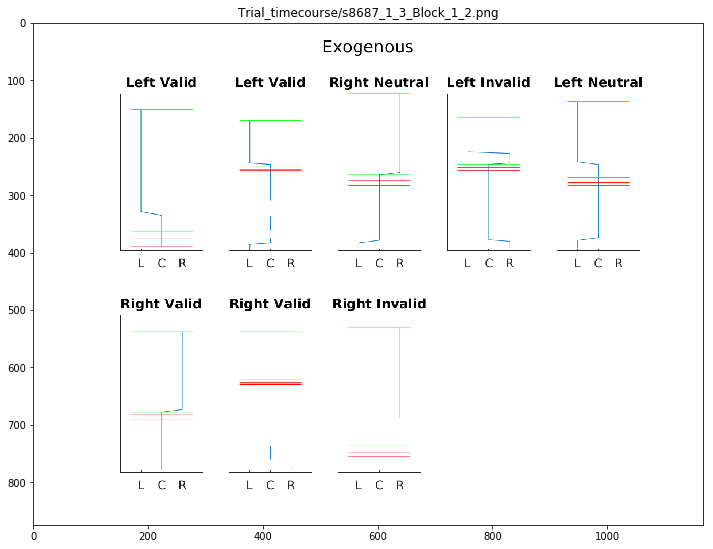

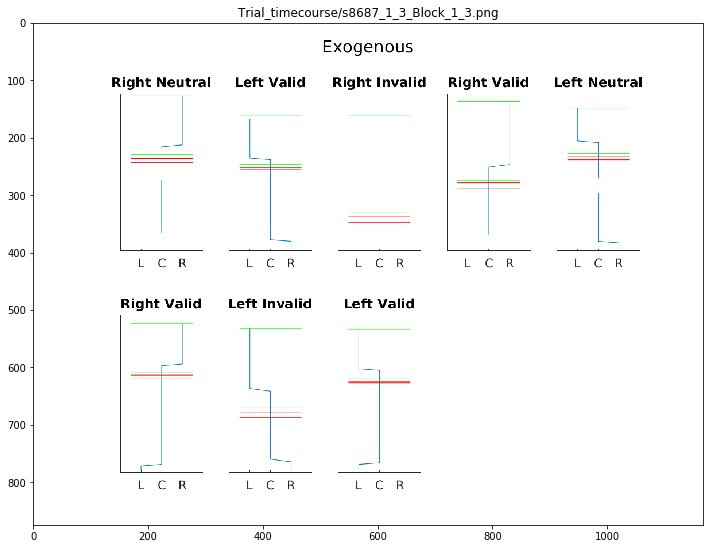

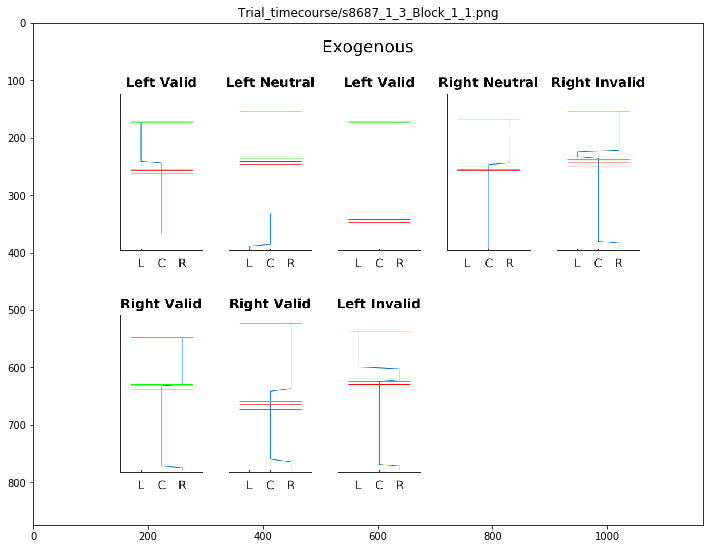

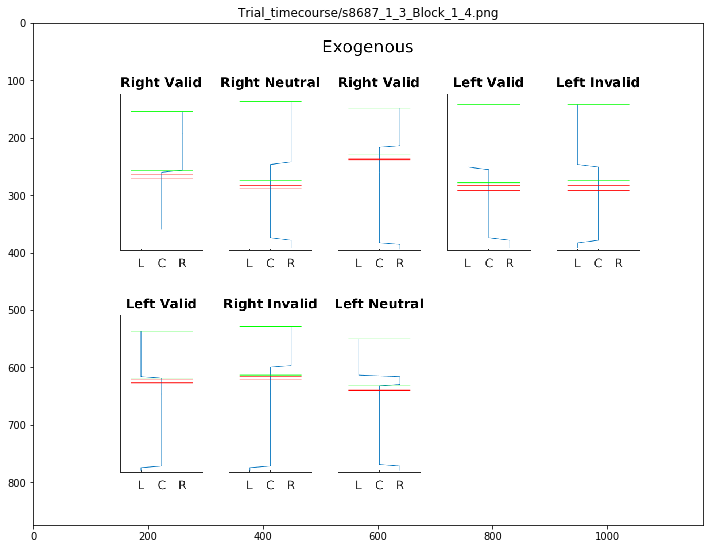

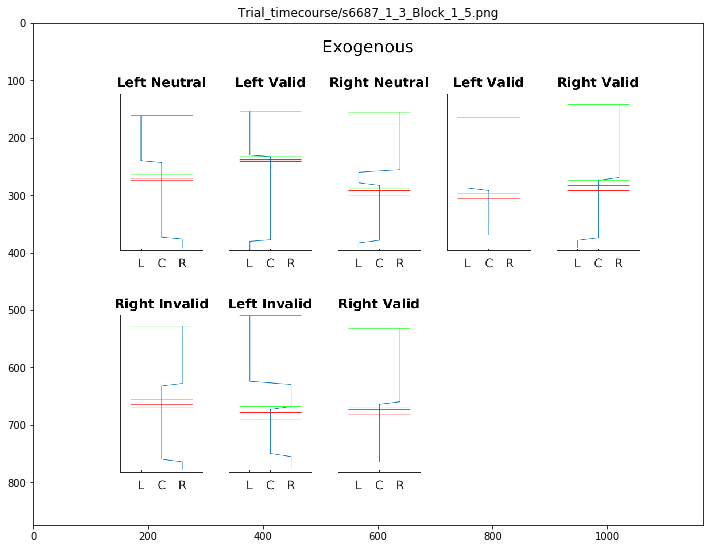

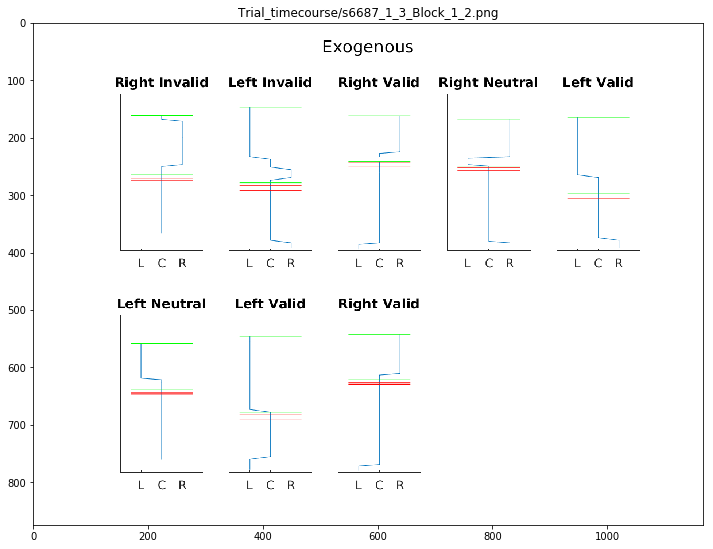

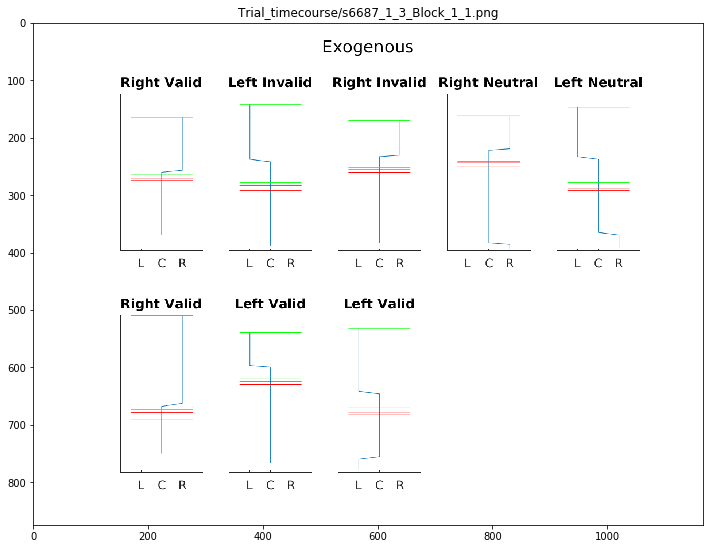

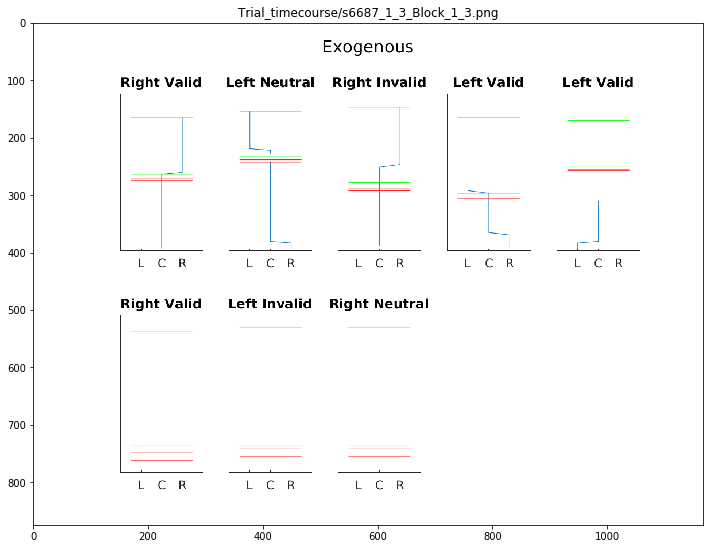

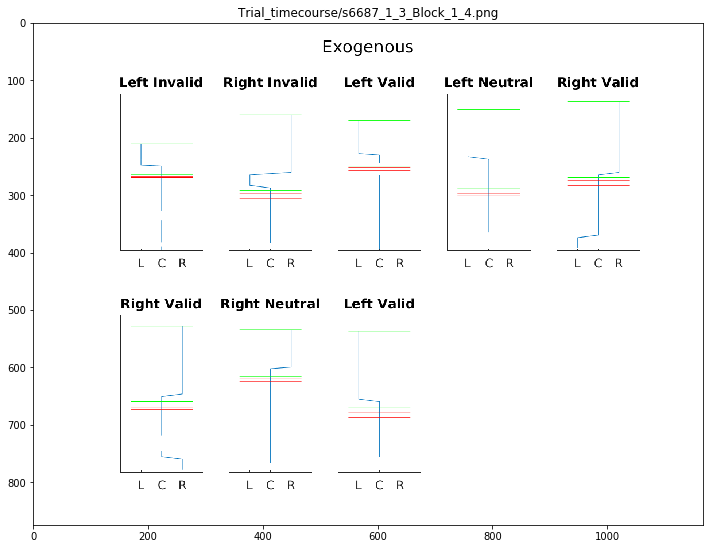

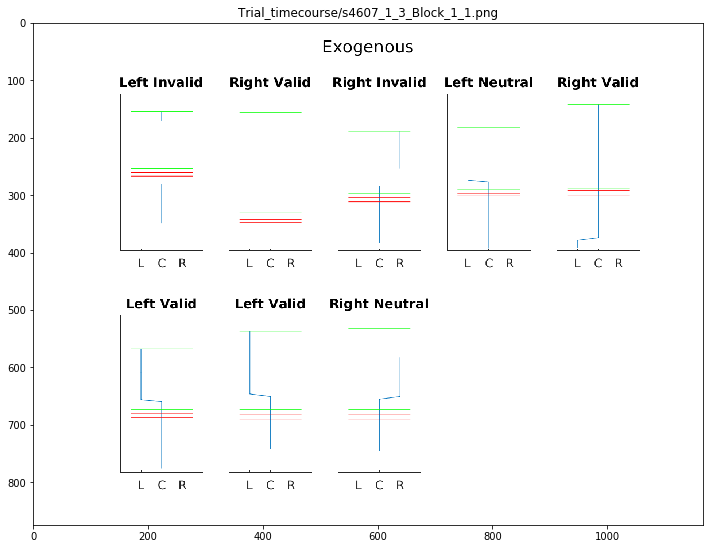

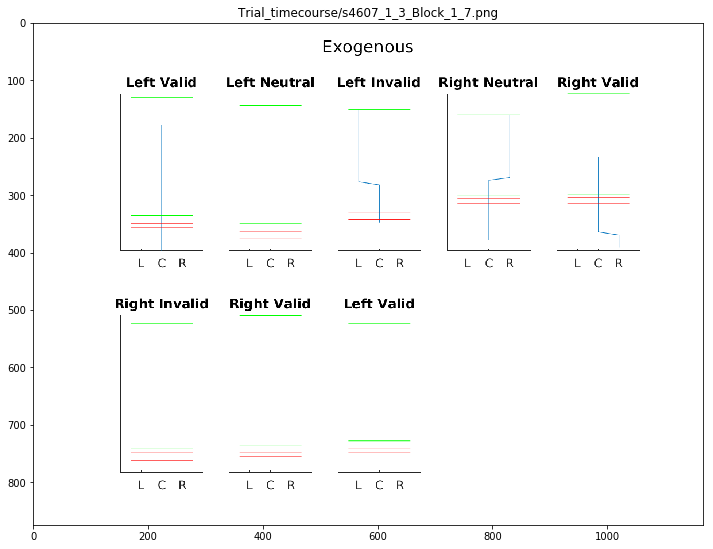

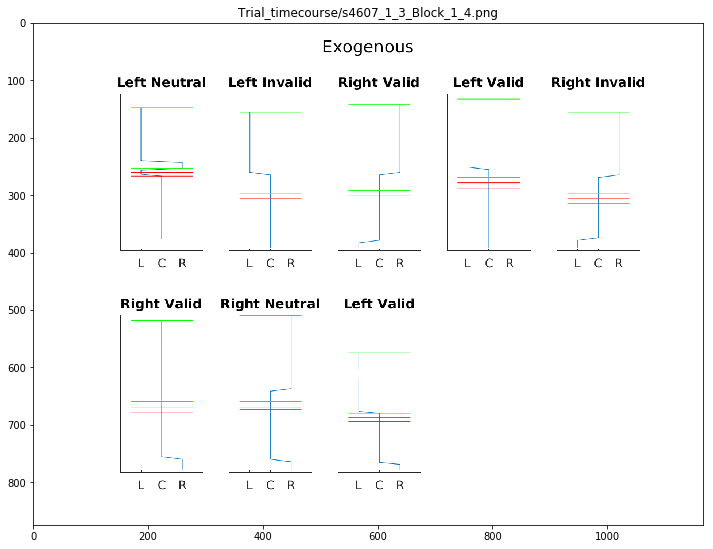

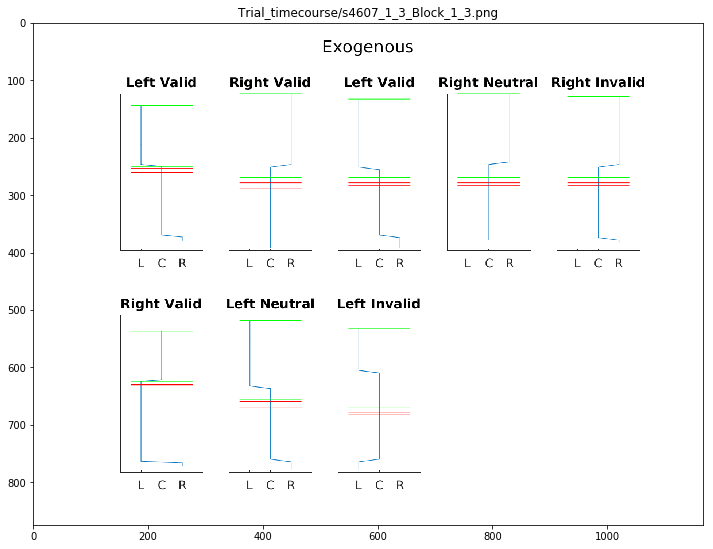

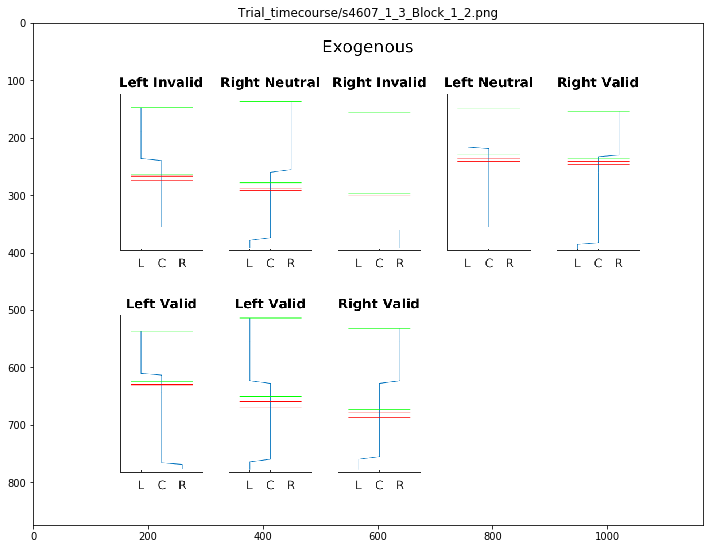

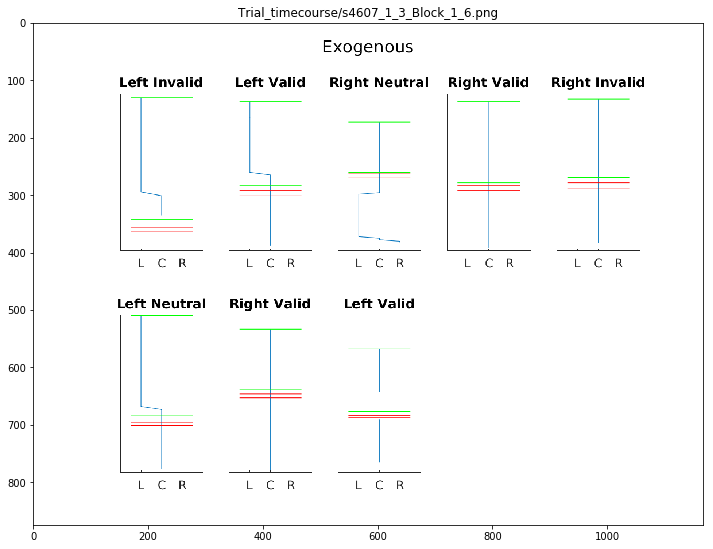

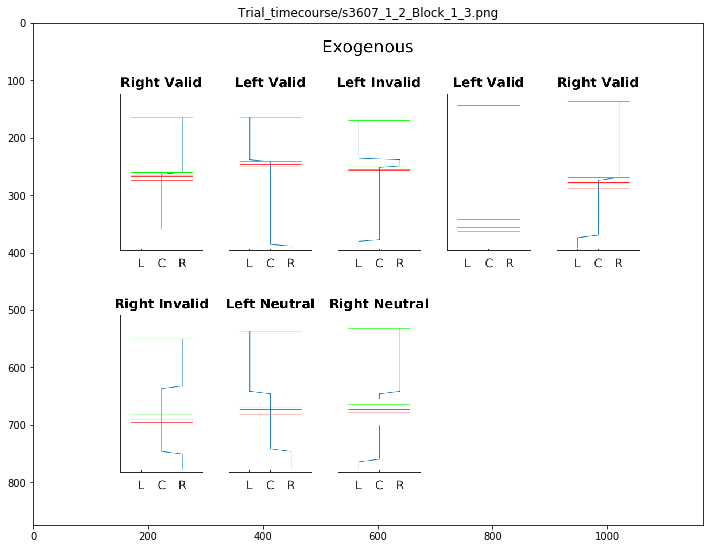

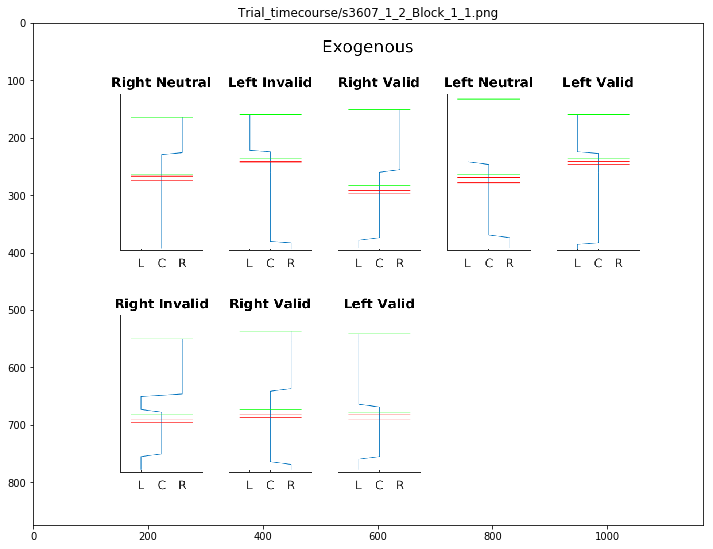

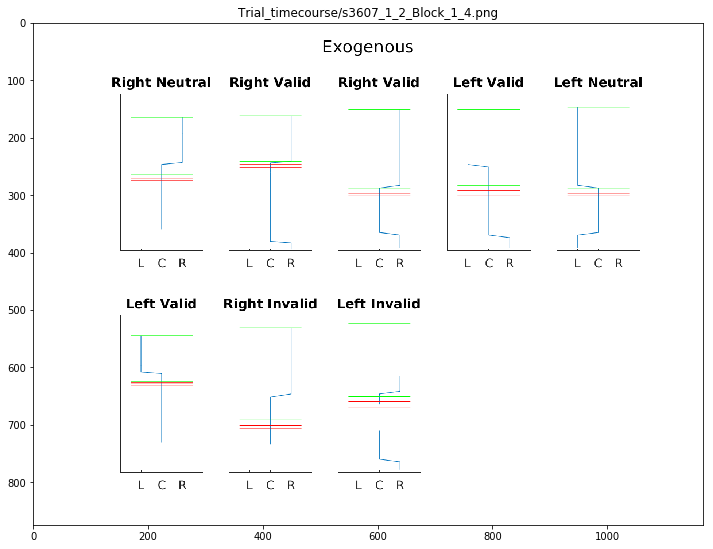

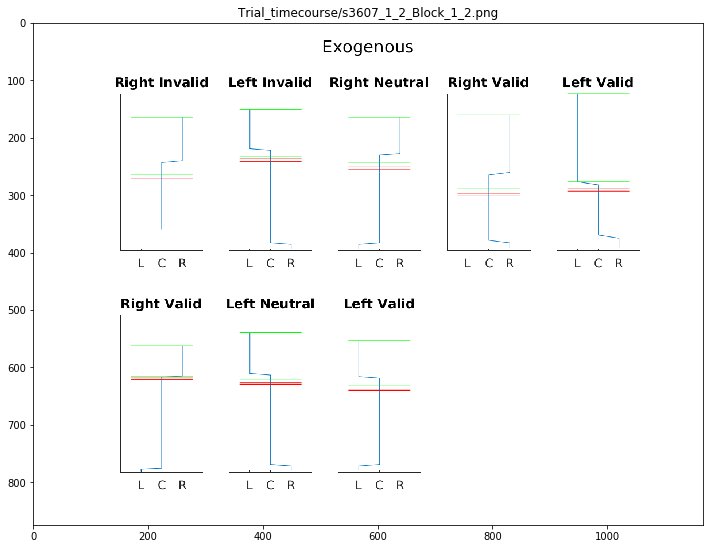

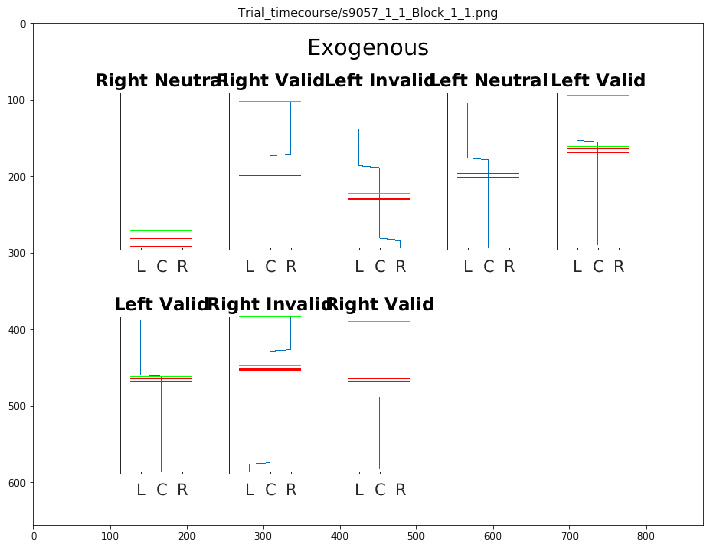

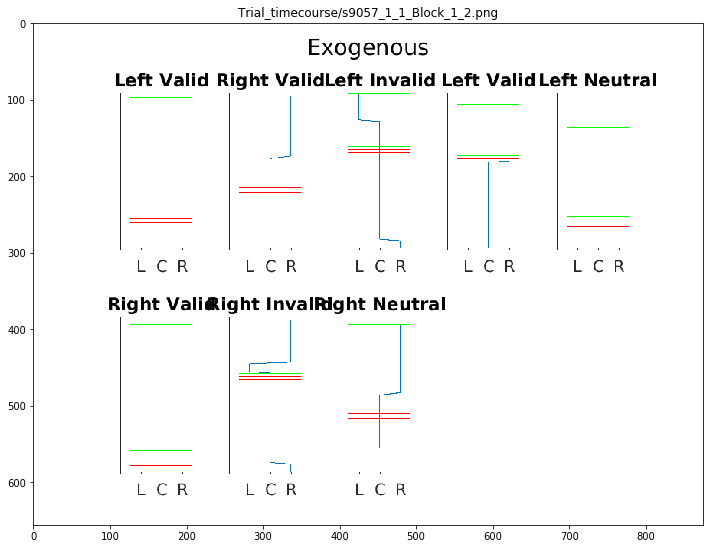

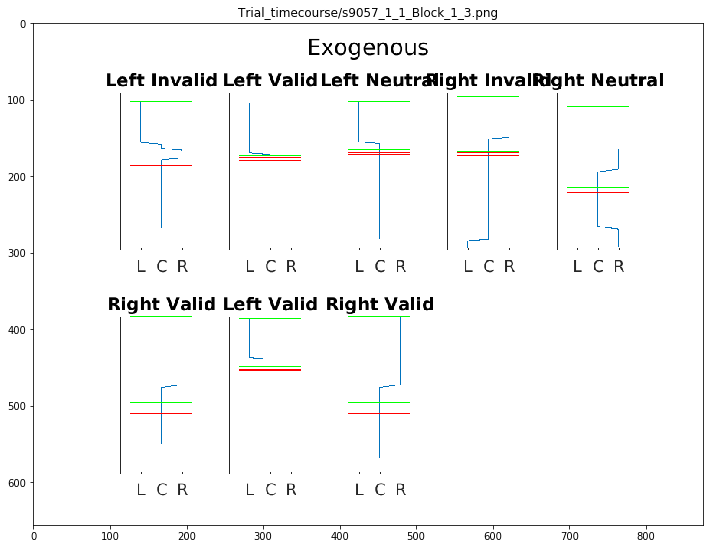

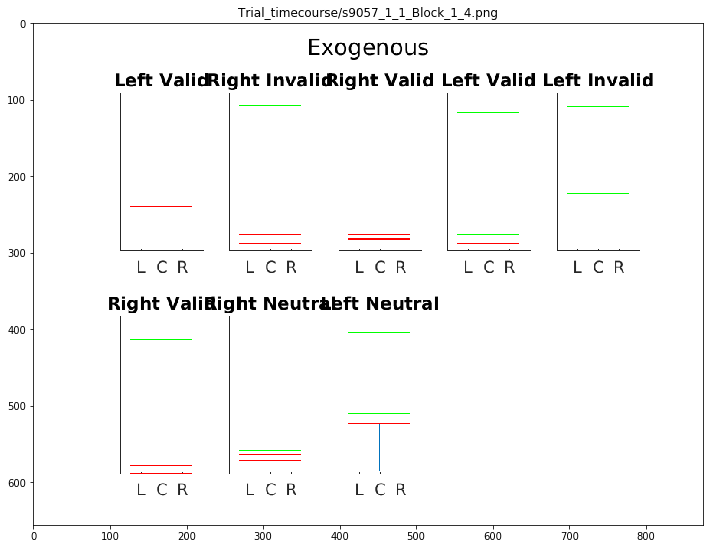

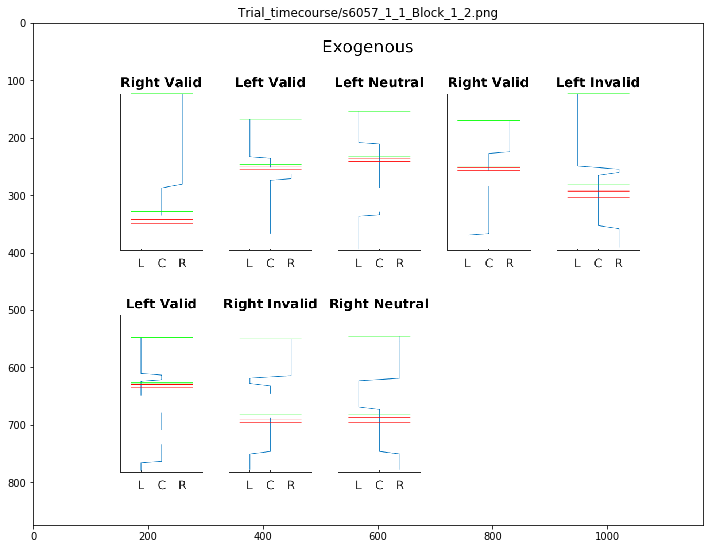

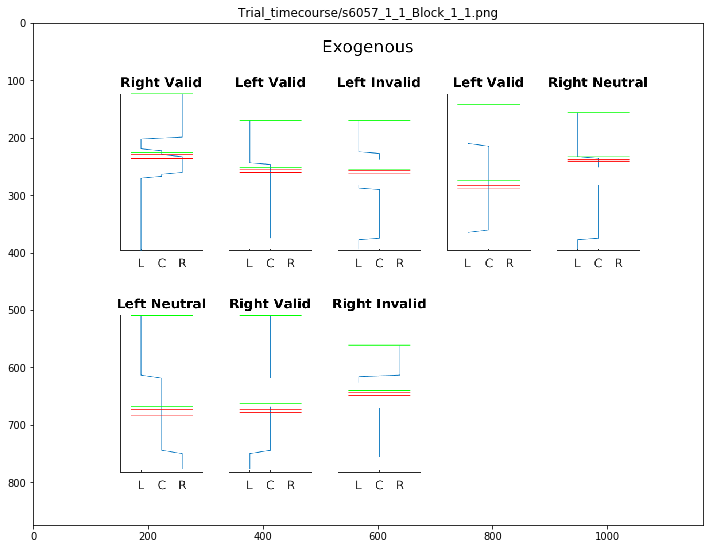

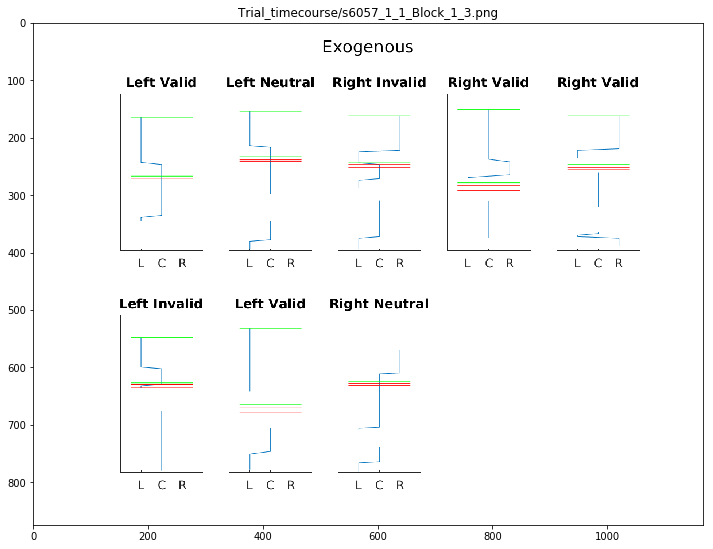

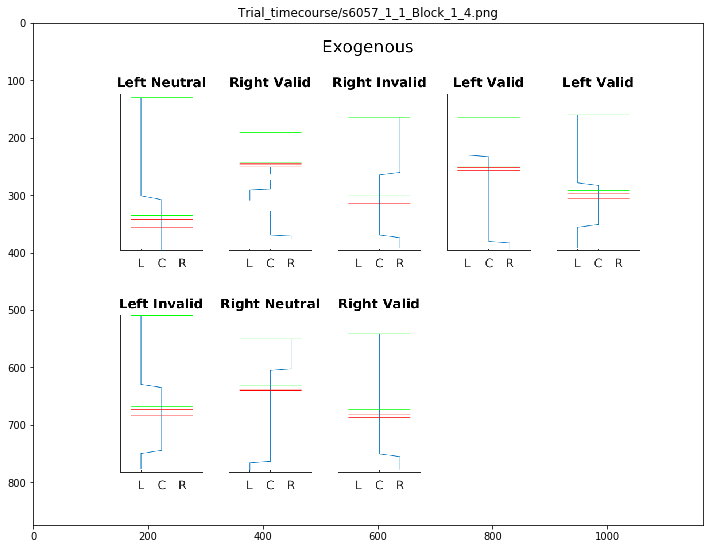

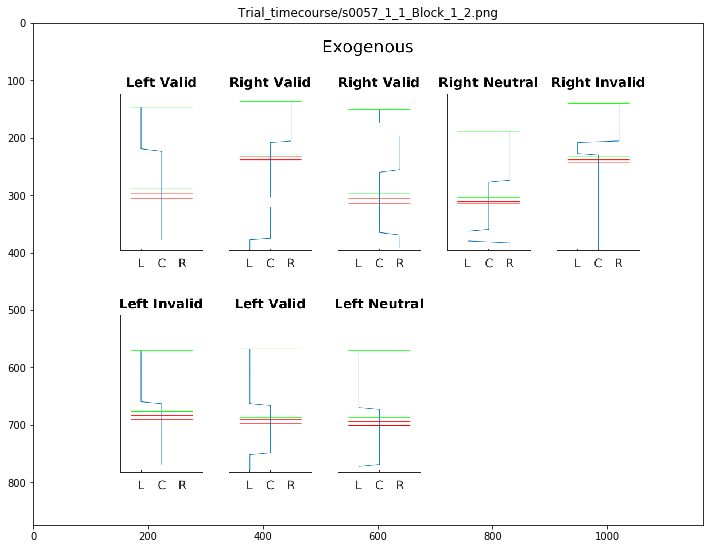

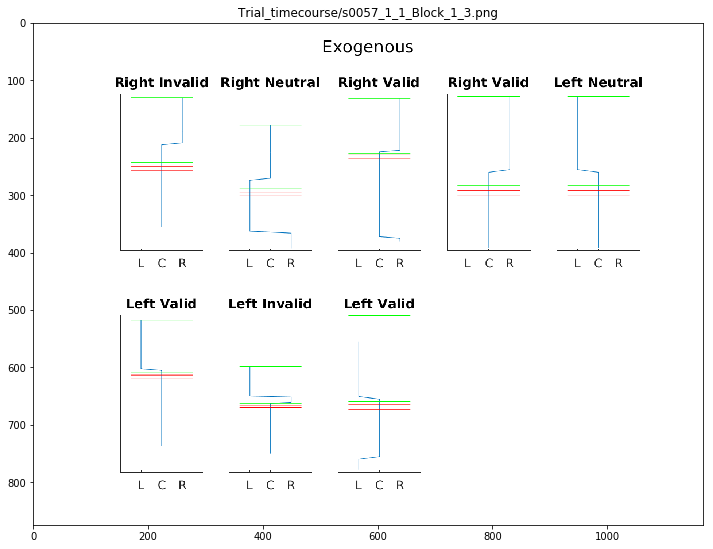

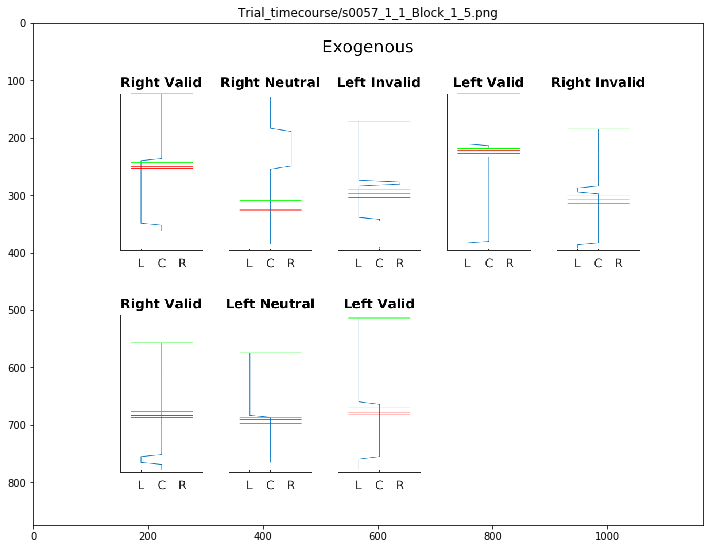

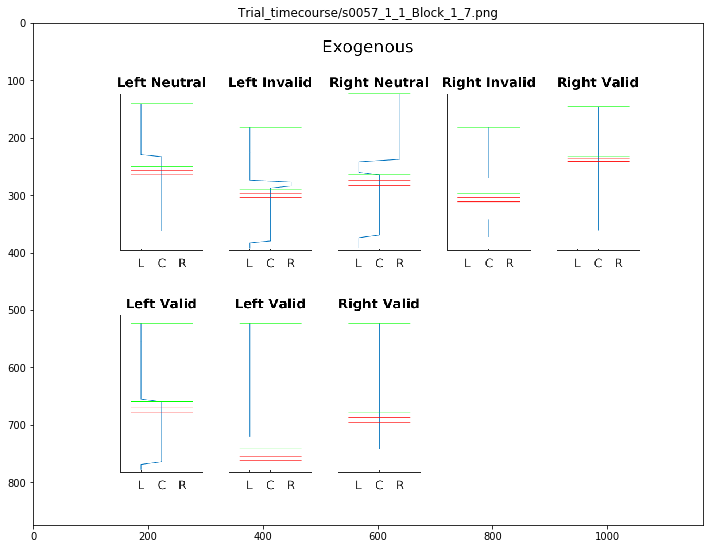

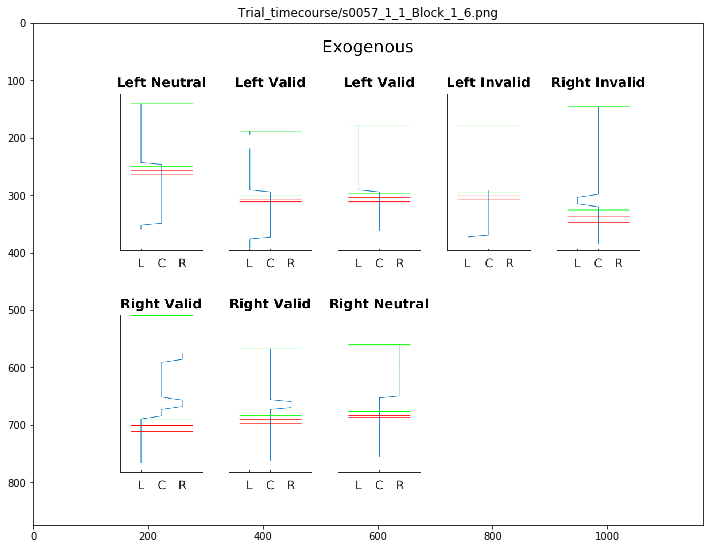

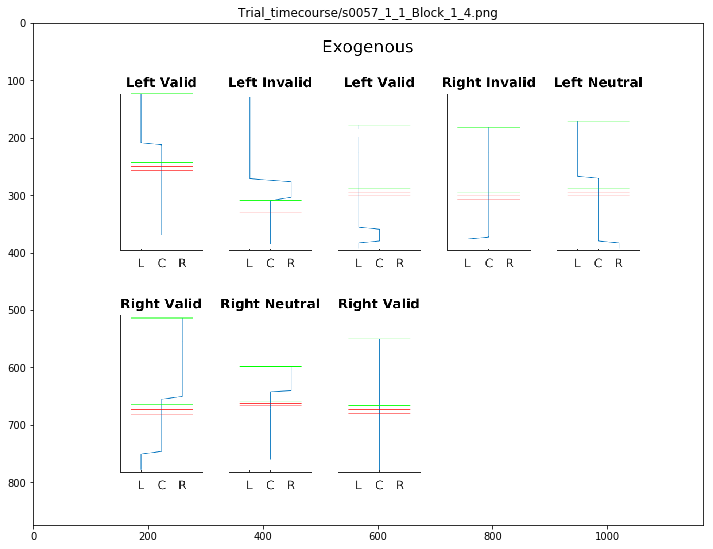

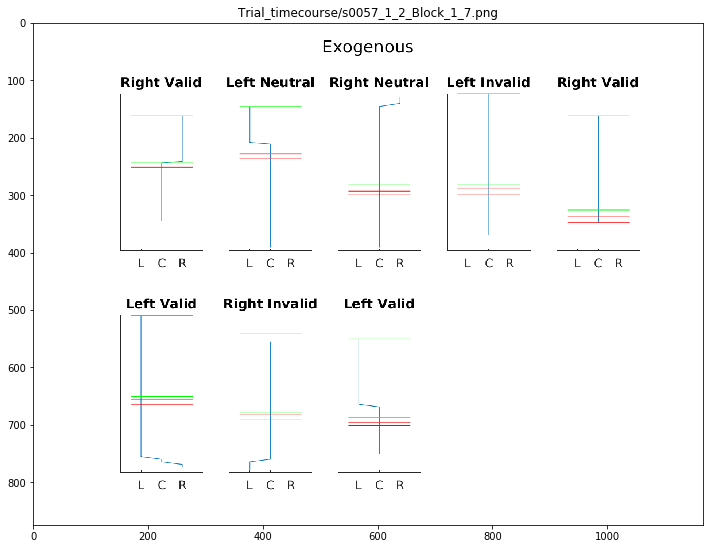

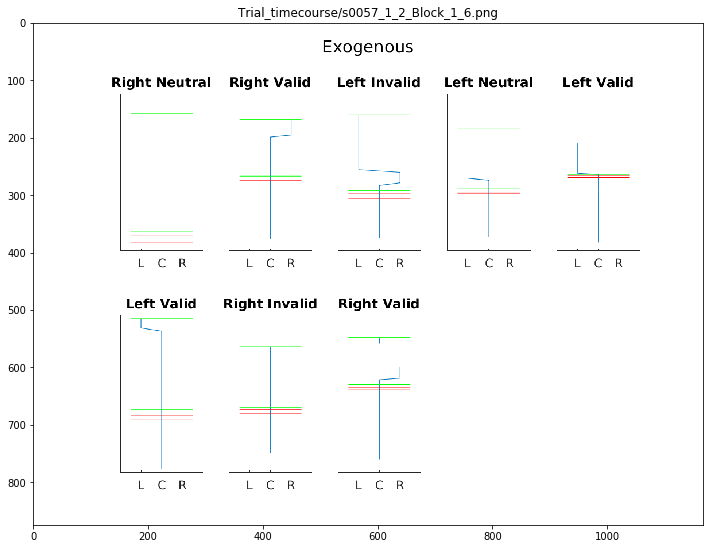

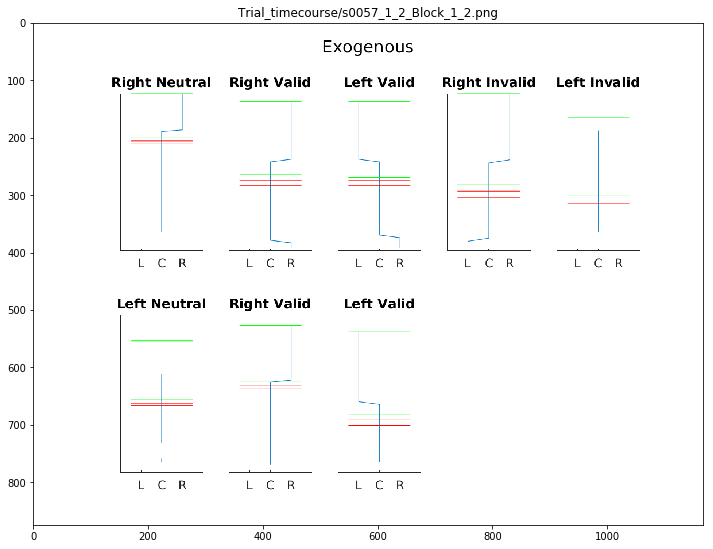

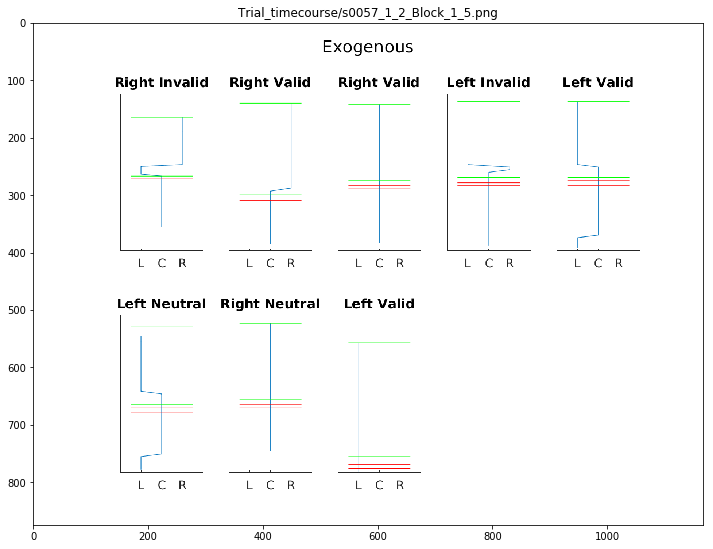

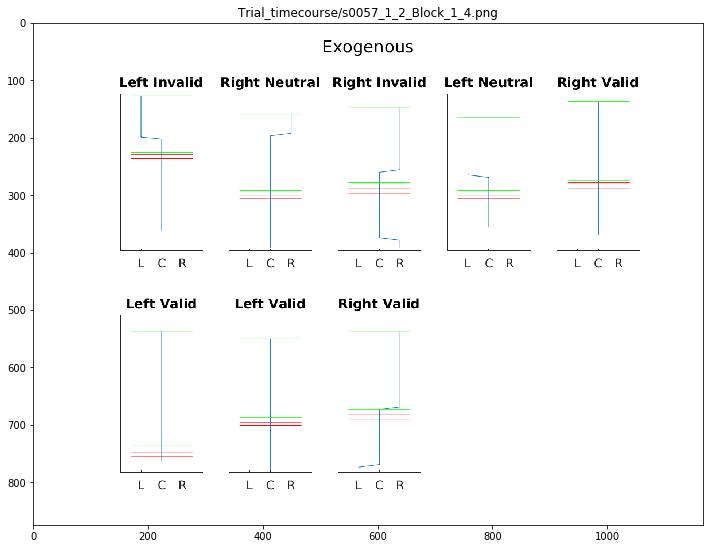

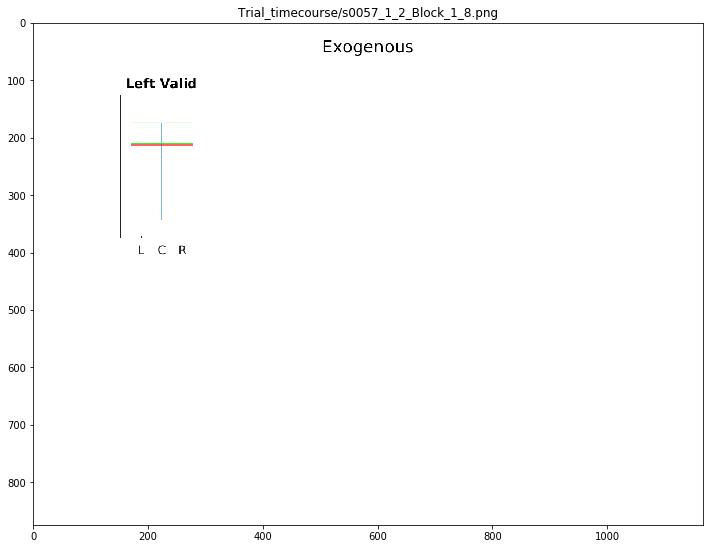

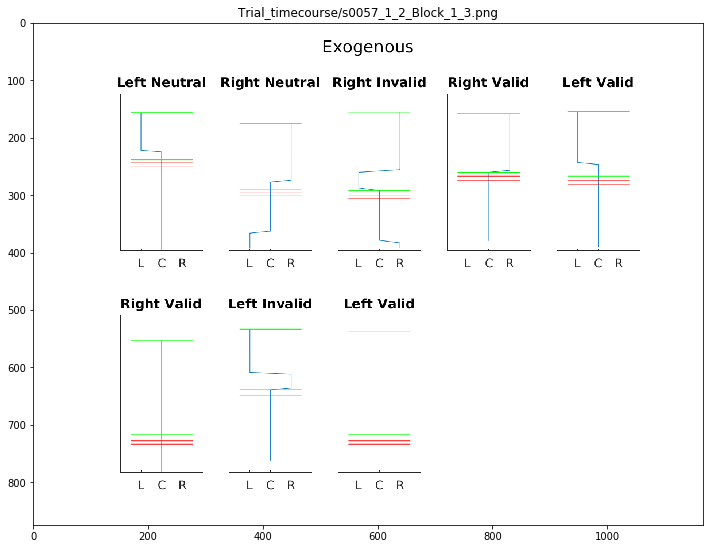

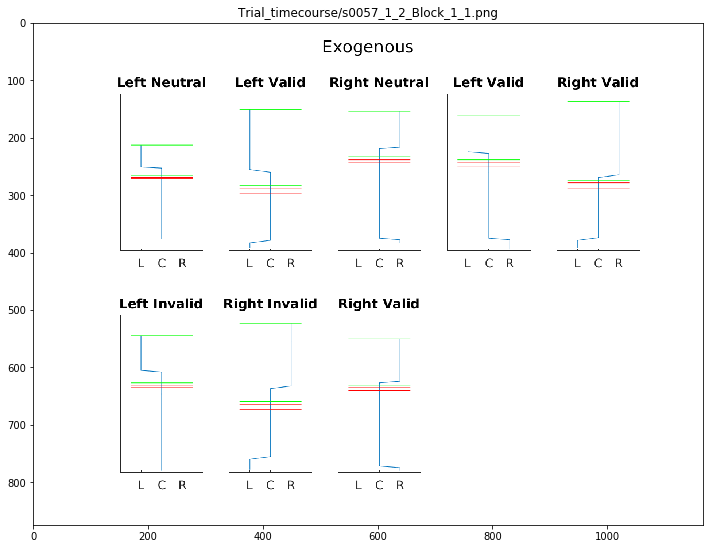

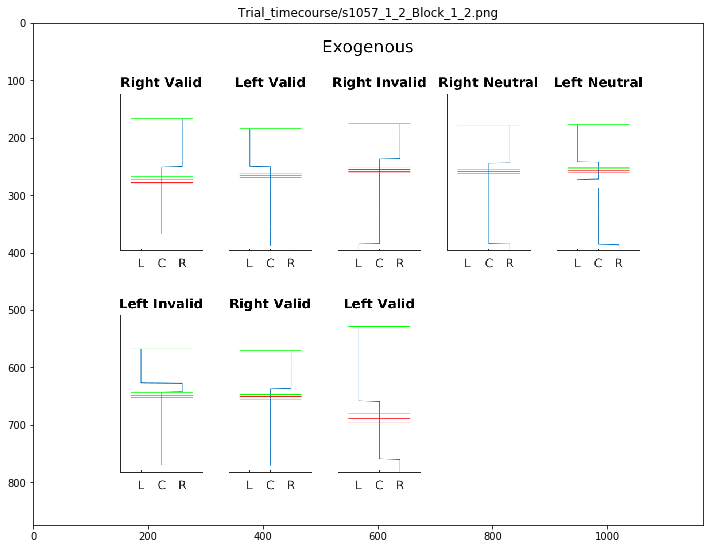

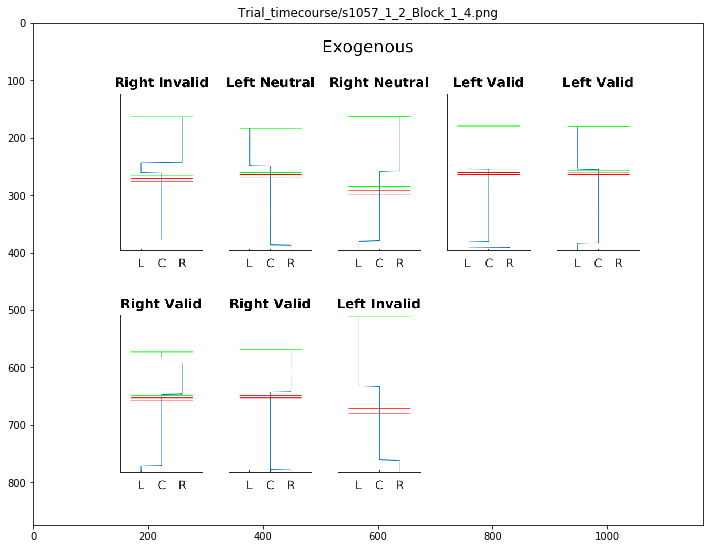

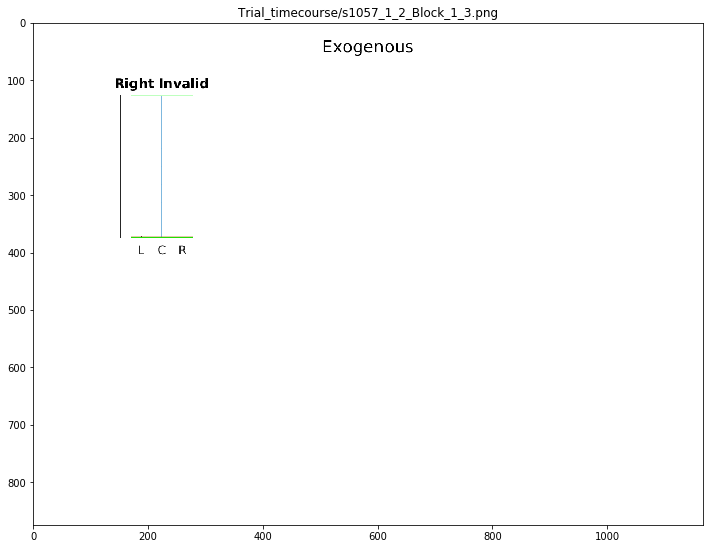

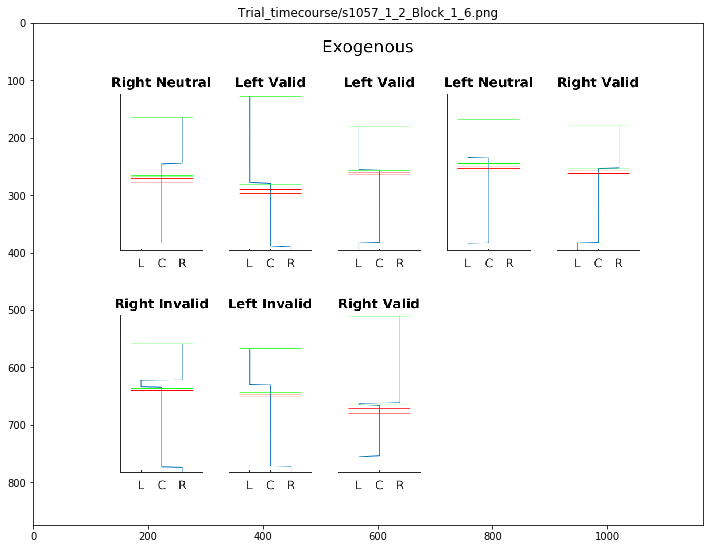

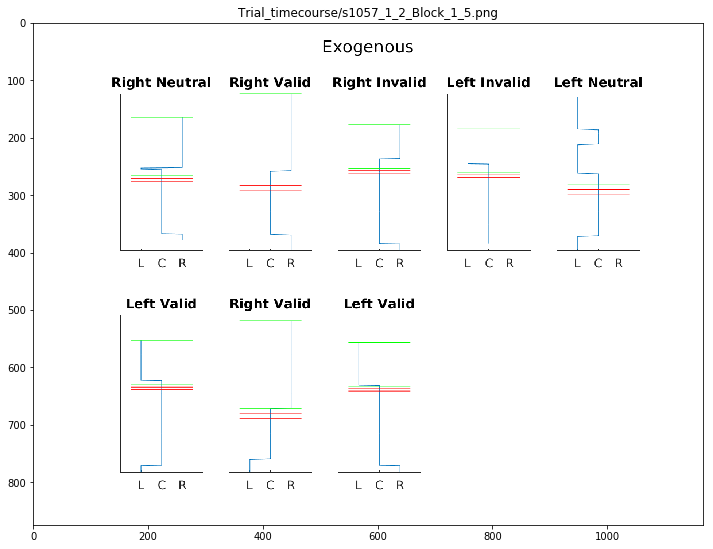

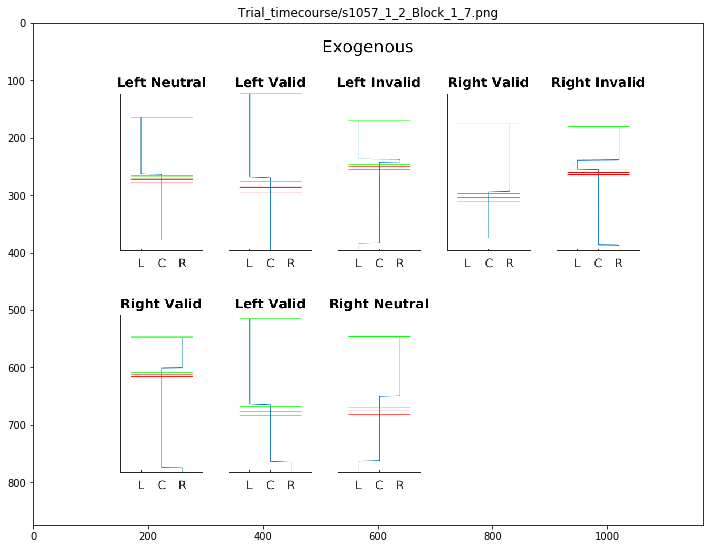

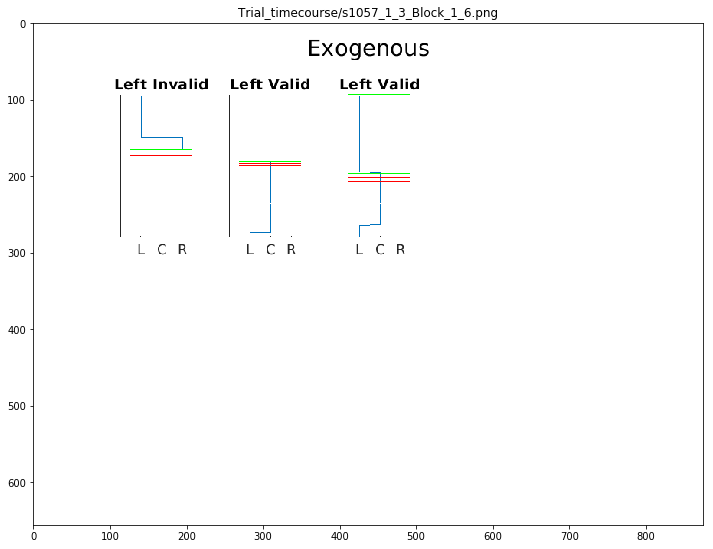

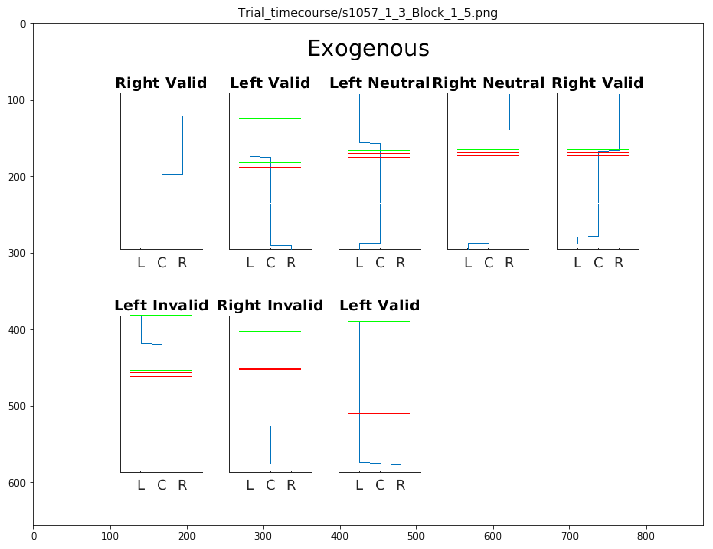

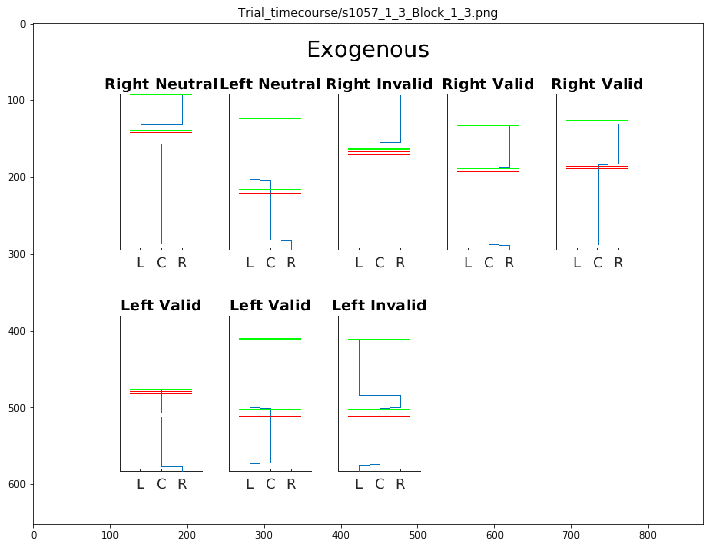

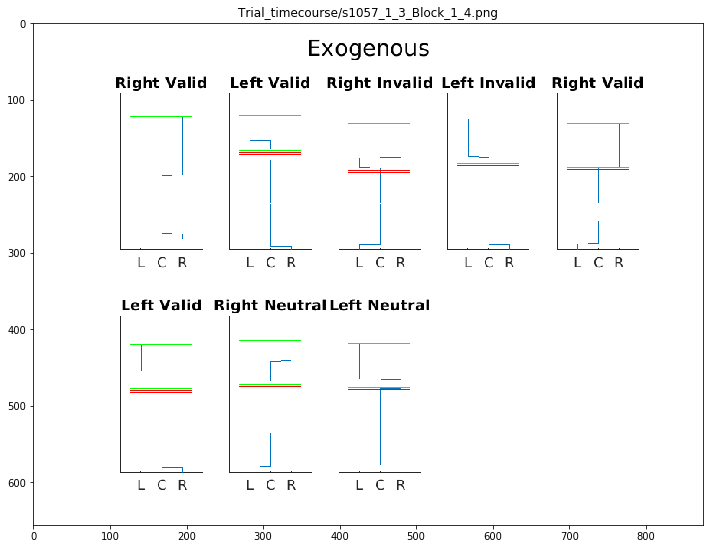

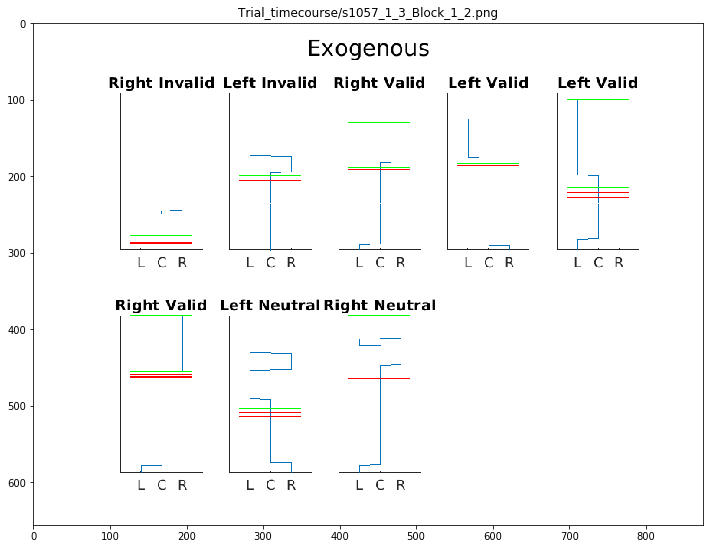

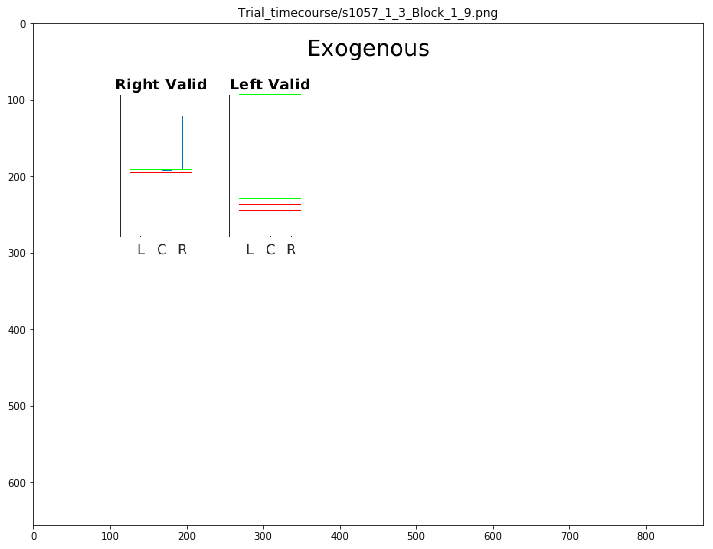

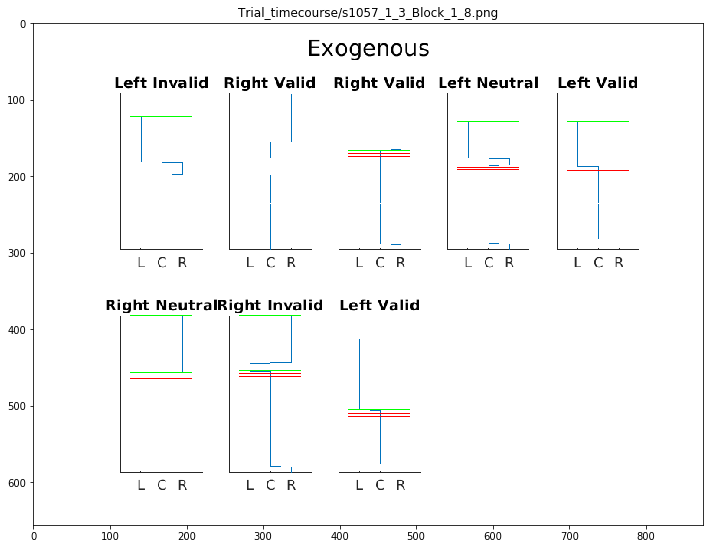

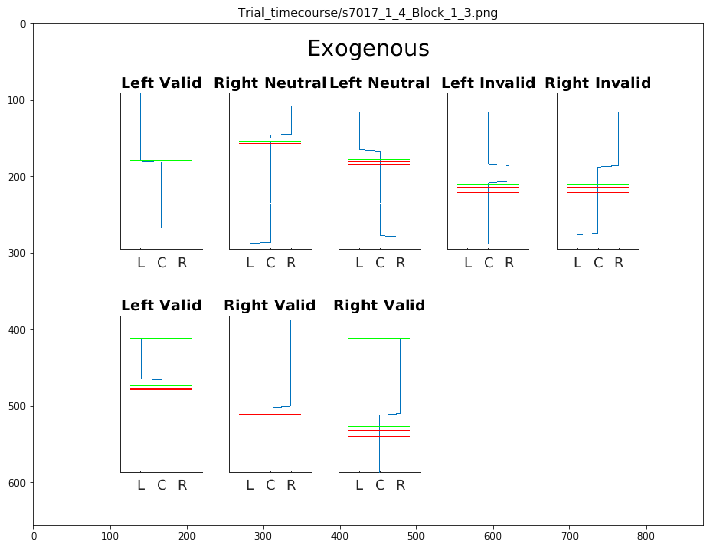

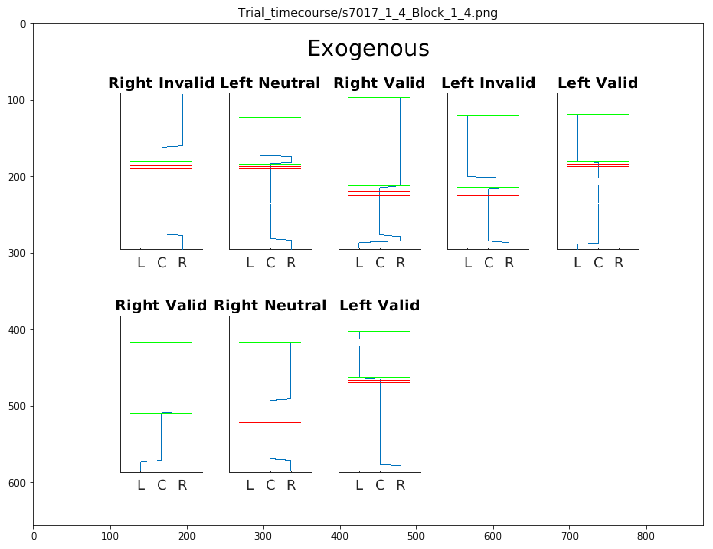

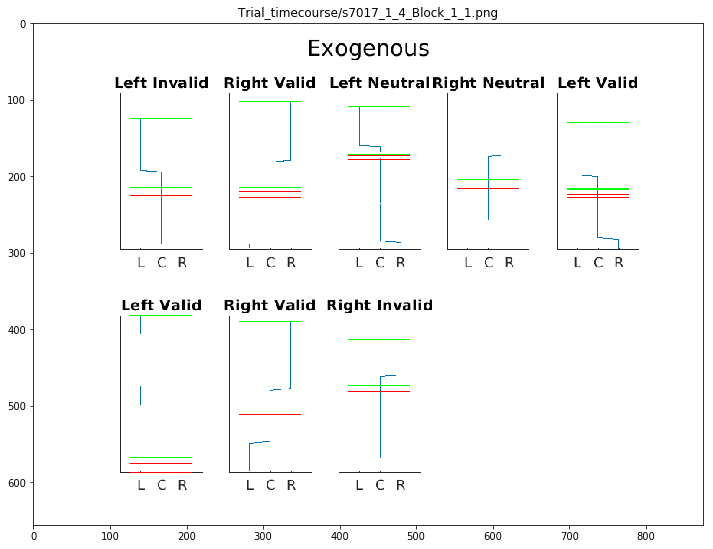

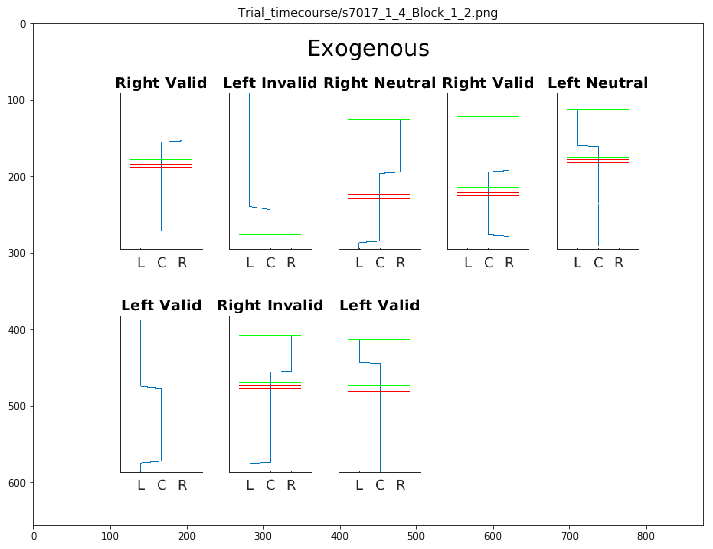

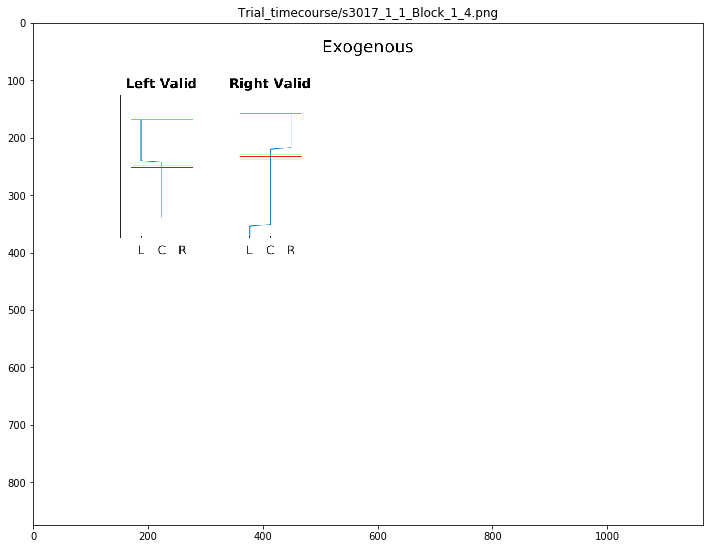

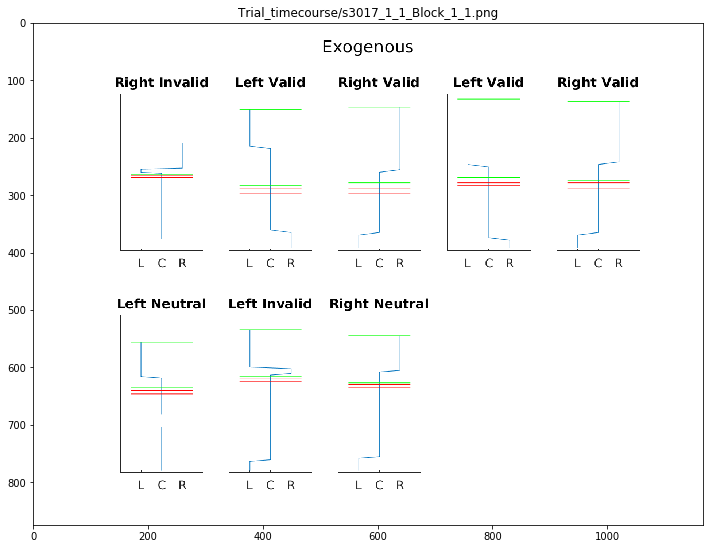

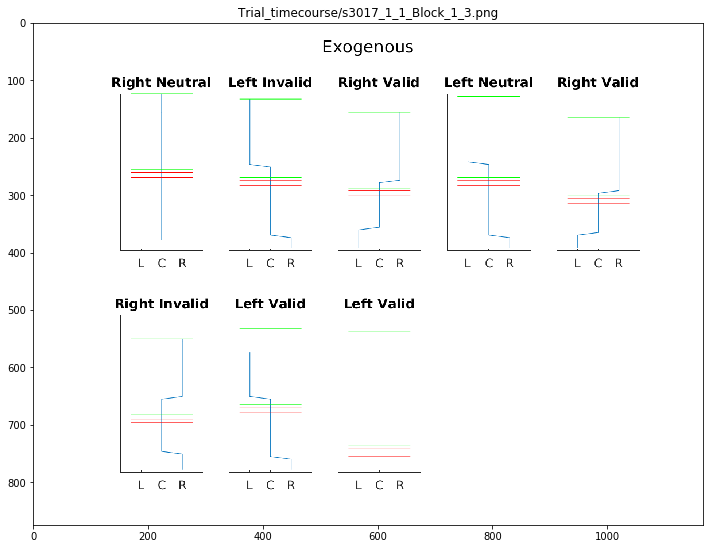

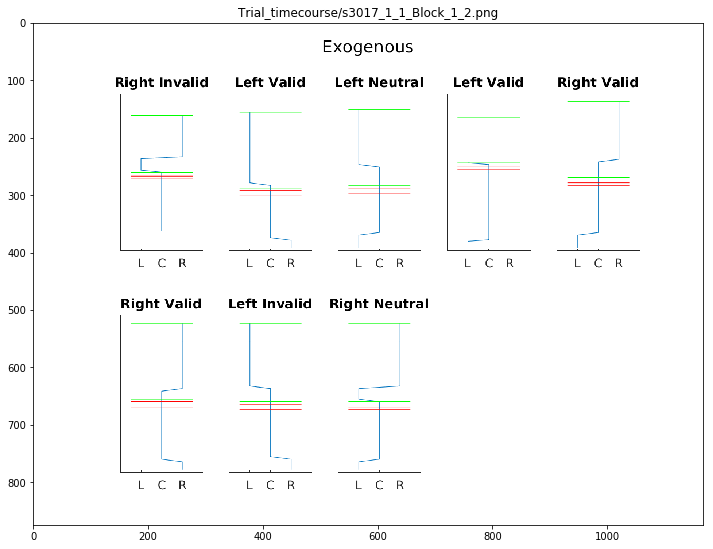

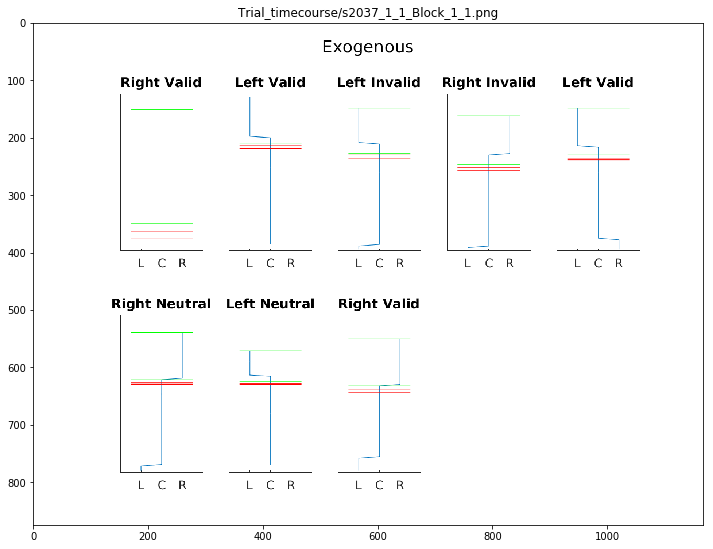

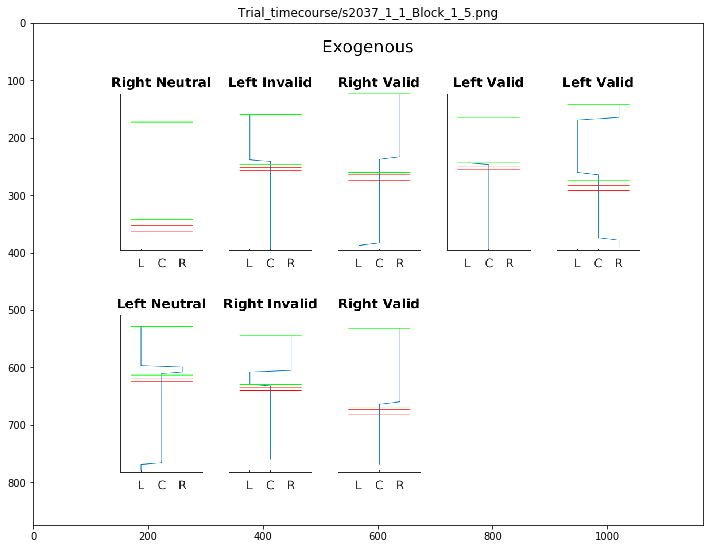

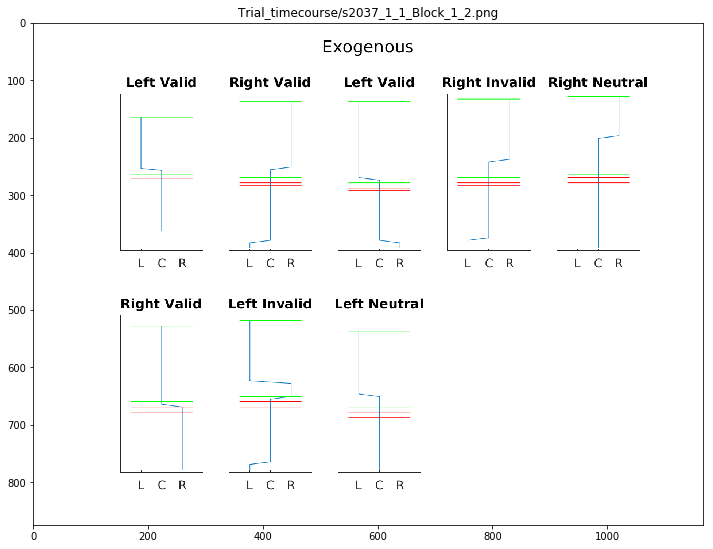

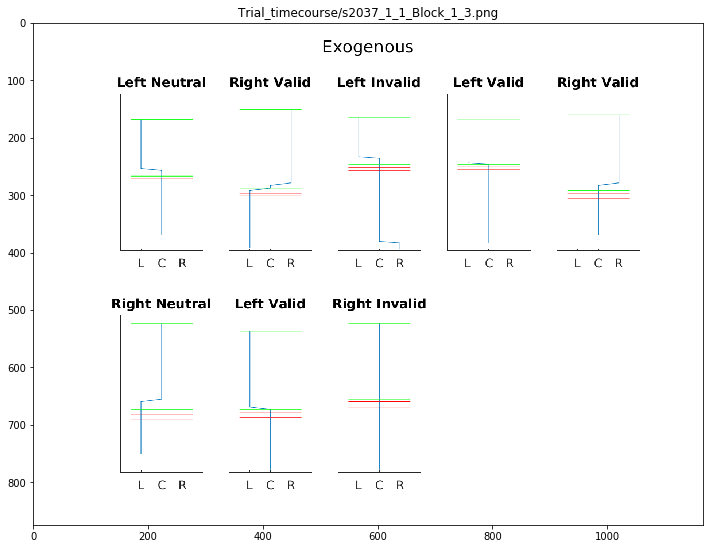

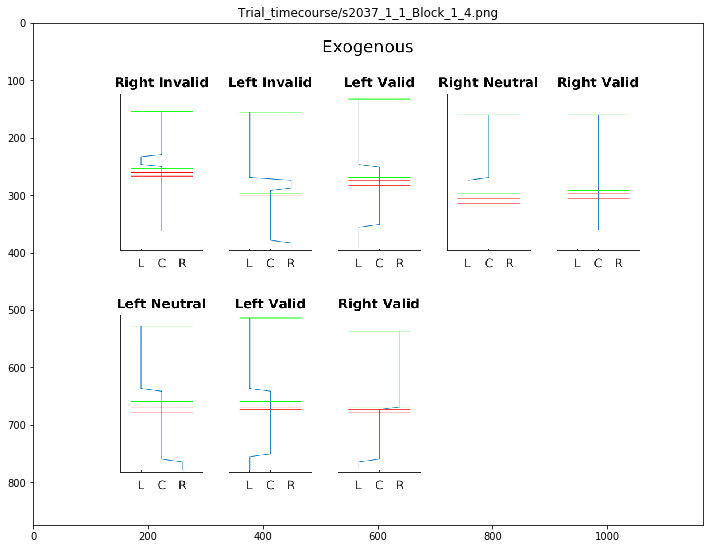

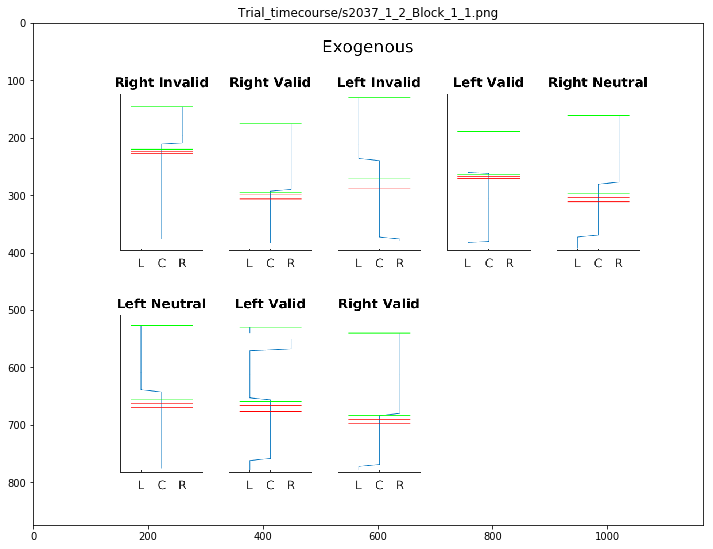

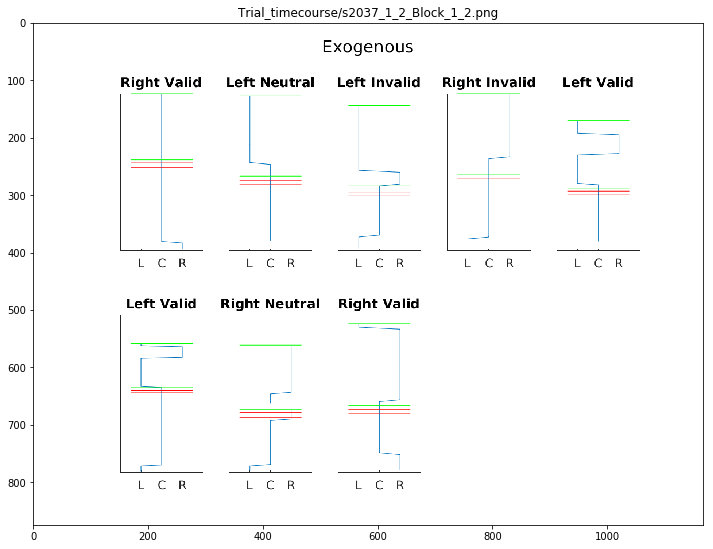

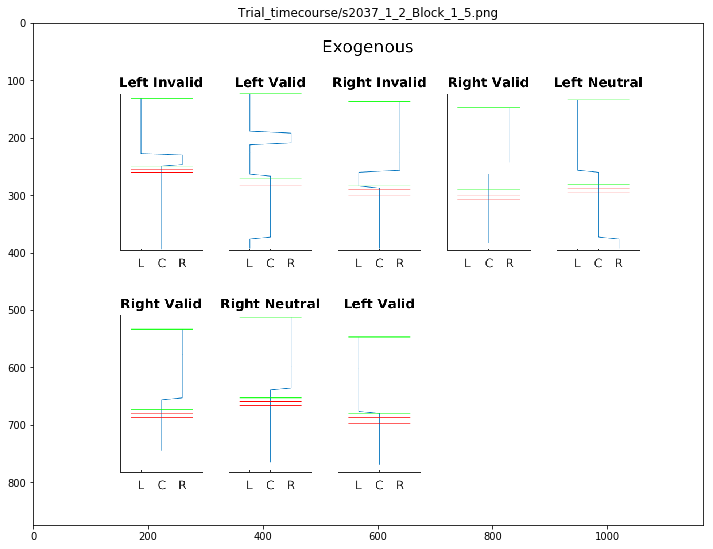

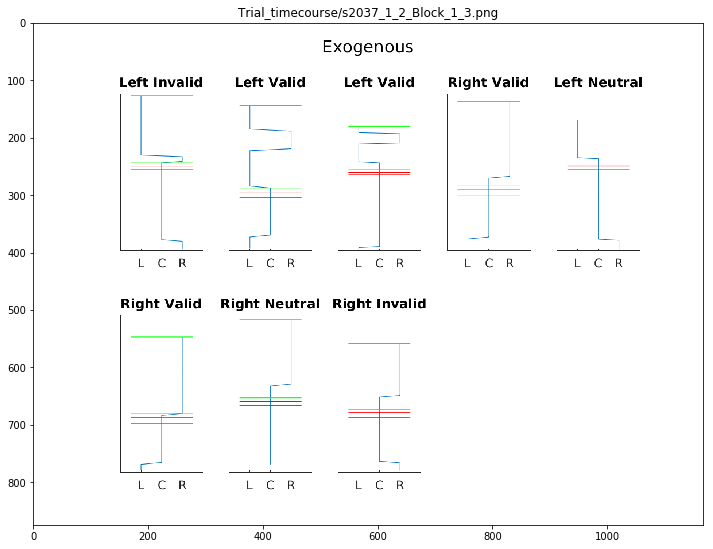

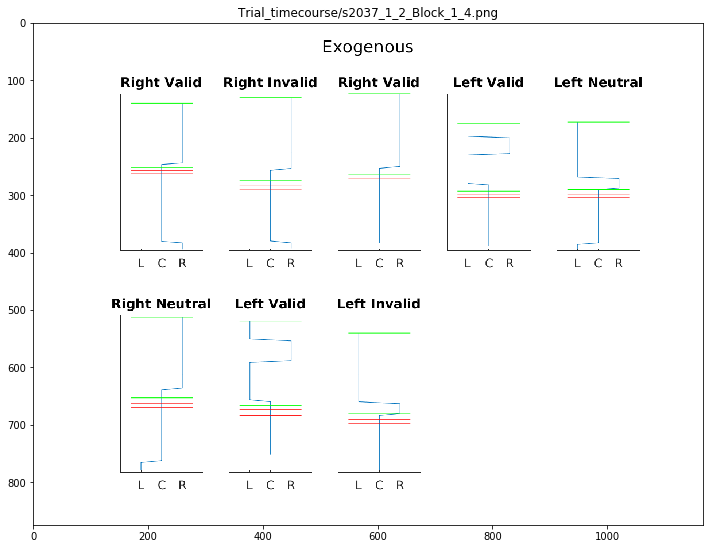

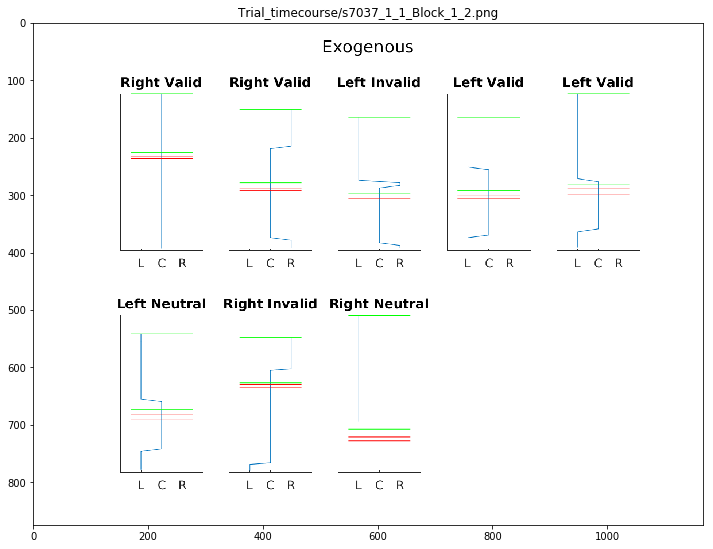

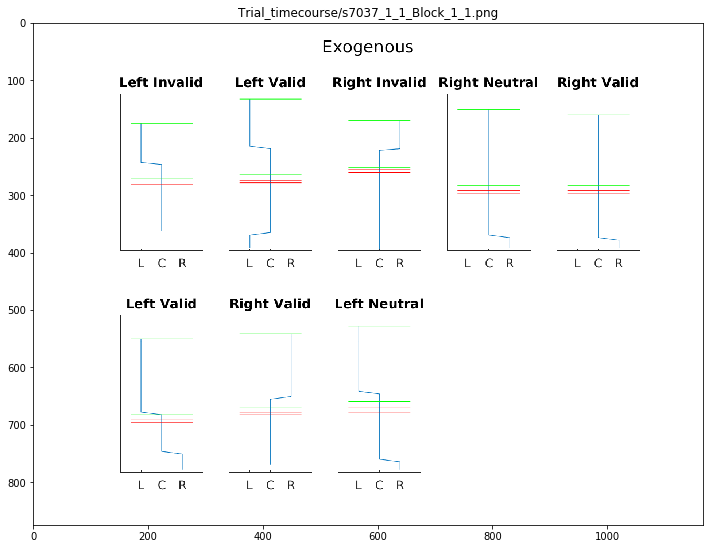

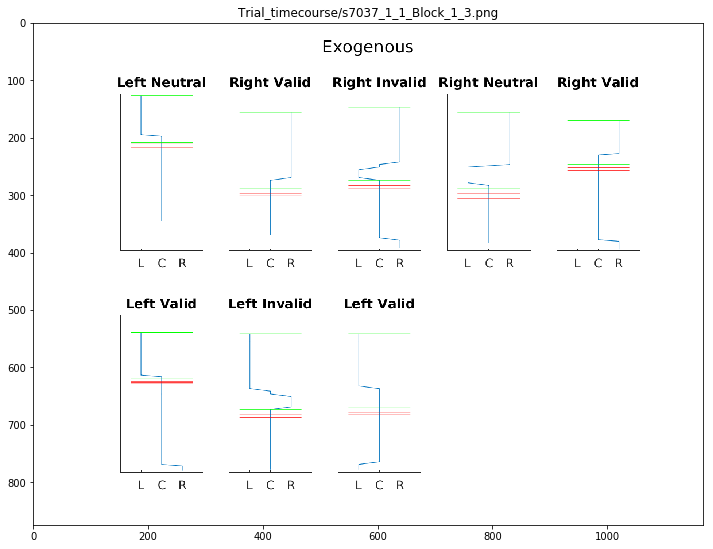

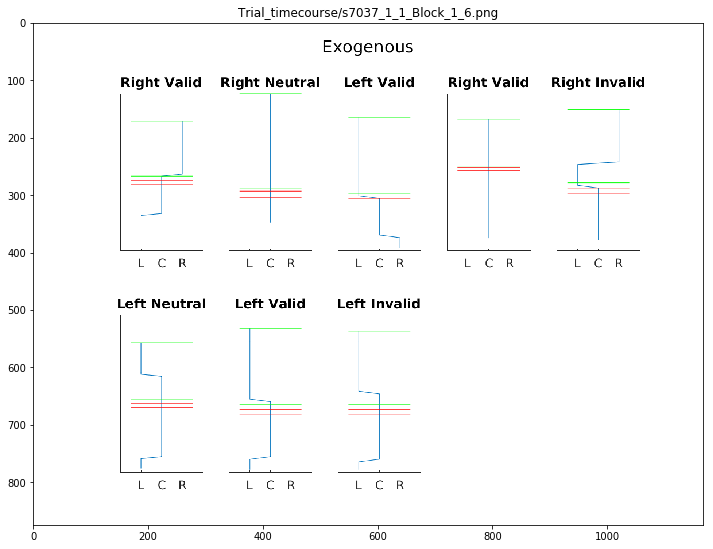

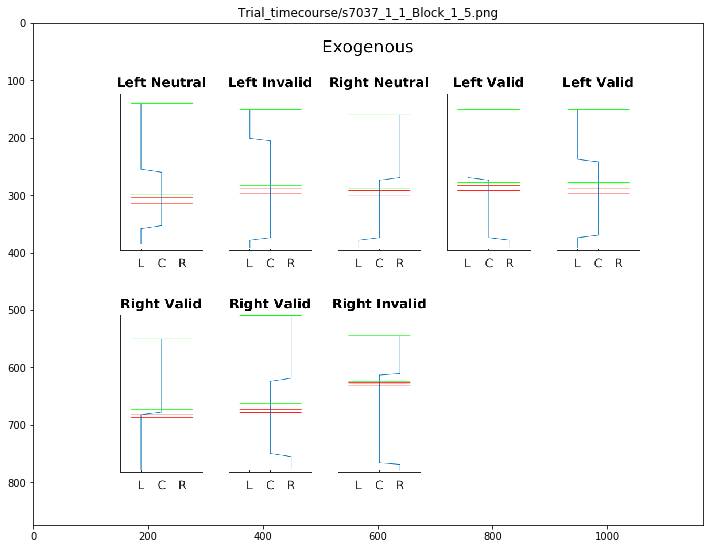

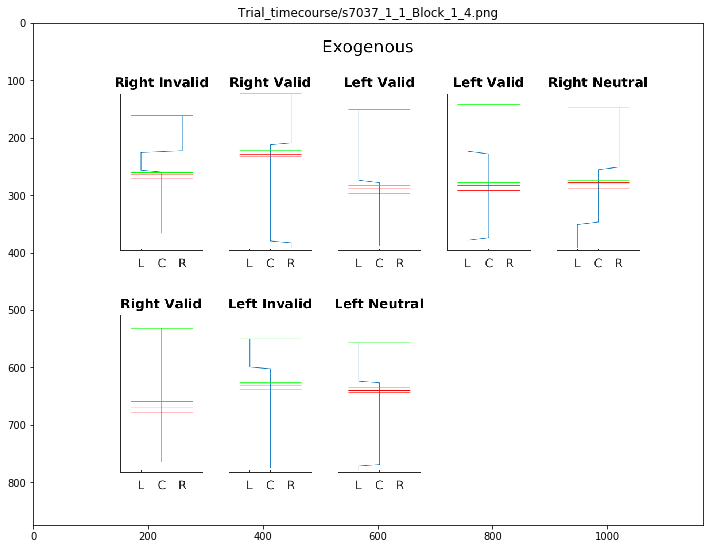

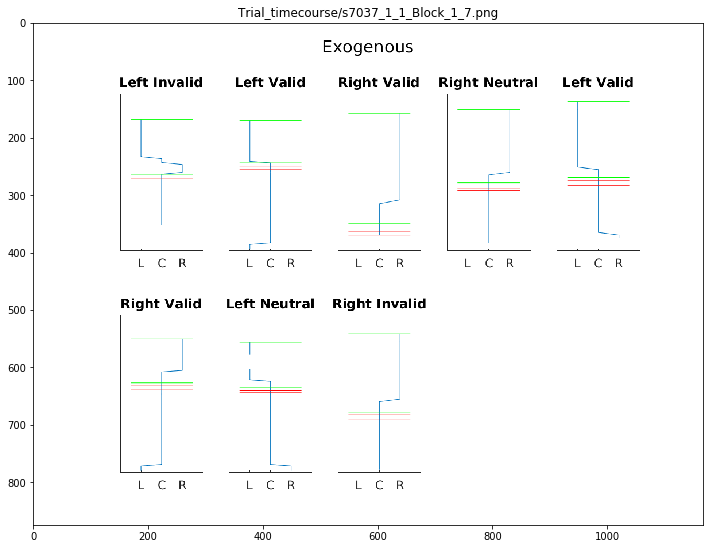

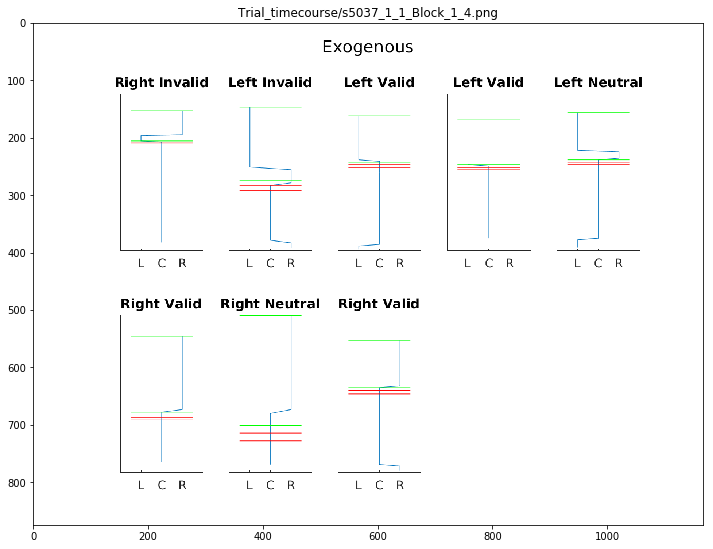

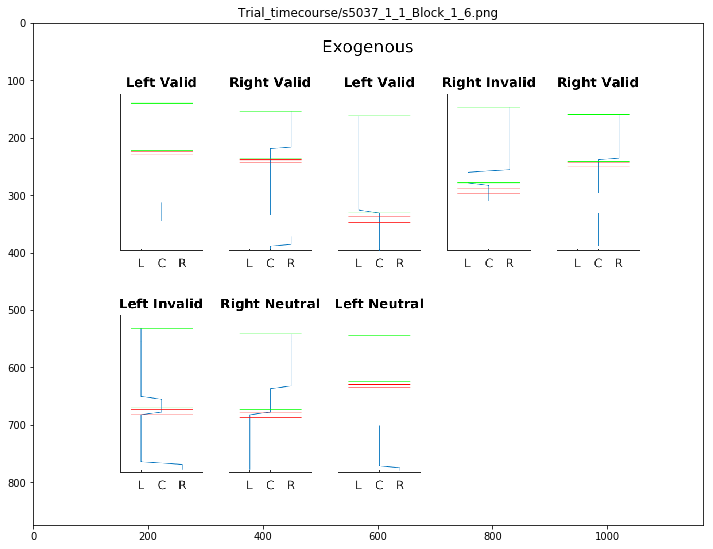

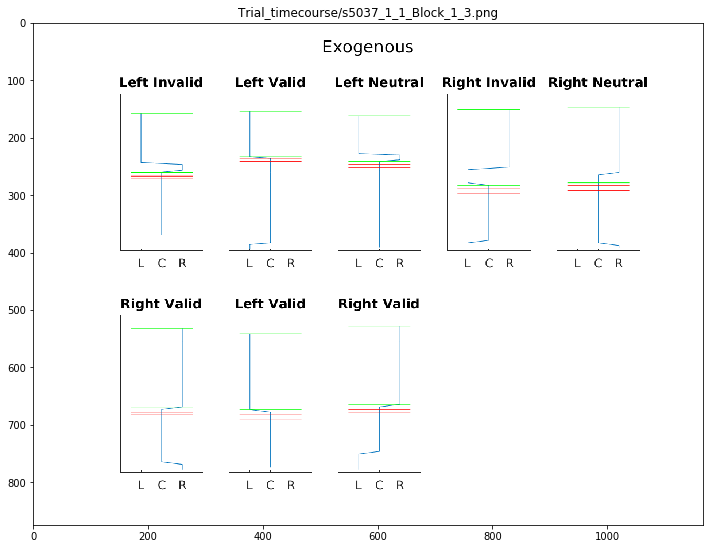

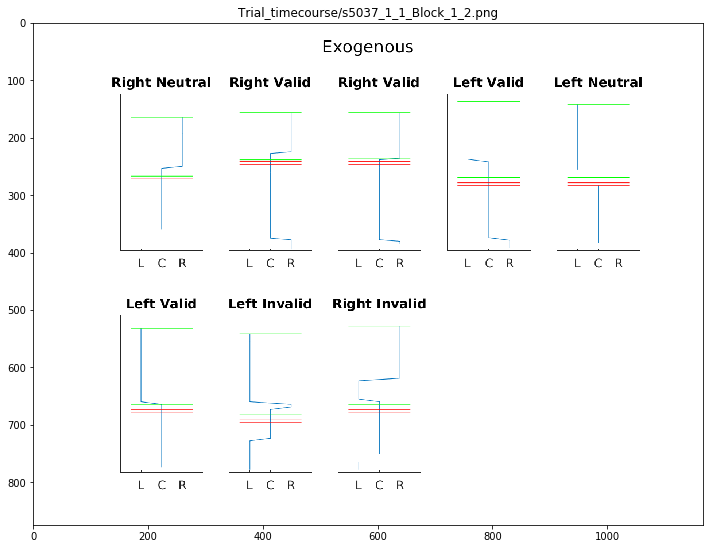

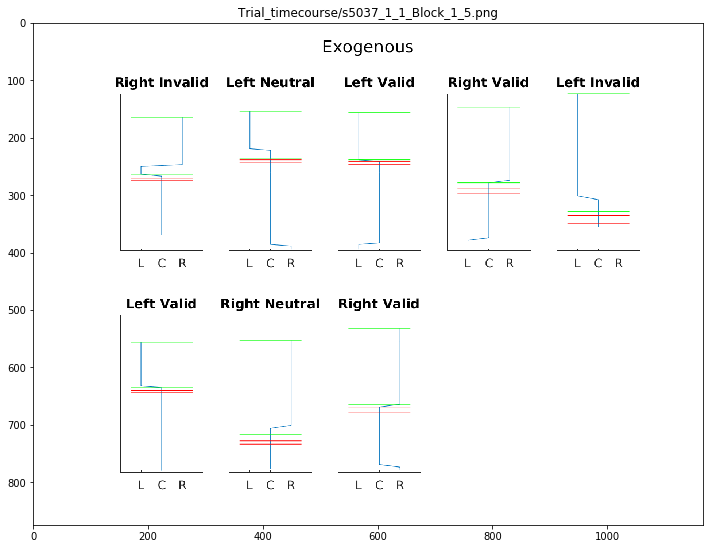

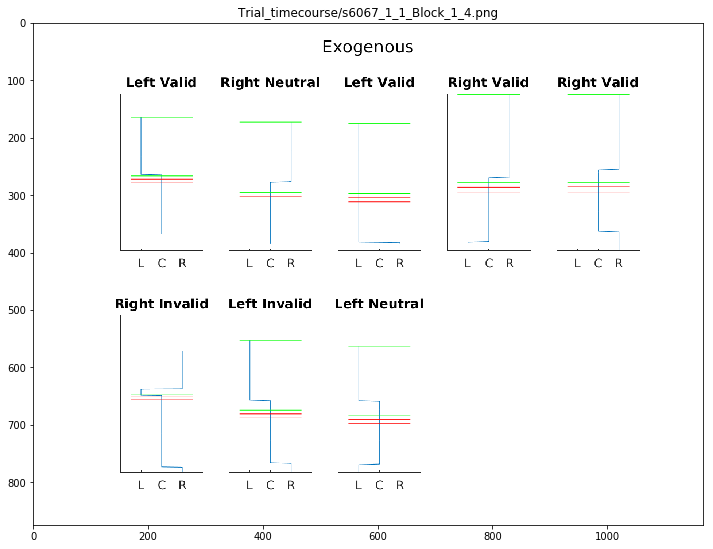

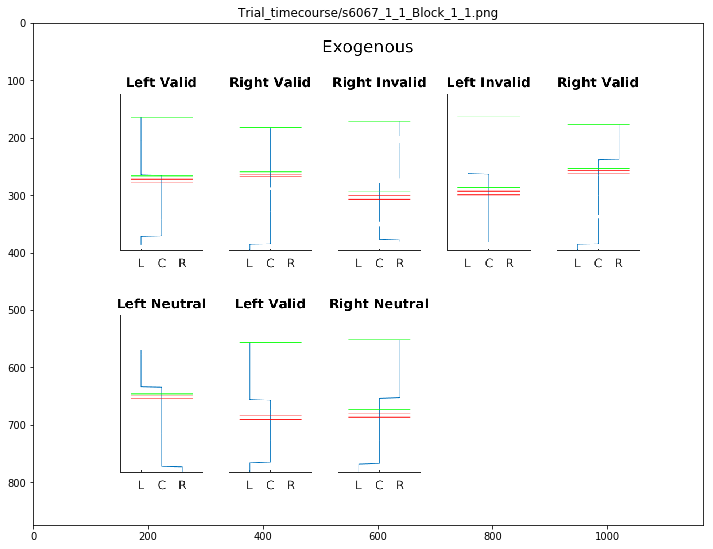

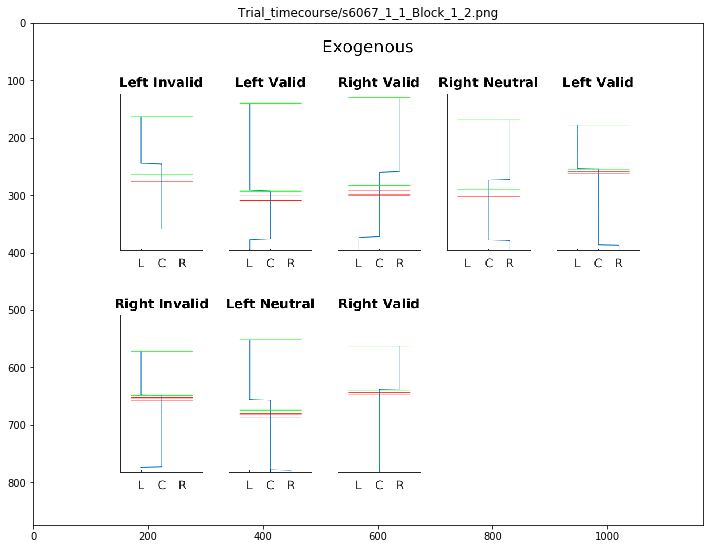

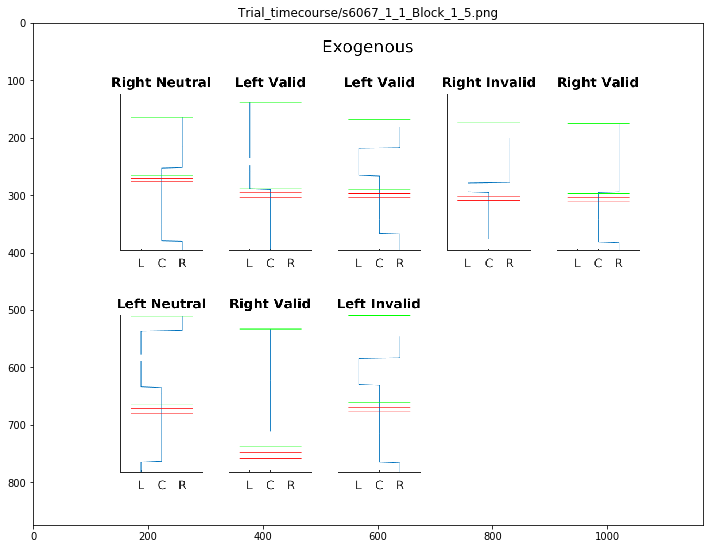

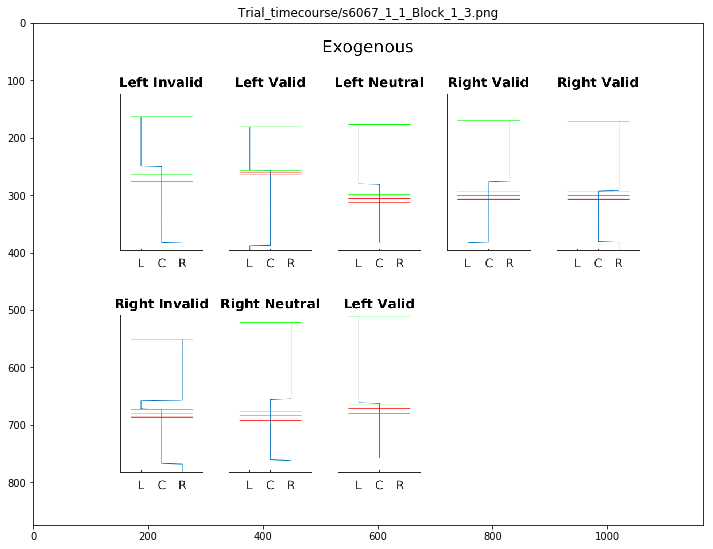

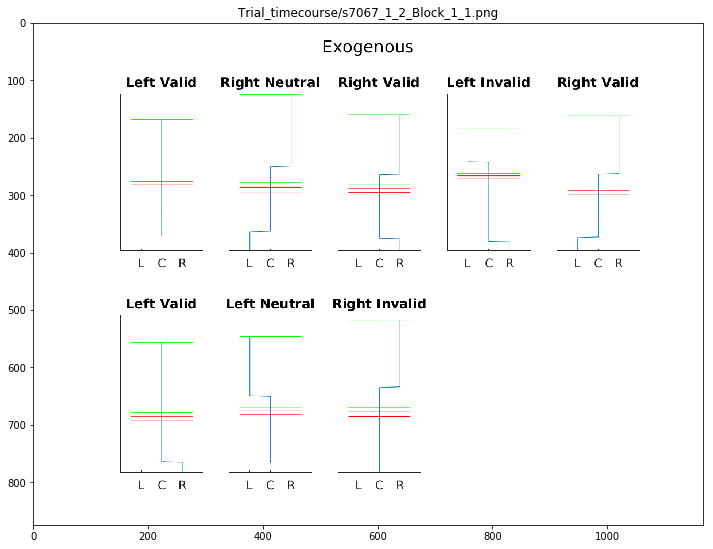

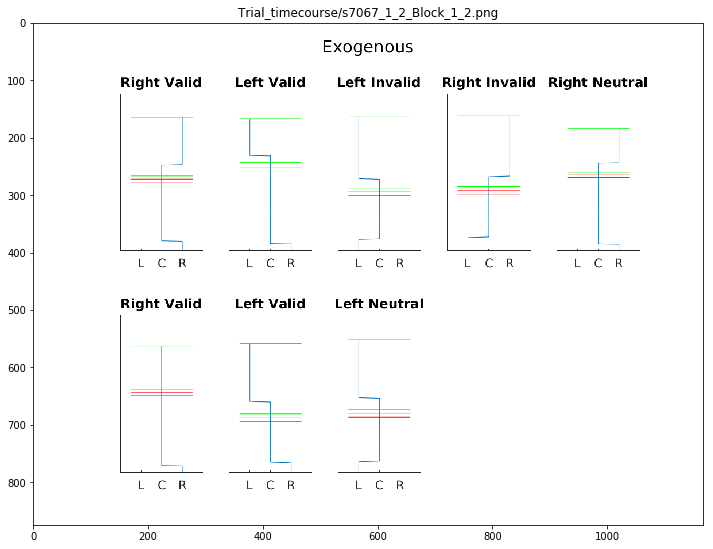

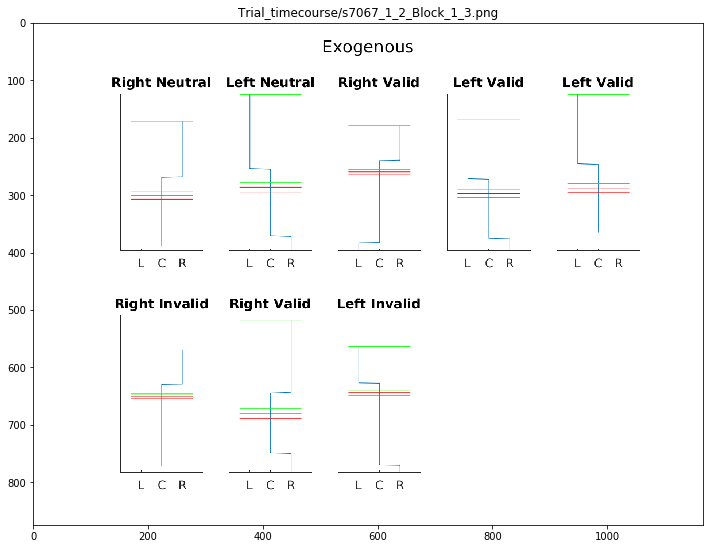

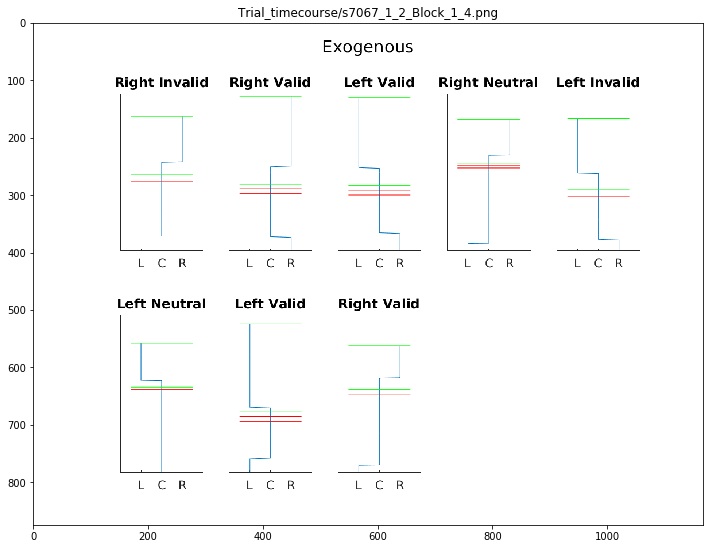

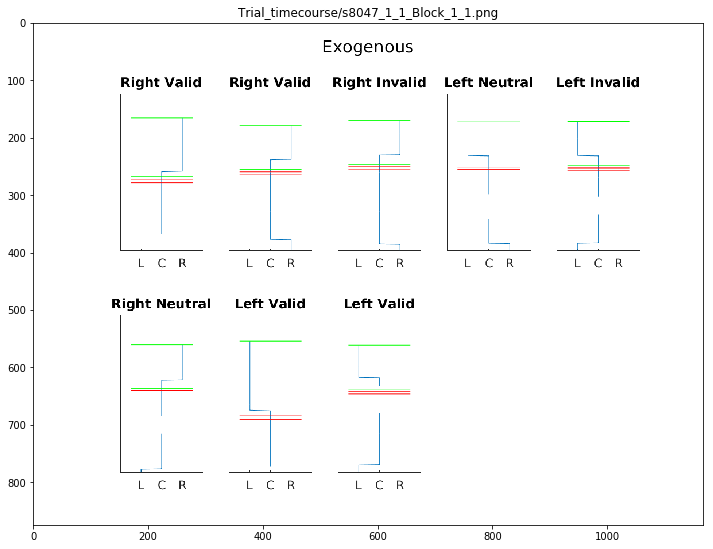

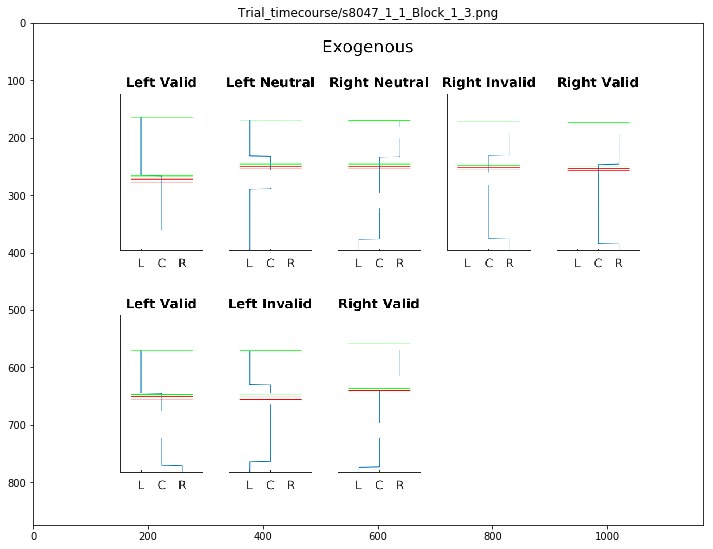

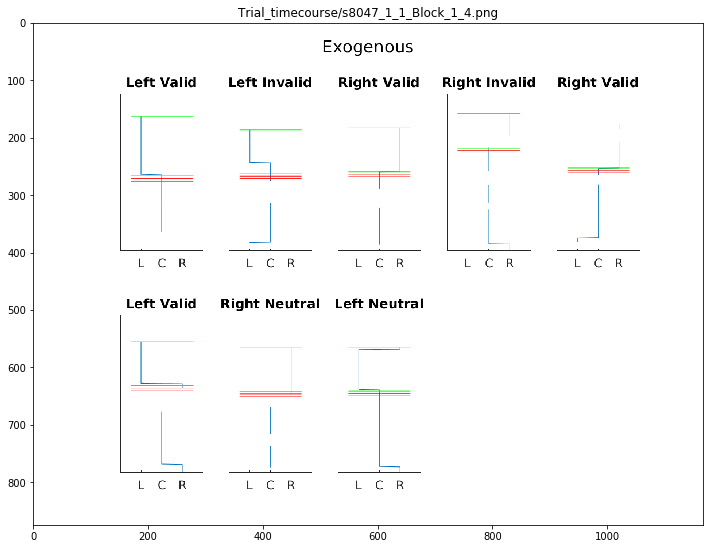

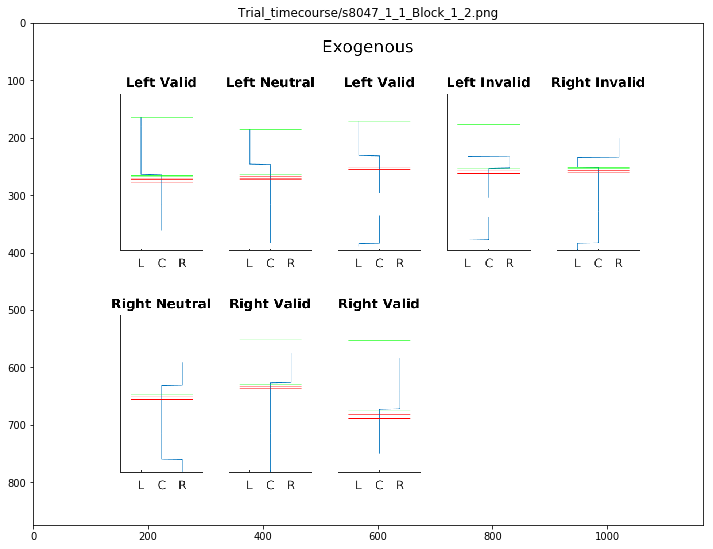

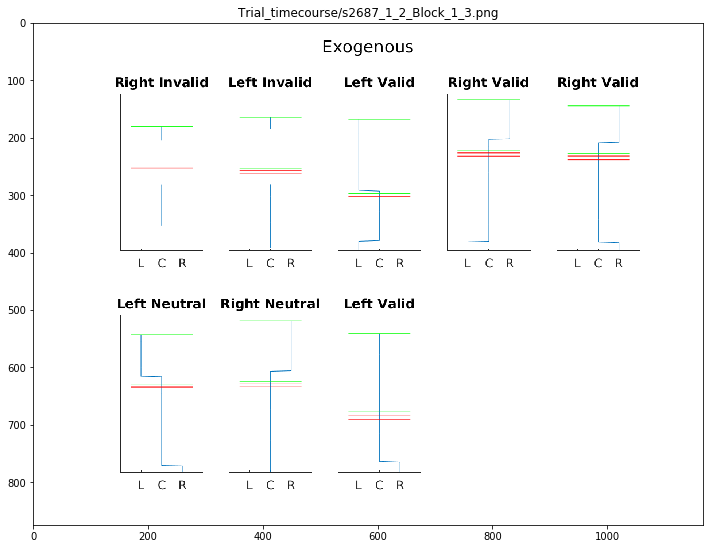

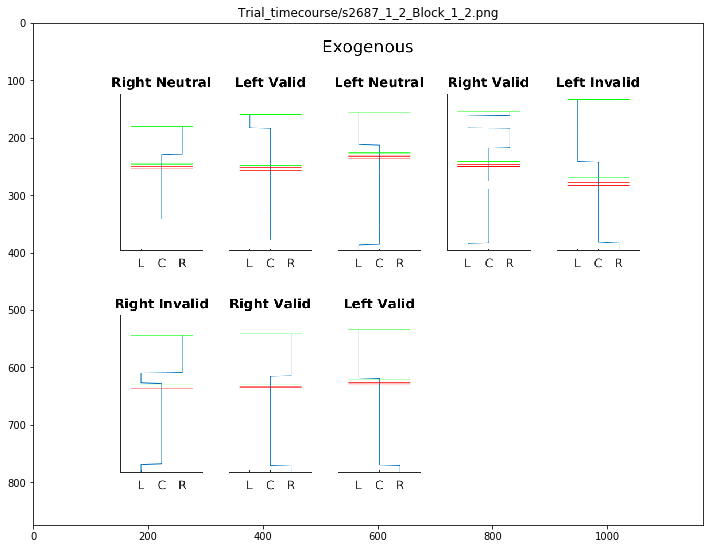

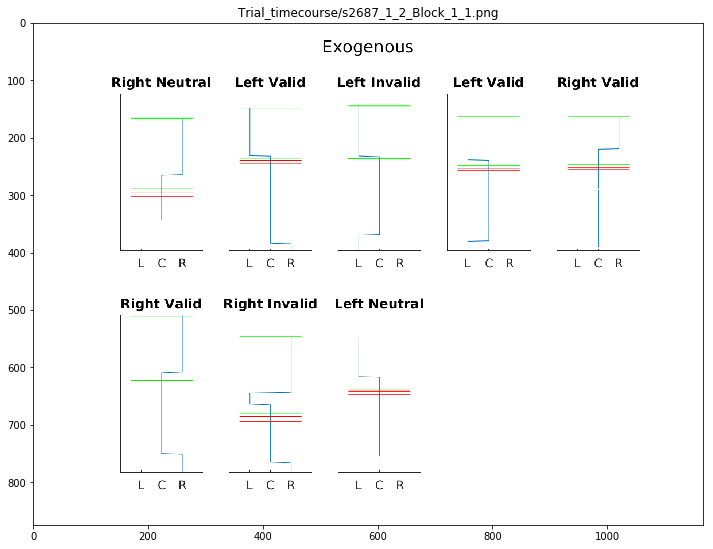

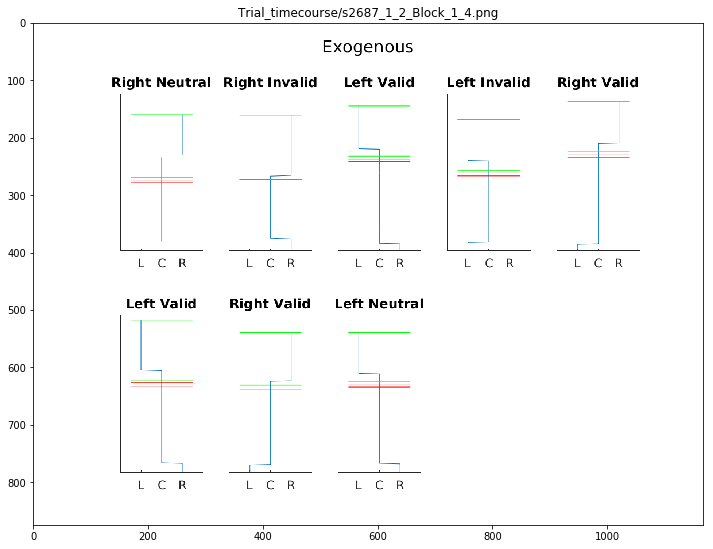

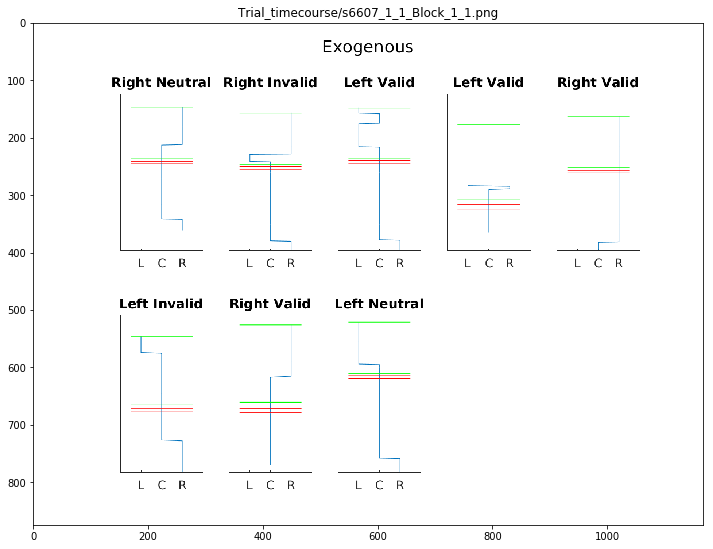

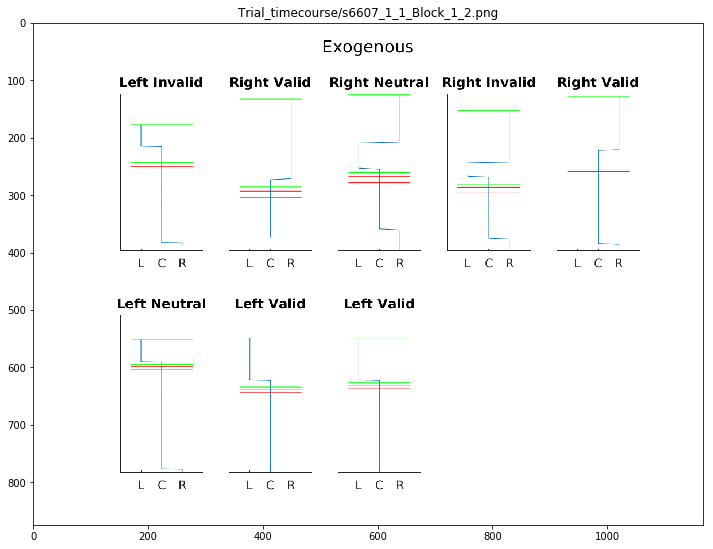

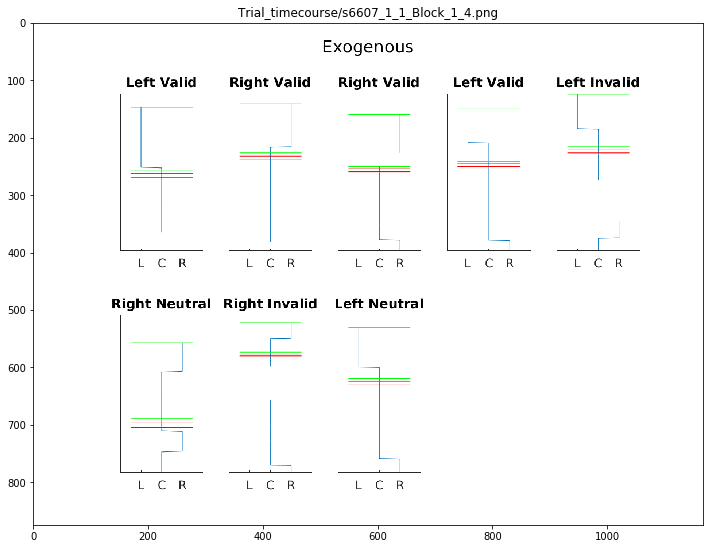

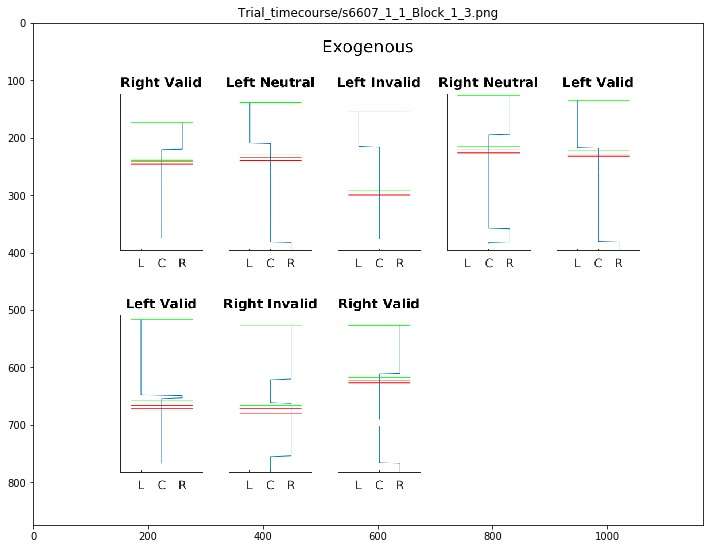

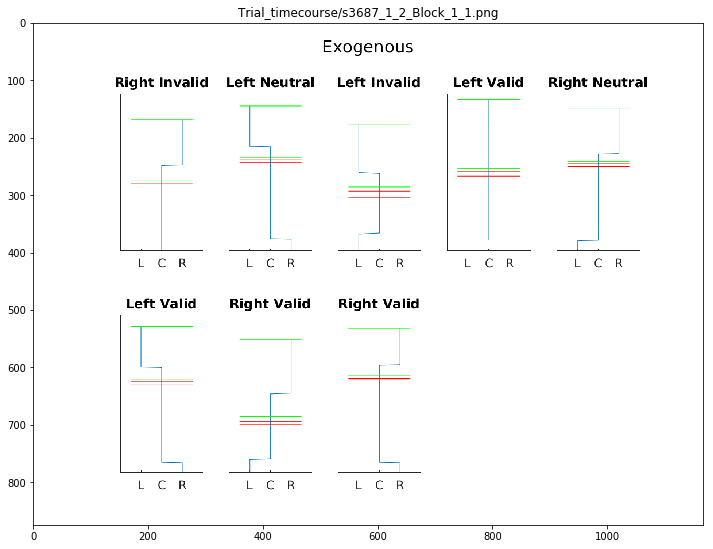

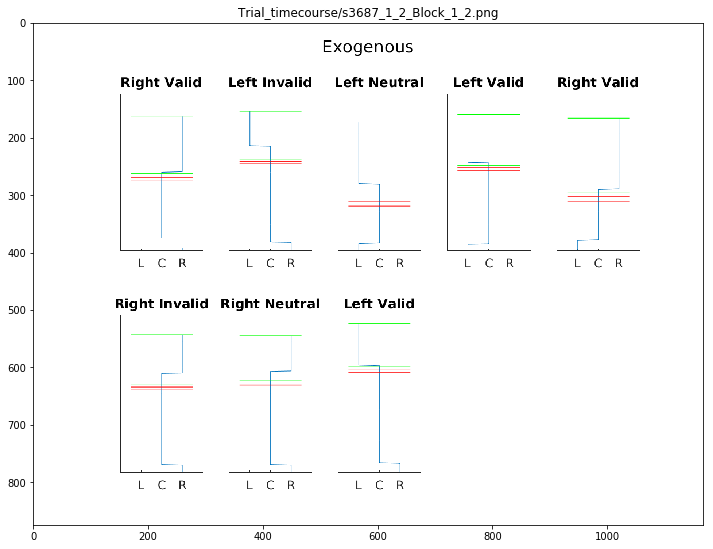

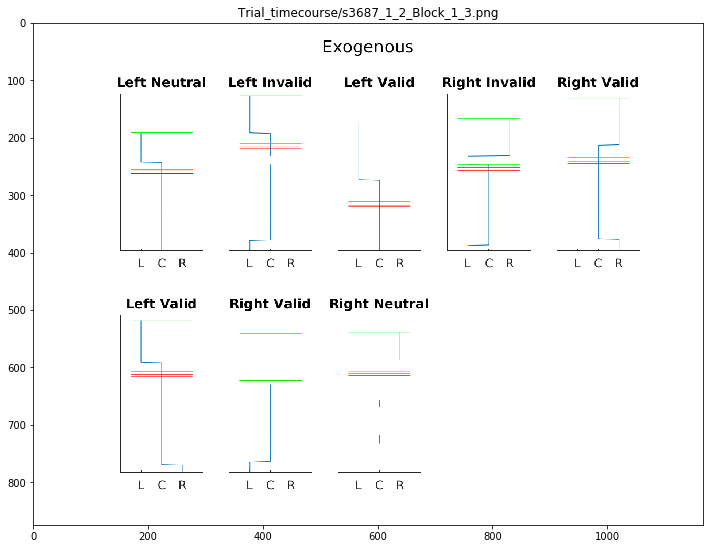

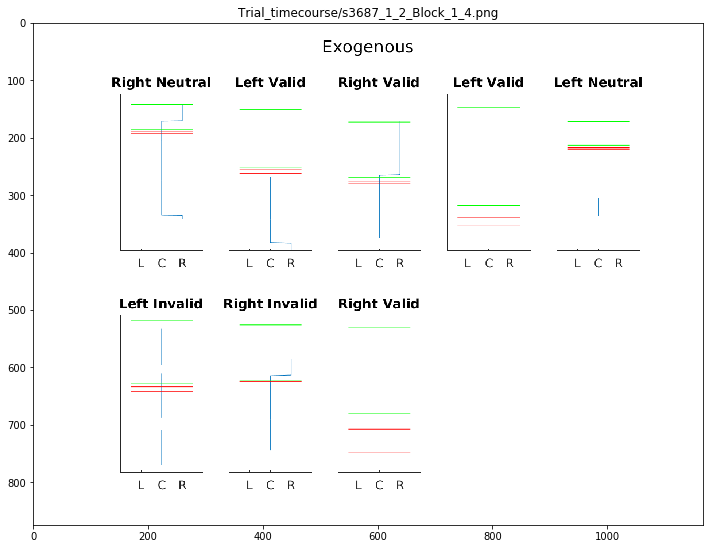

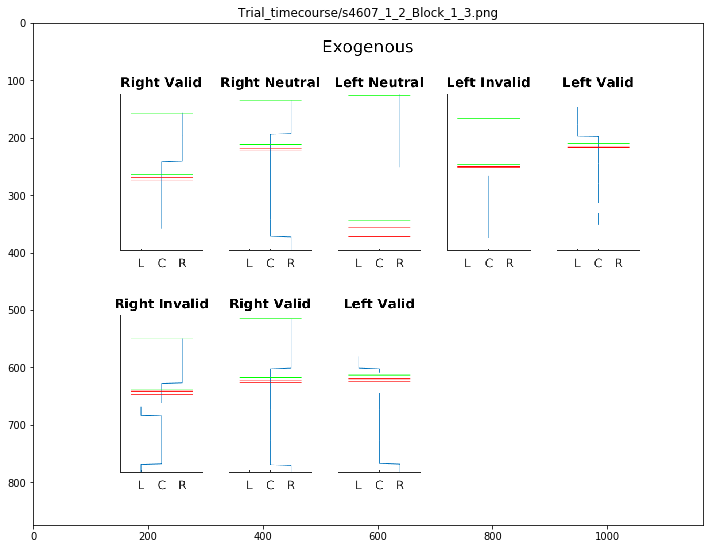

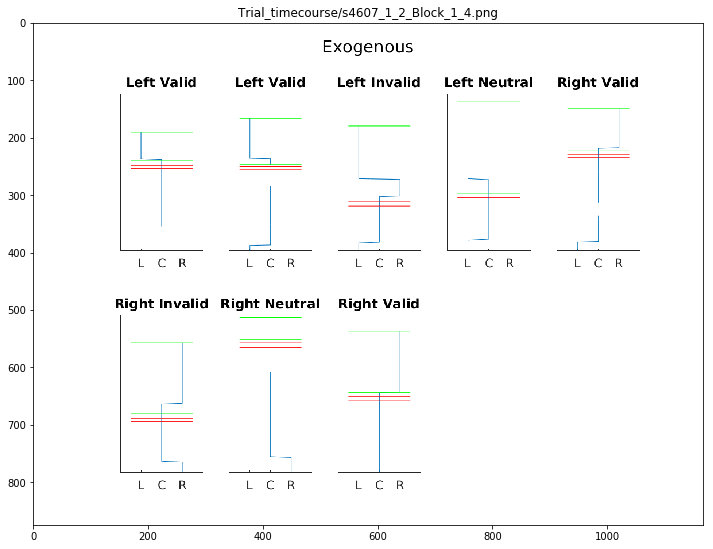

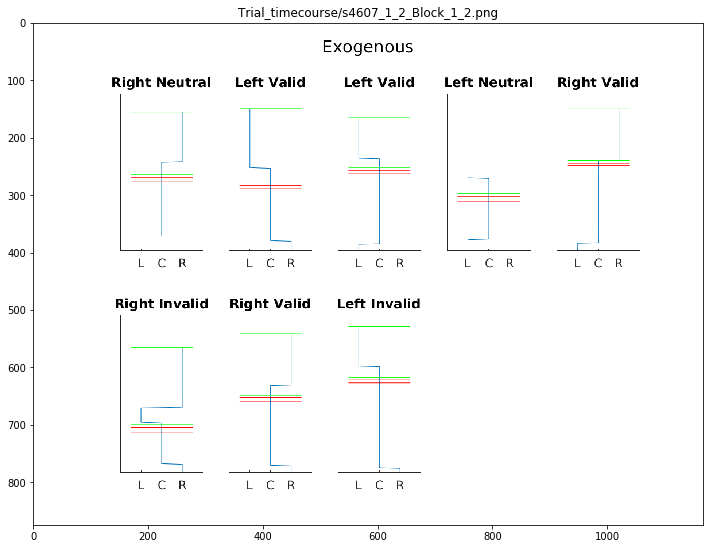

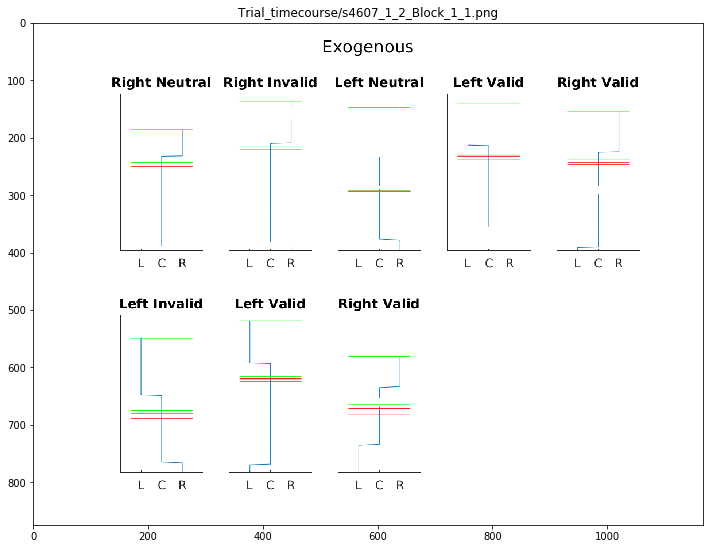

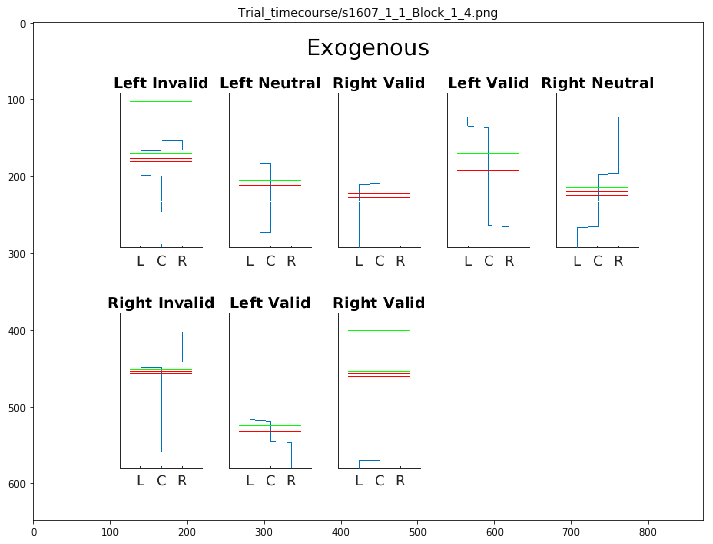

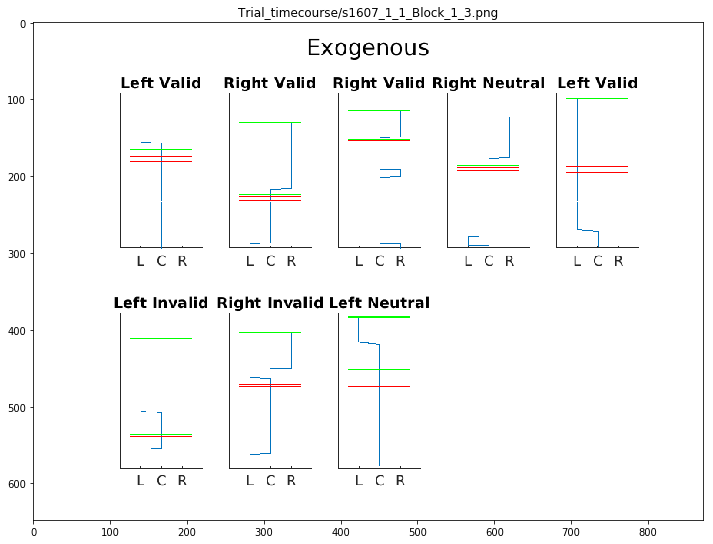

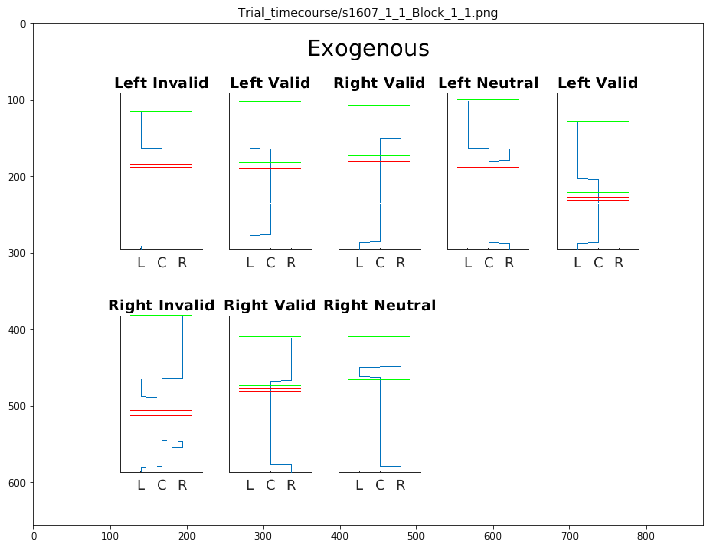

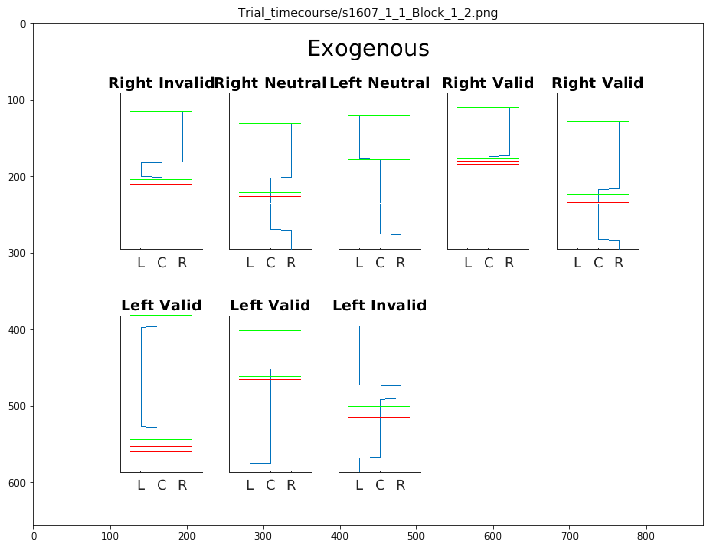

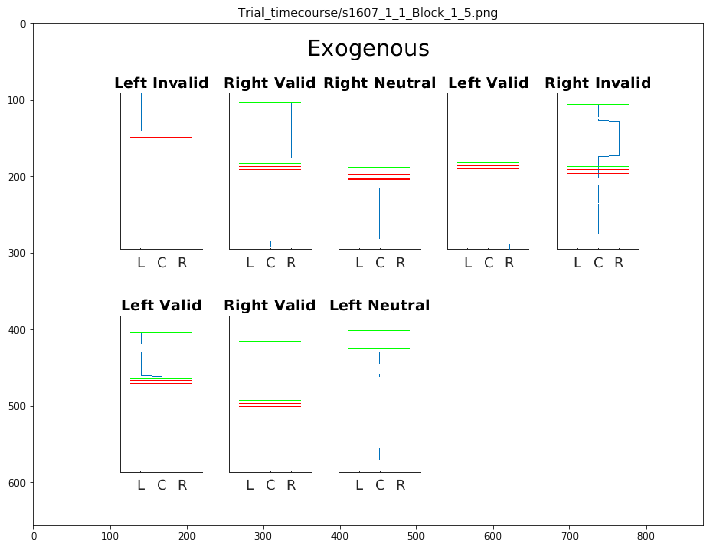

In [15]:
# Get the images
for ppt_id in df['ID']:
    
    files = glob.glob('%s/Trial_timecourse/%s_*.png' % (data_dir, ppt_id))
    
    for file in files:
        im = mpimg.imread(file)
        
        plt.figure(figsize=(12,12))
        plt.title(file[file.find('Trial_timecourse/'):])
        plt.imshow(im)
        

## Neural analysis

**Plot the brains for the different contrasts**

In [16]:
cmap = 'jet'
cmap_tstat = 'viridis'
p_val = 0.975 # Give the two sided p value
vmax = 3
cut_coords = [6, 31, 30]

# Convert the pvalue into a t stat
tstat_thresh = stats.t.ppf(p_val, len(df['ID']))

Orienting (Neutral>Valid)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


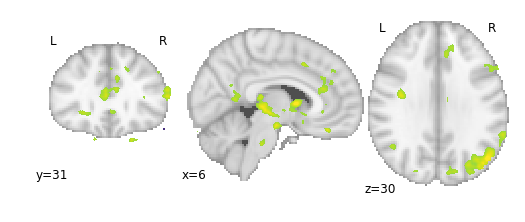

In [17]:
plotting.plot_stat_map(data_dir + '/wholebrain_tstat/valid_neutral_tstat2.nii.gz',
                       cut_coords=cut_coords,
                       vmax = vmax,
                       threshold = tstat_thresh,
                       display_mode='ortho',
                       cmap=cmap_tstat,
                       draw_cross=False,
                       colorbar=False,
                      )
plt.savefig(plot_dir + 'neutral_valid_tstat.svg')


Reorienting (Invalid > Valid)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


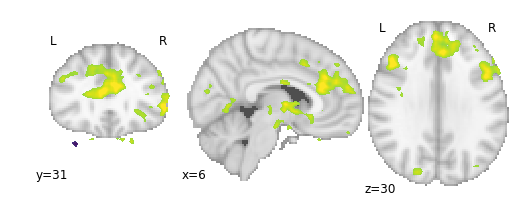

In [18]:
plotting.plot_stat_map(data_dir + '/wholebrain_tstat/valid_invalid_tstat2.nii.gz',
                       cut_coords=cut_coords,
                       vmax = vmax,
                       threshold = tstat_thresh,
                       display_mode='ortho',
                       cmap=cmap_tstat,
                       draw_cross=False,
                       colorbar=False,
                      )
plt.savefig(plot_dir + 'invalid_valid_tstat.svg')


Attention cost (Invalid>Neutral)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


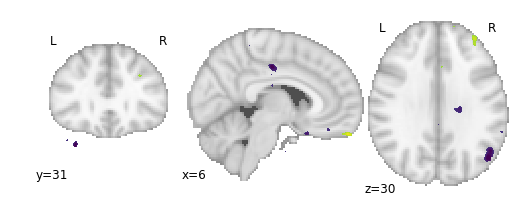

In [19]:
plotting.plot_stat_map(data_dir + '/wholebrain_tstat/invalid_neutral_tstat1.nii.gz',
                       cut_coords=cut_coords,
                       vmax = vmax,
                       threshold = tstat_thresh,
                       display_mode='ortho',
                       cmap=cmap_tstat,
                       draw_cross=False,
                       colorbar=False,
                      )
plt.savefig(plot_dir + 'invalid_neutral_tstat.svg')


Saccade event regressor

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


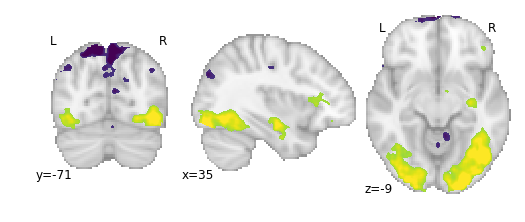

In [20]:
plotting.plot_stat_map(data_dir + '/wholebrain_tstat/saccade_evoked_tstat1.nii.gz',
                       cut_coords=None,
                       vmax = vmax,
                       threshold = tstat_thresh,
                       display_mode='ortho',
                       cmap=cmap_tstat,
                       draw_cross=False,
                       colorbar=False,
                      )

plt.savefig(plot_dir + 'saccade_tstat.svg')

Evoked activity per condition

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


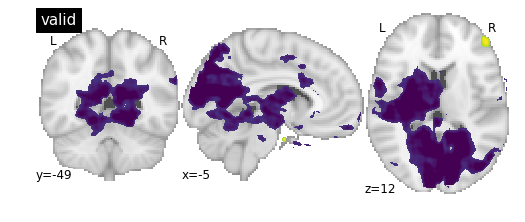

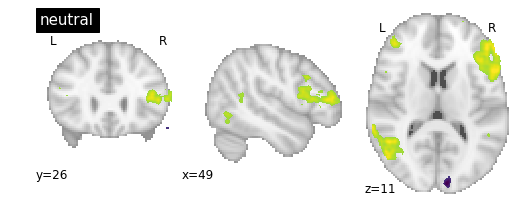

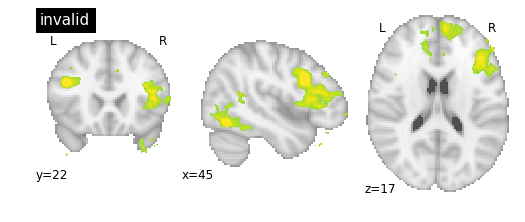

In [21]:

for condition in ['valid', 'neutral', 'invalid']:
    plotting.plot_stat_map(data_dir + '/wholebrain_tstat/%s_tstat1.nii.gz' % (condition),
                           #cut_coords=[5, 34, 23],
                           vmax = vmax,
                           threshold = tstat_thresh,
                           display_mode='ortho',
                           cmap=cmap_tstat,
                           draw_cross=False,
                           colorbar=False,
                           title=condition,
                          )
    

**Set up parameters for the ROI analysis**

In [22]:
atlas_dir = data_dir + '/ROIs/'

collapse_bilateral = 1 # Do you want to collapse ROI_pairs. 



# What are the names for the regions, in order of their labels in the volume
ns_ROI_names = ['rTPJ', 'lIPS', 'rLOC', 'lLOC', 'rACC', 'lFEF', 'lSPL', 'rFEF', 'rSPL', 'rIPS', 'rMFG']
ns_ROI_names_bilateral = ['rTPJ', 'rIPS', 'rLOC', 'rACC', 'rFEF', 'rSPL', 'rMFG']

# Which ROI pairs are you using
ROI_pairs = [[1], [2,10], [3, 4], [5], [6, 8], [7, 9], [11]]

# Make a list of colors for all ROIs
ROI_colors = np.asarray([[127, 127, 127], 
              [142, 255, 20], 
              [232, 161, 19], 
              [255, 36, 32], 
              [82, 19, 232], 
              [255, 221, 13], 
              [10, 243, 255], 
              [232, 77, 12], 
              [207, 0, 255], 
              [235, 238, 255], 
              [23, 255, 84], 
              [12, 111, 232], 
              [112, 51, 30], 
              [200, 11, 232],
             ]) / 255


ns_ROI_colors = np.asarray([[127, 127, 127], # Start
              [142, 255, 20], # rTPJ
              [232, 161, 19], # ldIPS
              [255, 36, 32], # rLOC
              [255, 36, 32], # lLOC
              [255, 221, 13], # rACC
              [10, 243, 255], # lFEF
              [232, 77, 12], # lSPL
              [10, 243, 255], # rFEF
              [232, 77, 12], # rSPL
              [232, 161, 19], # rdIPS
              [12, 111, 232], # rMFG
             ]) / 255

# Store the colors in a dictionary for later reference
ns_ROI_color_dict = {}
for ROI_counter, ns_ROI_name in enumerate(ns_ROI_names):
    ns_ROI_color_dict[ns_ROI_name] = ns_ROI_colors[ROI_counter + 1, :]

ns_ROI_colormap = ListedColormap(ns_ROI_colors)
ns_ROI_colormap_dual = ListedColormap(np.vstack((np.flipud(ns_ROI_colors[1:, :]), ns_ROI_colors)))

# Use the p value from Holms-Bonferroni
use_corrected_p_val = False

# Set the range of the y axis
max_y_val = 4.0

In [23]:
# What type of ROI do you want to use
ns_ROI_type = 'raw' # 'raw', 'dilated', or 'spheres'
ns_ROI_file = '%s/ns_%s.nii.gz' % (atlas_dir, ns_ROI_type)

# Load in the ROI
nii = nib.load(ns_ROI_file)
ns_ROI = nii.get_data()

# Set the seed for the bootstrapping
np.random.seed(0)

**Load in the ROIs used for analysis**

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


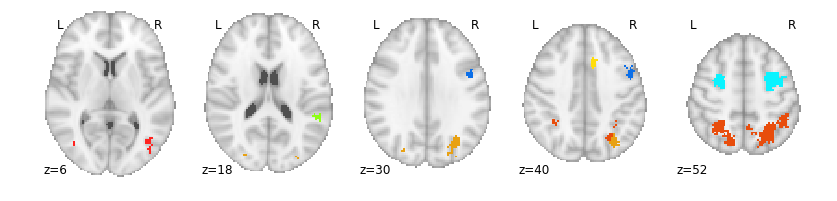

In [24]:
# Show the rois
nii = nib.Nifti1Image(ns_ROI, nii.affine)
#plotting.view_img(nii, cmap=ns_ROI_colormap_dual)


plotting.plot_stat_map(nii,
                       cut_coords=[52, 40, 30, 18, 6],
                       vmax = ns_ROI.max(),
                       display_mode='z',
                       cmap=ns_ROI_colormap_dual,
                       draw_cross=False,
                       colorbar=False,
                       symmetric_cbar=False,
                      )

plt.savefig(plot_dir + 'neurosynth_ROI_%s.svg' % (ns_ROI_type))

**Analyze data according to ROIs**

Valid vs invalid

Flipping sign for consistency
rTPJ: 17/24, M=0.40, CI=[-0.03, 0.79], p=0.066
IPS: 17/24, M=0.46, CI=[-0.07, 0.95], p=0.084
LOC: 18/24, M=0.47, CI=[0.05, 0.87], p=0.032
rACC: 16/24, M=0.37, CI=[0.04, 0.70], p=0.027
FEF: 16/24, M=0.14, CI=[-0.39, 0.63], p=0.575
SPL: 16/24, M=0.10, CI=[-0.37, 0.56], p=0.670
rMFG: 19/24, M=0.40, CI=[0.05, 0.76], p=0.028


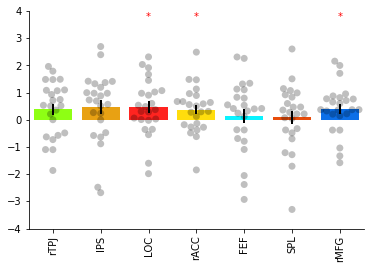

In [25]:
condition = 'valid_invalid'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))

Invalid vs neutral

rTPJ: 14/24, M=0.06, CI=[-0.27, 0.37], p=0.706
IPS: 14/24, M=0.06, CI=[-0.24, 0.32], p=0.684
LOC: 11/24, M=-0.03, CI=[-0.36, 0.28], p=0.861
rACC: 12/24, M=0.00, CI=[-0.27, 0.26], p=0.985
FEF: 14/24, M=0.10, CI=[-0.26, 0.43], p=0.585
SPL: 12/24, M=-0.02, CI=[-0.29, 0.25], p=0.914
rMFG: 15/24, M=0.09, CI=[-0.18, 0.34], p=0.501


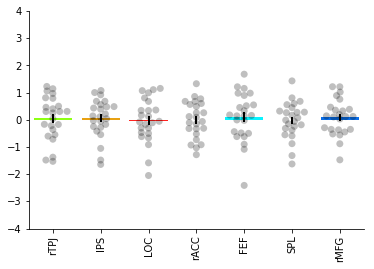

In [26]:
condition = 'invalid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)

plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))

Valid vs neutral

Flipping sign for consistency
rTPJ: 16/24, M=0.32, CI=[-0.18, 0.80], p=0.211
IPS: 19/24, M=0.38, CI=[-0.00, 0.72], p=0.051
LOC: 17/24, M=0.47, CI=[0.09, 0.84], p=0.017
rACC: 15/24, M=0.37, CI=[0.03, 0.69], p=0.033
FEF: 14/24, M=0.01, CI=[-0.50, 0.48], p=0.961
SPL: 15/24, M=0.09, CI=[-0.40, 0.54], p=0.693
rMFG: 14/24, M=0.30, CI=[-0.13, 0.72], p=0.166


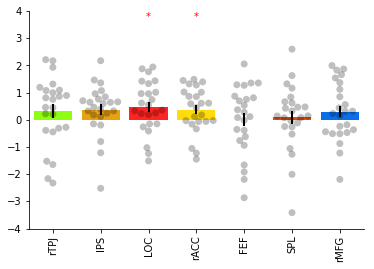

In [27]:
condition = 'valid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))

**Run the saccade analysis**  
This uses the same ROIs as above but looks at the evoked activity to saccades

rTPJ: 14/24, M=0.30, CI=[-0.15, 0.73], p=0.203
IPS: 12/24, M=-0.30, CI=[-0.78, 0.17], p=0.206
LOC: 14/24, M=0.28, CI=[-0.05, 0.63], p=0.100
rACC: 10/24, M=-0.01, CI=[-0.56, 0.53], p=0.978
FEF: 13/24, M=0.19, CI=[-0.30, 0.68], p=0.492
SPL: 13/24, M=-0.07, CI=[-0.47, 0.34], p=0.750
rMFG: 15/24, M=0.32, CI=[-0.19, 0.83], p=0.222


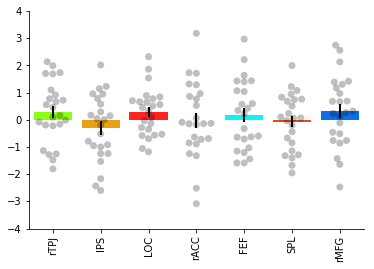

In [28]:
condition = 'saccade_evoked'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)

plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))

**Correlate the ROI effects with age and behavior**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

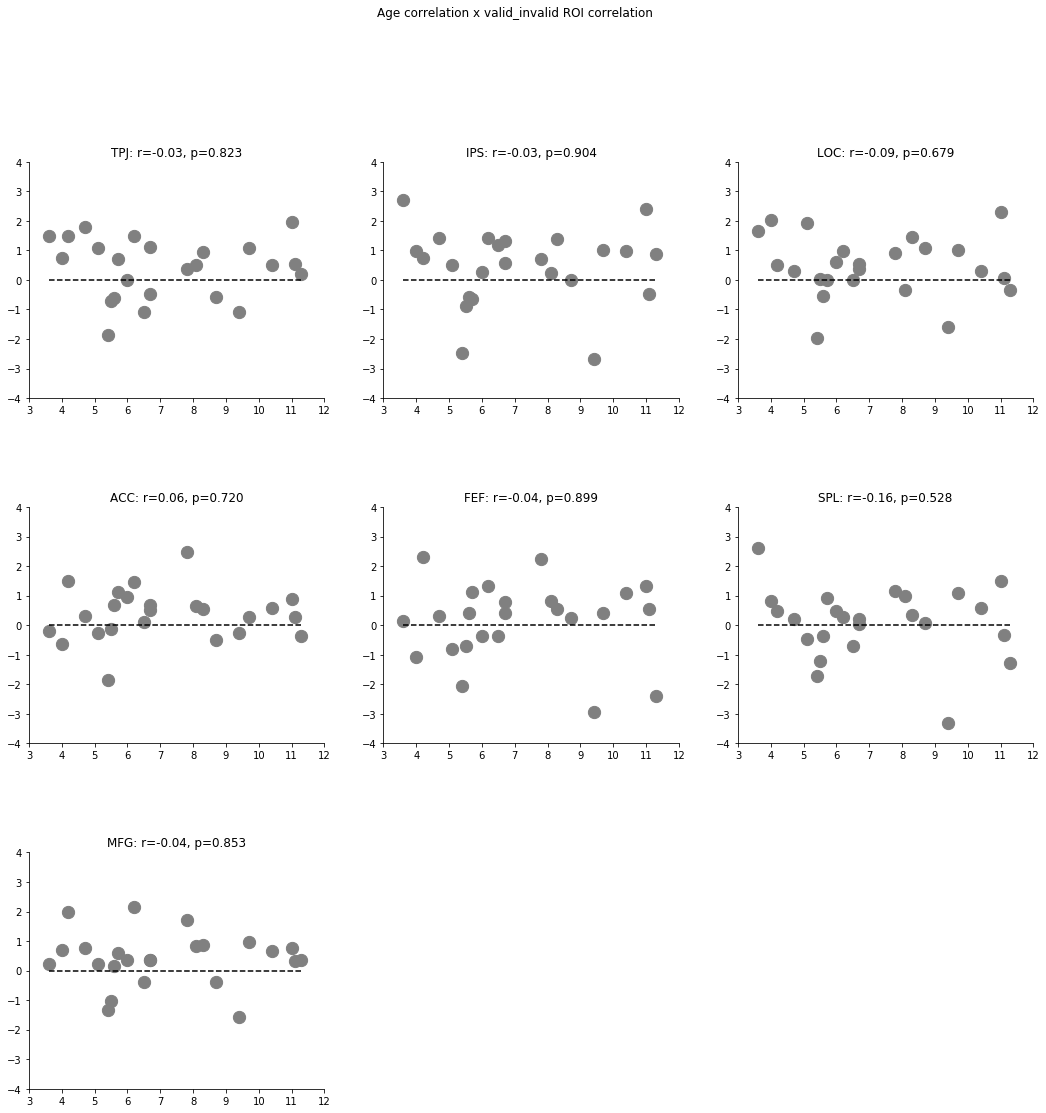

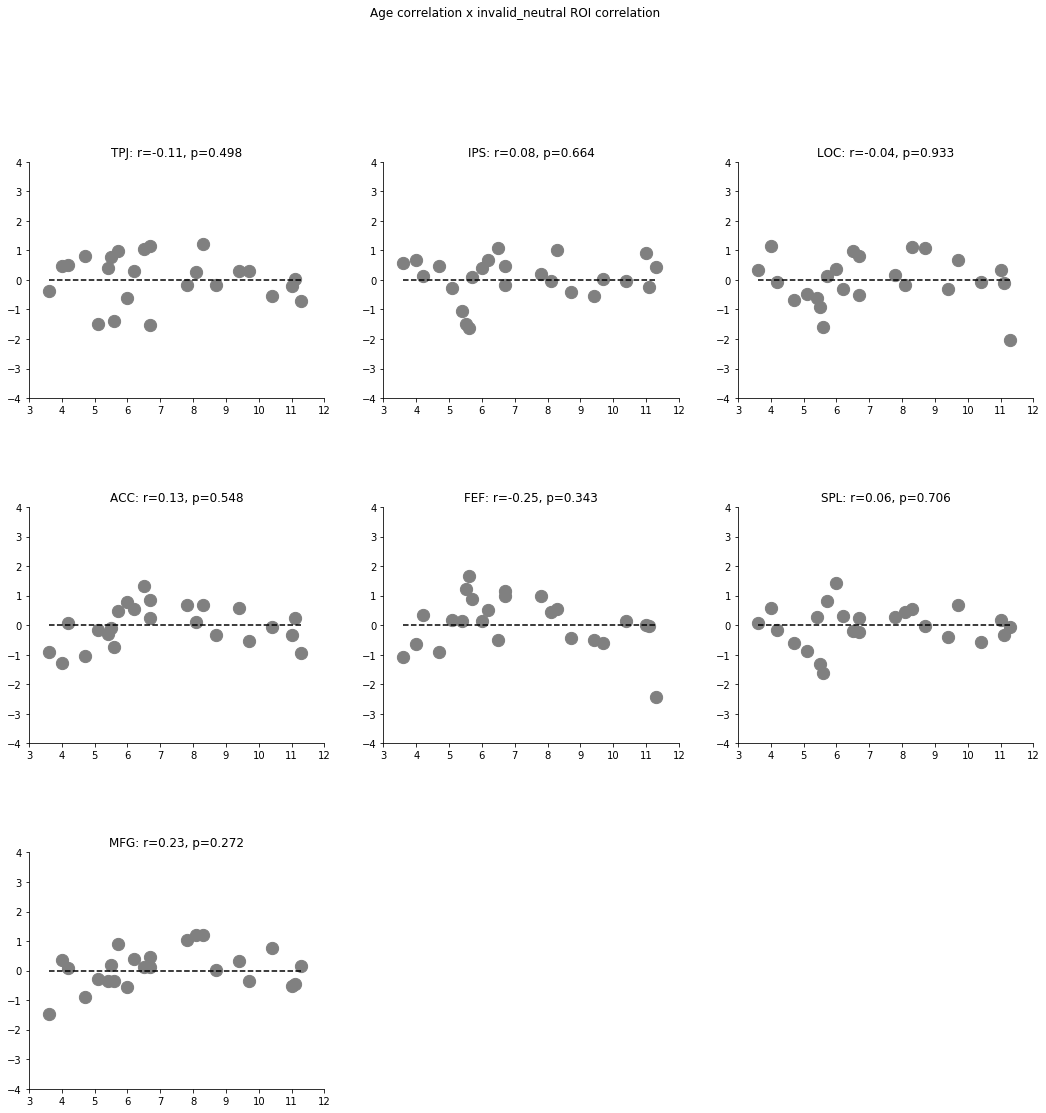

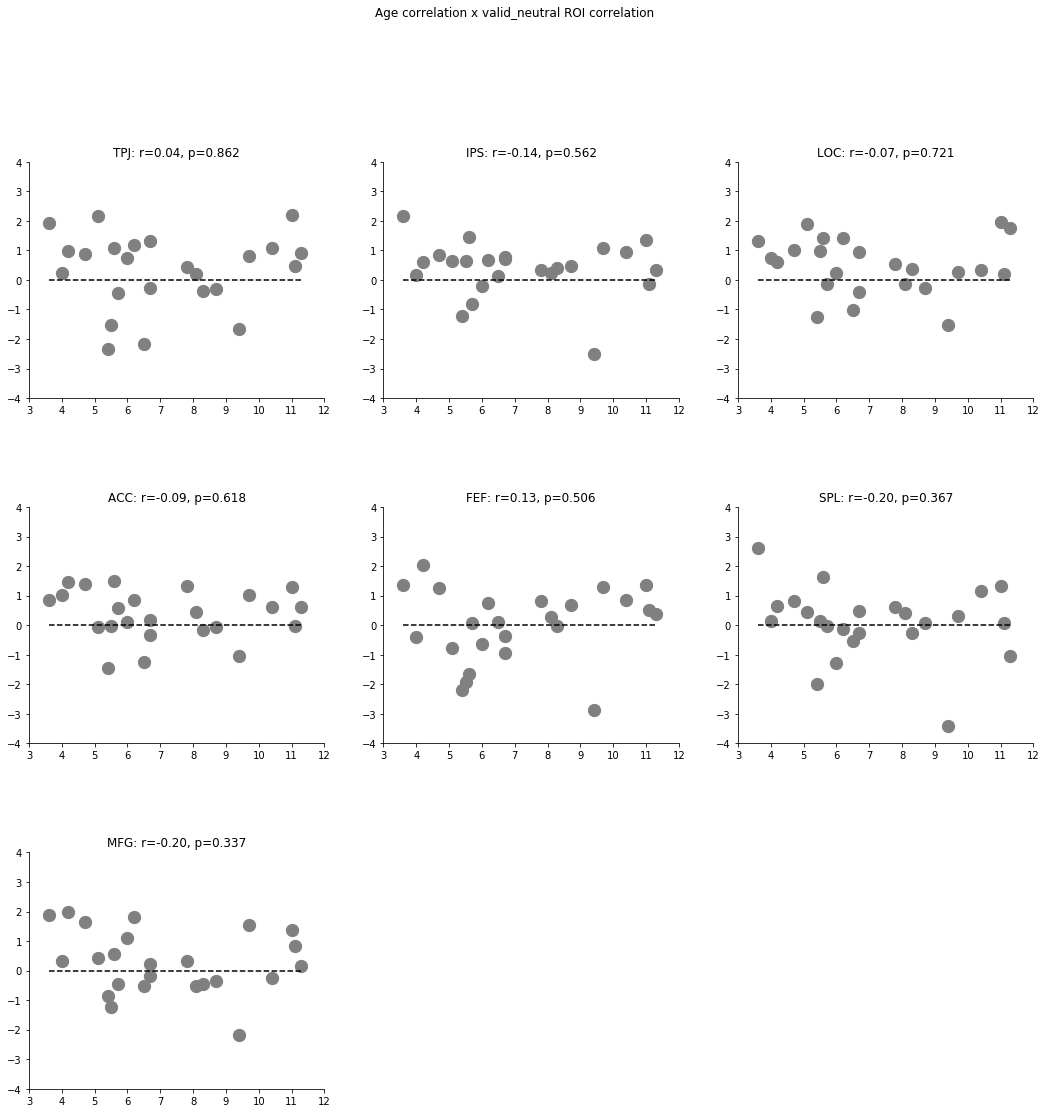

In [29]:
for contrast in ['valid_invalid', 'invalid_neutral', 'valid_neutral']:

    nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, contrast))
    vol = nii.get_data()

    # Flip sign to make it invalid - valid and valid - neurtral
    if contrast != 'invalid_neutral':
        vol *= -1

    correlate_ROIs(vol, ns_ROI, df['Age'], plot=1, collapse_bilateral=collapse_bilateral)
    plt.suptitle('Age correlation x %s ROI correlation' % contrast)
    
    plt.savefig('%s/%s_%s_age_correlation.svg' % (plot_dir, ns_ROI_type, contrast))

**Correlate the number of invalid trials per participant with the size of invalid > valid contrast**  
This could have been driving the effect but wasn't

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

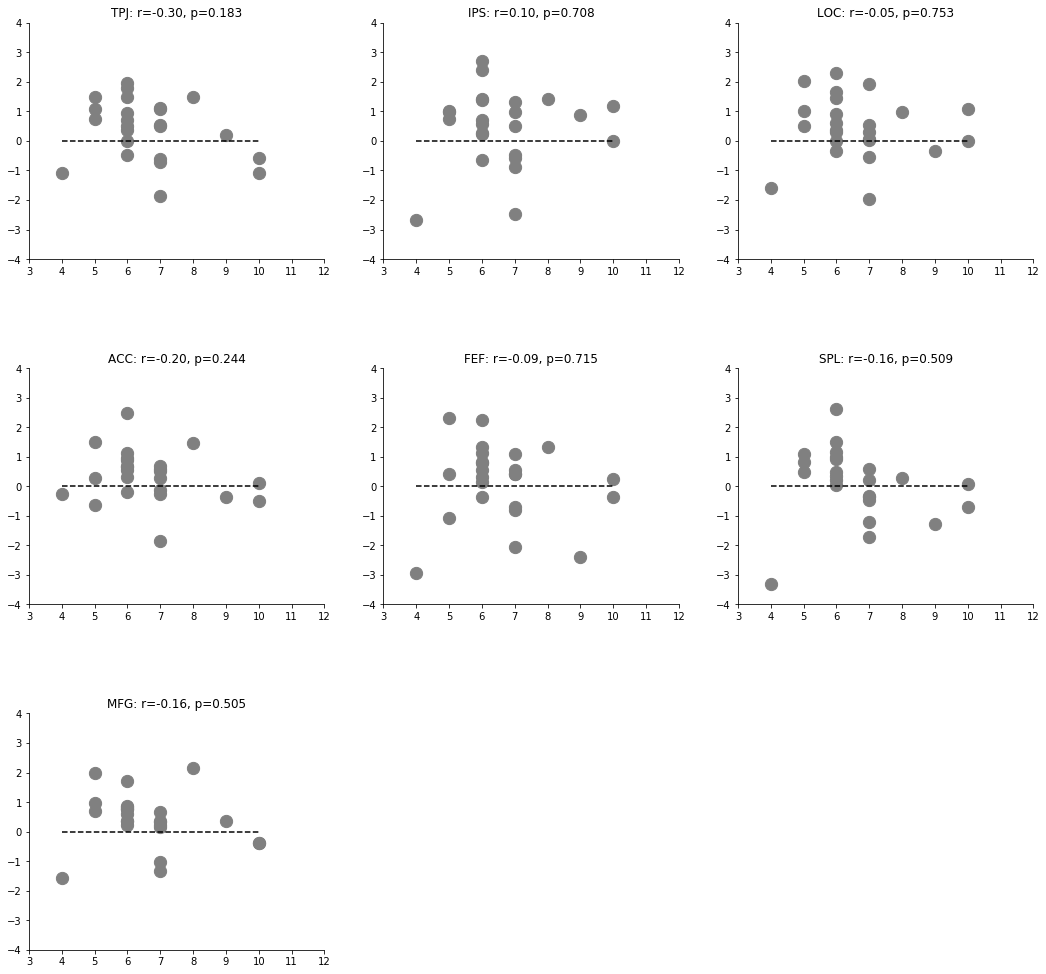

In [30]:
# Get the participant RTs
event_number = []
for ppt_id in df['ID']:
    events = len(PooledRT[ppt_id]['Exogenous']['Invalid'])
    event_number += [events]

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, 'valid_invalid'))
vol = nii.get_data()

# Flip sign to make it invalid - valid
vol *= -1

correlate_ROIs(vol, ns_ROI, event_number, plot=True, collapse_bilateral=collapse_bilateral)


**Make a table with the region loci and size**

In [31]:
# Set up a dictionary where each entry is either a coordinate or a volume

# What are the keys you want from the table and what are their formats
key_formats = {'X_coord': '%d', 
               'Y_coord': '%d', 
               'Z_coord': '%d', 
               'Volume': '%d', 
              }

region_table = {'Name':[], 'X_coord':[], 'Y_coord':[], 'Z_coord':[], 'Volume':[]}

# Load the file where each voxel is a peak
ns_peaks_file = '%s/ns_peaks.nii.gz' % (atlas_dir)
nii = nib.load(ns_peaks_file)
peaks = nii.get_data()

# Reload the file in case you used a different one
ns_ROI_file = '%s/ns_raw.nii.gz' % (atlas_dir)
nii = nib.load(ns_ROI_file)
ns_ROI = nii.get_data()

standard_coords = np.where(peaks)

for counter in range(len(ns_ROI_names)):
    
    # Get the ROI name for this coordinate 
    ROI_counter = ns_ROI[standard_coords[0][counter], standard_coords[1][counter], standard_coords[2][counter]]  - 1
    ROI_name = ns_ROI_names[ROI_counter]
    
    # Get the ROI name
    region_table['Name'] += [ROI_name]
    
    # Convert the coordinates to MNI space
    x, y, z = image.coord_transform(standard_coords[0][counter], standard_coords[1][counter], standard_coords[2][counter], nii.affine)
    
    region_table['X_coord'] += [x]
    region_table['Y_coord'] += [y]
    region_table['Z_coord'] += [z]
    
    # Get the volume
    region_table['Volume'] += [np.sum(ns_ROI == (ROI_counter + 1))]
    

# Print the lines for setting the regions
print('\hline')
ROI_order = ['rTPJ', 'rIPS', 'lIPS', 'rLOC', 'lLOC', 'rACC', 'rFEF', 'lFEF', 'rSPL', 'lSPL', 'rMFG']
for ROI in ROI_order:
    
    # Get the ROI counter based on where it is in the list
    ROI_counter = np.where(np.asarray(region_table['Name']) == ROI)[0][0]
    
    print_str = ROI
    for key in key_formats.keys():

        key_val = region_table[key][ROI_counter]
        
        # Append to the string differently if it is a string or num
        print_str += (' & ' + key_formats[key]) % key_val
    
    print_str += '\\\\'
    
    print(print_str)

# Print an extra row of the means
print('\hline')
    

<input>:45: DeprecationWarning: invalid escape sequence \h
<ipython-input-31-cedbeb830fcc>:45: DeprecationWarning: invalid escape sequence \h
  print('\hline')


\hline
rTPJ & 54 & -42 & 18 & 256\\
rIPS & 28 & -70 & 32 & 2526\\
lIPS & -28 & -82 & 20 & 280\\
rLOC & 38 & -68 & 10 & 664\\
lLOC & -44 & -72 & 0 & 672\\
rACC & 6 & 16 & 42 & 736\\
rFEF & 28 & -2 & 54 & 3120\\
lFEF & -28 & 0 & 52 & 1720\\
rSPL & 26 & -56 & 52 & 8226\\
lSPL & -26 & -50 & 52 & 4432\\
rMFG & 46 & 2 & 36 & 1552\\
\hline


**Do the ROI analysis with dilated ROIs**

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)



Do the valid_invalid contrast
Flipping sign for consistency
rTPJ: 16/24, M=0.39, CI=[-0.03, 0.78], p=0.069
IPS: 18/24, M=0.46, CI=[-0.05, 0.93], p=0.073
LOC: 18/24, M=0.47, CI=[0.06, 0.87], p=0.029
rACC: 15/24, M=0.35, CI=[0.02, 0.69], p=0.040
FEF: 16/24, M=0.15, CI=[-0.36, 0.62], p=0.538
SPL: 16/24, M=0.09, CI=[-0.38, 0.54], p=0.692
rMFG: 19/24, M=0.37, CI=[0.02, 0.73], p=0.040

Do the invalid_neutral contrast
rTPJ: 14/24, M=0.06, CI=[-0.27, 0.37], p=0.704
IPS: 14/24, M=0.05, CI=[-0.25, 0.31], p=0.702
LOC: 12/24, M=-0.02, CI=[-0.34, 0.28], p=0.918
rACC: 12/24, M=0.02, CI=[-0.22, 0.26], p=0.850
FEF: 16/24, M=0.09, CI=[-0.24, 0.40], p=0.590
SPL: 12/24, M=-0.02, CI=[-0.28, 0.23], p=0.878
rMFG: 14/24, M=0.08, CI=[-0.17, 0.32], p=0.520

Do the valid_neutral contrast
Flipping sign for consistency
rTPJ: 16/24, M=0.31, CI=[-0.19, 0.79], p=0.225
IPS: 18/24, M=0.38, CI=[0.01, 0.72], p=0.043
LOC: 17/24, M=0.46, CI=[0.08, 0.83], p=0.018
rACC: 16/24, M=0.32, CI=[-0.02, 0.64], p=0.062
FEF: 14/24, 

Text(0.5, 1.0, 'valid_neutral')

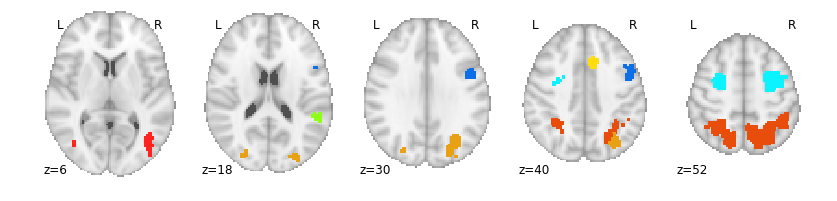

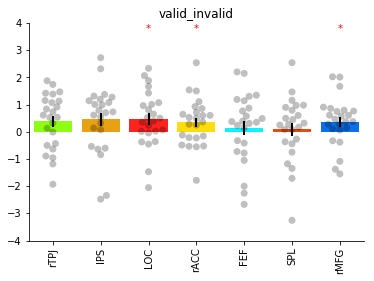

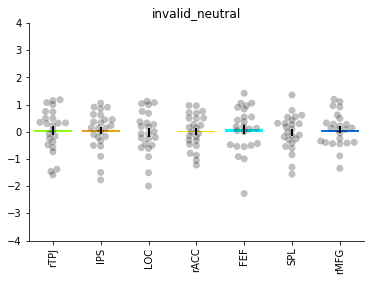

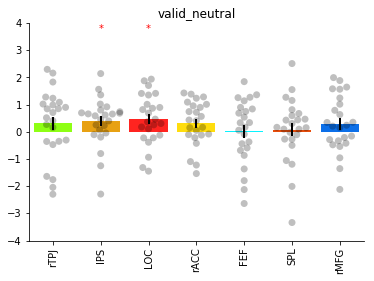

In [32]:
# What type of ROI do you want to use
ns_ROI_type = 'dilated' # 'raw', 'dilated', or 'spheres'
ns_ROI_file = '%s/ns_%s.nii.gz' % (atlas_dir, ns_ROI_type)

# Load in the ROI
nii = nib.load(ns_ROI_file)
ns_ROI = nii.get_data()

np.random.seed(0)

# Show the rois
nii = nib.Nifti1Image(ns_ROI, nii.affine)
#plotting.view_img(nii, cmap=ns_ROI_colormap_dual)


plotting.plot_stat_map(nii,
                       cut_coords=[52, 40, 30, 18, 6],
                       vmax = ns_ROI.max(),
                       display_mode='z',
                       cmap=ns_ROI_colormap_dual,
                       draw_cross=False,
                       colorbar=False,
                       symmetric_cbar=False,
                      )

plt.savefig(plot_dir + 'neurosynth_ROI_%s.svg' % (ns_ROI_type))


print('\nDo the valid_invalid contrast')
condition = 'valid_invalid'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


print('\nDo the invalid_neutral contrast')
condition = 'invalid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)

plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


print('\nDo the valid_neutral contrast')
condition = 'valid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


**Do the ROI analysis with sphere ROIs**

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)



Do the valid_invalid contrast
Flipping sign for consistency
rTPJ: 16/24, M=0.35, CI=[-0.09, 0.76], p=0.114
IPS: 17/24, M=0.45, CI=[-0.04, 0.91], p=0.069
LOC: 15/24, M=0.48, CI=[0.07, 0.87], p=0.020
rACC: 16/24, M=0.32, CI=[-0.02, 0.68], p=0.060
FEF: 16/24, M=0.16, CI=[-0.36, 0.64], p=0.524
SPL: 14/24, M=0.08, CI=[-0.40, 0.54], p=0.755
rMFG: 16/24, M=0.32, CI=[-0.03, 0.67], p=0.070

Do the invalid_neutral contrast
rTPJ: 14/24, M=0.06, CI=[-0.26, 0.36], p=0.723
IPS: 14/24, M=-0.01, CI=[-0.32, 0.27], p=0.969
LOC: 11/24, M=-0.03, CI=[-0.36, 0.28], p=0.868
rACC: 14/24, M=0.04, CI=[-0.20, 0.26], p=0.733
FEF: 15/24, M=0.11, CI=[-0.25, 0.45], p=0.534
SPL: 12/24, M=-0.06, CI=[-0.33, 0.19], p=0.640
rMFG: 12/24, M=0.07, CI=[-0.22, 0.35], p=0.647

Do the valid_neutral contrast
Flipping sign for consistency
rTPJ: 16/24, M=0.27, CI=[-0.21, 0.74], p=0.260
IPS: 19/24, M=0.45, CI=[0.09, 0.78], p=0.013
LOC: 17/24, M=0.48, CI=[0.11, 0.84], p=0.012
rACC: 16/24, M=0.28, CI=[-0.07, 0.59], p=0.115
FEF: 14/2

Text(0.5, 1.0, 'valid_neutral')

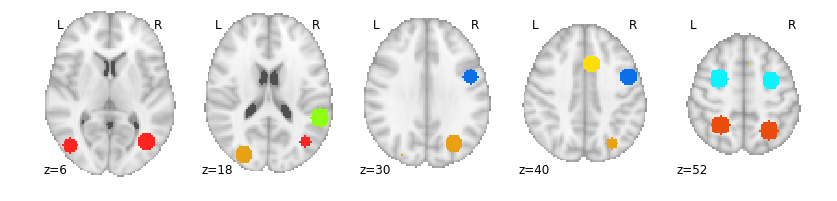

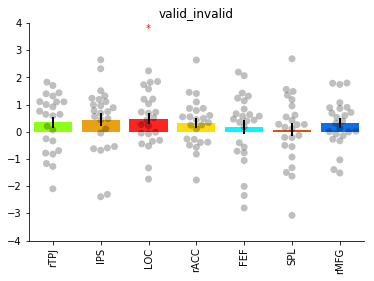

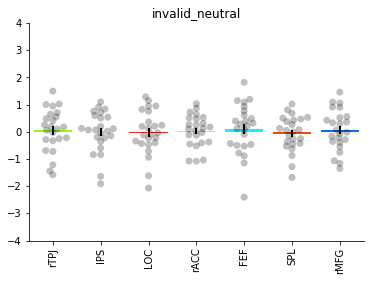

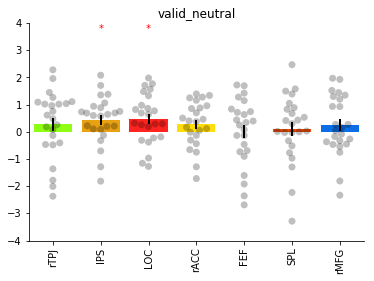

In [33]:
# What type of ROI do you want to use
ns_ROI_type = 'spheres' # 'raw', 'dilated', or 'spheres'
ns_ROI_file = '%s/ns_%s.nii.gz' % (atlas_dir, ns_ROI_type)

# Load in the ROI
nii = nib.load(ns_ROI_file)
ns_ROI = nii.get_data()

np.random.seed(0)

# Show the rois
nii = nib.Nifti1Image(ns_ROI, nii.affine)
#plotting.view_img(nii, cmap=ns_ROI_colormap_dual)


plotting.plot_stat_map(nii,
                       cut_coords=[52, 40, 30, 18, 6],
                       vmax = ns_ROI.max(),
                       display_mode='z',
                       cmap=ns_ROI_colormap_dual,
                       draw_cross=False,
                       colorbar=False,
                       symmetric_cbar=False,
                      )

plt.savefig(plot_dir + 'neurosynth_ROI_%s.svg' % (ns_ROI_type))


print('\nDo the valid_invalid contrast')
condition = 'valid_invalid'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


print('\nDo the invalid_neutral contrast')
condition = 'invalid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)

plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


print('\nDo the valid_neutral contrast')
condition = 'valid_neutral'

nii = nib.load('%s/masked_data/%s.nii.gz' % (data_dir, condition))
vol = nii.get_data()

print('Flipping sign for consistency')
vol *= -1

mask_ROIs(vol, ns_ROI, collapse_bilateral, use_corrected_p_val)
plt.savefig('%s/ns_%s_%s.svg' % (plot_dir, ns_ROI_type, condition))
plt.title(condition)


**Perform the LOO ROI analyses**  
First set some variable parameters

In [34]:
# Minimum percentage for you to use the cortical labels
min_prct_ROI = 50 

# Minimum participant proportion for including ROI
min_ppt_ROI = 0.5

# List the ROIs you are going to ignore (since you don't expect any signal and these tend to be broadly distributed throughout the brain)
ignored_ROIs = np.asarray(['r_Right Cerebral Cortex', 'r_Right Cerebral White Matter', 'r_Right Lateral Ventricle', 'l_Left Cerebral Cortex', 'l_Left Cerebral Cortex ', 'l_Left Cerebral White Matter', 'l_Left Lateral Ventricle'])

# Reload the neurosynth ROI in case it has been changed
ns_ROI_file = '%s/ns_raw.nii.gz' % (atlas_dir)
nii = nib.load(ns_ROI_file)
ns_ROI = nii.get_data()

# Reset the seed
np.random.seed(0)

**Run the LOO valid vs invalid contrast**

Flipping sign for consistency
l_Left Caudate: M=0.63, 14/19, p=0.003
l_Left Thalamus: M=0.42, 15/22, p=0.008
r_Cingulate Gyrus, anterior division: M=0.84, 10/12, p=0.000
r_Frontal Pole: M=0.67, 14/17, p=0.000
r_Inferior Frontal Gyrus, pars triangularis: M=0.73, 17/21, p=0.000
r_Lateral Occipital Cortex, inferior division: M=0.50, 14/17, p=0.014
r_Lingual Gyrus: M=0.46, 13/19, p=0.032
r_Paracingulate Gyrus: M=0.49, 18/24, p=0.004
r_Precentral Gyrus: M=0.61, 18/21, p=0.001
r_Right Thalamus: M=0.36, 16/24, p=0.061
                                          labels  orig p  corr thresh  is sig
0           r_Cingulate Gyrus, anterior division  0.0000     0.005000       1
1                                 r_Frontal Pole  0.0000     0.005556       1
2    r_Inferior Frontal Gyrus, pars triangularis  0.0000     0.006250       1
3                             r_Precentral Gyrus  0.0014     0.007143       1
4                                 l_Left Caudate  0.0028     0.008333       1
5              

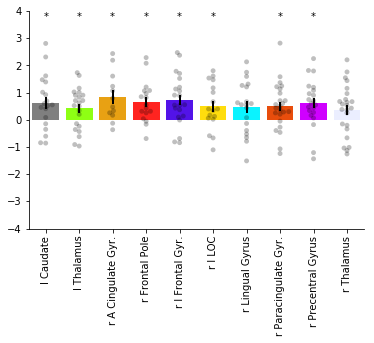

In [35]:
condition = 'valid_invalid'

usable_ROIs, ROI_names_all, cluster_idxs_all = unique_ROIs(df['ID'], condition, min_ppt_ROI) # Get the ROIs that are being used
LOO_df = generate_LOO_df(df['ID'], condition, usable_ROIs, ROI_names_all, cluster_idxs_all) # Get the average value per ROI per participant
sig_ROI_names = mask_LOO_roi(LOO_df, flip_sign=True, plot_color=True) # Generate the significance thresholds
valid_invalid_sig_ROI_names = sig_ROI_names
plt.savefig('%s/LOO_ROIs_%s.svg' % (plot_dir, condition))

**Give a toy example to show the logic of the LOO analysis**  
Test how many participants show an effect in a specific coordinate (in this case an ROI belonging to ACC) as a way to demonstrate that this procedure doesn't necessarily find only participants showing an effect. You can see that in this example 18 participants have an invalid > valid effect in this voxel but only 12 pariticipants are used in the LOO, of which not all have the effect in this direction

In [36]:
ppt_has_ROI = np.asarray(LOO_df['Ppt'])[np.isnan(LOO_df['r_Cingulate Gyrus, anterior division']) == 0]
ppt_hasnt_ROI = np.asarray(LOO_df['Ppt'])[np.isnan(LOO_df['r_Cingulate Gyrus, anterior division']) == 1]
coord = [94, 162, 88] 

contrast_num = 1 # Based on the ROI names valid > invalid 

MNI_coords = image.coord_transform(coord[0], coord[1], coord[2], nii.affine)

print('Coords of voxel of interest', MNI_coords )

print('Included participants')
for ppt in ppt_has_ROI:
    vol = nib.load('%s/contrast_maps/%s_Validity_zstat%d.nii.gz' % (data_dir, ppt, contrast_num)).get_data()
    print('%s\t%0.2f' % (ppt, vol[coord[0], coord[1], coord[2]]))    
    
print('Not included participants')
for ppt in ppt_hasnt_ROI:
    vol = nib.load('%s/contrast_maps/%s_Validity_zstat%d.nii.gz' % (data_dir, ppt, contrast_num)).get_data()
    print('%s\t%0.2f' % (ppt, vol[coord[0], coord[1], coord[2]]))    


Coords of voxel of interest (-4.0, 36.0, 16.0)
Included participants
s8687_1_3	0.62
s4607_1_3	-2.04
s6057_1_1	-0.54
s0057_1_2	-2.64
s1057_1_3	-1.36
s7017_1_4	-0.98
s3017_1_1	-0.37
s2037_1_2	0.27
s7037_1_1	-1.17
s7067_1_2	-1.90
s6607_1_1	-0.42
s4607_1_2	-0.36
Not included participants
s6687_1_3	-0.13
s3607_1_2	-1.15
s9057_1_1	0.31
s0057_1_1	-0.01
s1057_1_2	-0.27
s2037_1_1	-0.54
s5037_1_1	0.34
s6067_1_1	0.32
s8047_1_1	-0.00
s2687_1_2	-1.94
s3687_1_2	-0.70
s1607_1_1	0.49


**Plot the counts of voxels in clusters across the LOO repetitions for invalid > valid and overlay the selected ROIs** 

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths

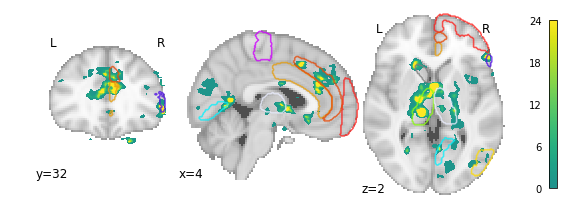

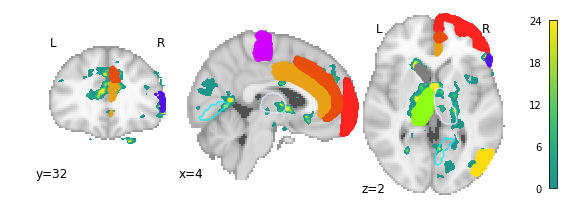

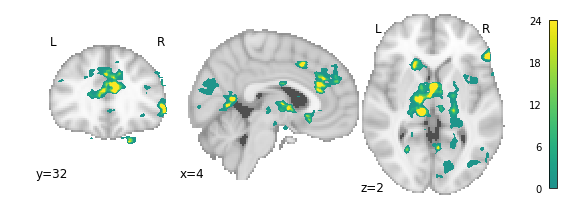

In [37]:
cut_coords = (4,32,2) # Where should the slice go
count_threshold = 0
analysis_type = 'Validity'

# Plot the ROIs that you are using for this analysis
plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace.svg' % (plot_dir, analysis_type, condition))

plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, sig_ROI_names, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace_filled.svg' % (plot_dir, analysis_type, condition))

plot_LOO_ROI_tracing(analysis_type, condition, [], cut_coords, [], count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace_none.svg' % (plot_dir, analysis_type, condition))


**Run the valid vs neutral contrast**

Flipping sign for consistency
l_Brain-Stem: M=0.55, 12/17, p=0.016
l_Central Opercular Cortex: M=0.95, 16/16, p=0.000
l_Frontal Medial Cortex: M=-0.04, 9/14, p=0.727
l_Insular Cortex: M=0.12, 9/13, p=0.399
l_Lateral Occipital Cortex, superior division: M=1.15, 15/15, p=0.000
l_Left Putamen: M=0.93, 17/18, p=0.000
l_Left Thalamus: M=0.58, 15/20, p=0.000
l_Parietal Operculum Cortex: M=0.77, 12/16, p=0.000
l_Superior Temporal Gyrus, posterior division: M=0.99, 14/15, p=0.000
r_Frontal Medial Cortex: M=0.47, 11/14, p=0.026
r_Lateral Occipital Cortex, superior division: M=0.51, 18/23, p=0.012
r_Right Hippocampus: M=0.08, 10/20, p=0.653
r_Right Thalamus: M=0.34, 14/24, p=0.055
                                           labels  orig p  corr thresh  is sig
0                      l_Central Opercular Cortex  0.0000     0.003846       1
1   l_Lateral Occipital Cortex, superior division  0.0000     0.004167       1
2                                  l_Left Putamen  0.0000     0.004545       1
3   

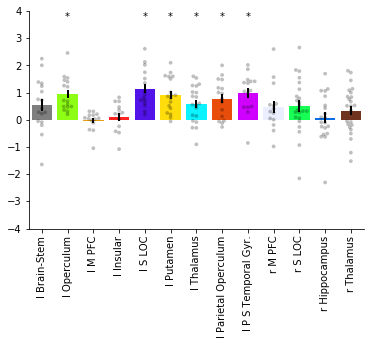

In [38]:
condition = 'valid_neutral'

usable_ROIs, ROI_names_all, cluster_idxs_all = unique_ROIs(df['ID'], condition, min_ppt_ROI) # Get the ROIs that are being used
LOO_df = generate_LOO_df(df['ID'], condition, usable_ROIs, ROI_names_all, cluster_idxs_all) # Get the average value per ROI per participant
sig_ROI_names = mask_LOO_roi(LOO_df, flip_sign=True, plot_color=True) # Generate the significance thresholds
valid_invalid_sig_ROI_names = sig_ROI_names
plt.savefig('%s/LOO_ROIs_%s.svg' % (plot_dir, condition))

**Plot the counts of voxels in clusters across the LOO repetitions for valid > and overlay the selected ROIs** 

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


Could not find Left Brain-Stem, skipping


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:124

Could not find Left Brain-Stem, skipping


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a maske

/gpfs/milgram/apps/hpc.rhel7/software/nilearn/0.5.0-Python-Anaconda3/lib/python3.6/site-packages/nilearn-0.5.0-py3.6.egg/nilearn/plotting/displays.py:763: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked elemen

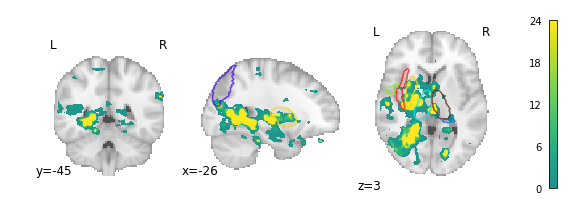

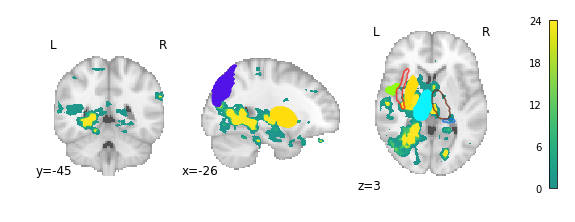

In [39]:
cut_coords = None
count_threshold = 0
analysis_type = 'Validity'

# Plot the ROIs that you are using for this analysis
plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace.svg' % (plot_dir, analysis_type, condition))

plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, sig_ROI_names, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace_filled.svg' % (plot_dir, analysis_type, condition))

**Run the invalid vs neutral contrast**  
Note a quirk here: the analysis is normally asking whether invalid is greater than neutral, but to pull out clusters it is necessary to flip the sign, this analysis then effectively flips it back so that positive still means invalid is higher than neutral


l_Lateral Occipital Cortex, inferior division: M=-0.17, 9/19, p=0.386
r_Cingulate Gyrus, posterior division: M=-0.44, 5/23, p=0.002
r_Lateral Occipital Cortex, superior division: M=-0.40, 8/24, p=0.008
                                          labels  orig p  corr thresh  is sig
0          r_Cingulate Gyrus, posterior division  0.0020     0.016667       1
1  r_Lateral Occipital Cortex, superior division  0.0082     0.025000       1
2  l_Lateral Occipital Cortex, inferior division  0.3856     0.050000       0


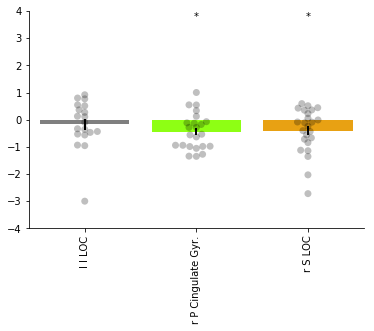

In [40]:
condition = 'invalid_neutral'

usable_ROIs, ROI_names_all, cluster_idxs_all = unique_ROIs(df['ID'], condition, min_ppt_ROI) # Get the ROIs that are being used
LOO_df = generate_LOO_df(df['ID'], condition, usable_ROIs, ROI_names_all, cluster_idxs_all) # Get the average value per ROI per participant
sig_ROI_names = mask_LOO_roi(LOO_df, flip_sign=False, plot_color=True) # Generate the significance thresholds
valid_invalid_sig_ROI_names = sig_ROI_names
plt.savefig('%s/LOO_ROIs_%s.svg' % (plot_dir, condition))

**Plot the counts of voxels in clusters across the LOO repetitions for neutral > invalid and overlay the selected ROIs** 

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/

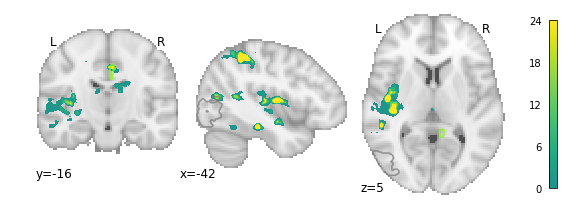

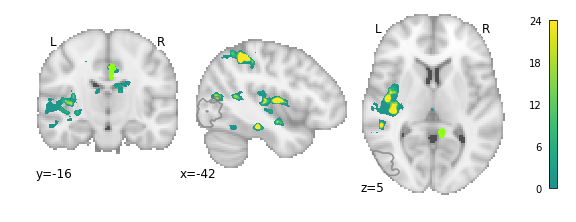

In [41]:
cut_coords = None
count_threshold = 0
analysis_type = 'Validity'

# Plot the ROIs that you are using for this analysis
plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace.svg' % (plot_dir, analysis_type, condition))

plot_LOO_ROI_tracing(analysis_type, condition, usable_ROIs, cut_coords, sig_ROI_names, count_threshold=count_threshold)
plt.savefig('%s/%s_%s_ROI_trace_filled.svg' % (plot_dir, analysis_type, condition))